### Master Thesis - ISCTE - Masters in Data Science
#### How to improve Intrusion Detection Systems - Combining Imbalanced Learning with Anomaly Detection Algorithms
##### Tiago Manuel Alves - Student 120400

#####  PART 2 OF 3

Placeholder for introduction and motivation

In [1]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.9/185.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [3]:
# =============================================================================
# MASTERS IN DATA SCIENCE - ISCTE
# STUDENT - Tiago Manuel Alves | 120400
# COMPREHENSIVE EDA AND CTGAN IMPLEMENTATION FOR NETWORK INTRUSION DETECTION
# Dataset: HIKARI-2022 Network Traffic Dataset (Source: https://zenodo.org/records/6463389 - Version 1.4 - HIKARI2022 ALLFLOW)
# Purpose: Exploratory Data Analysis and Synthetic Data Generation for Minority Classes
# PART 2 OF 3
# =============================================================================


import os
import sys
import warnings
import logging
from pathlib import Path
from datetime import datetime
import hashlib
import json

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from sklearn.decomposition import PCA

# Deep Learning Libraries (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

# CTGAN and Synthetic Data
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

# Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency
import random

# SECURITY CONFIGURATION
class SecurityConfig:
    """Security configuration and validation"""

    @staticmethod
    def setup_secure_environment():
        """Setup secure computing environment"""
        # Set random seeds for reproducibility
        RANDOM_SEED = 42
        np.random.seed(RANDOM_SEED)
        torch.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)
        random.seed(RANDOM_SEED)

        # Configure warnings and logging
        warnings.filterwarnings('ignore', category=FutureWarning)
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

        return RANDOM_SEED

    @staticmethod
    def validate_data_integrity(df, expected_columns=None):
        """Validate data integrity and detect potential issues"""
        issues = []

        # Check for suspicious patterns
        if df.isnull().all().any():
            issues.append("Completely empty columns detected")

        if (df.dtypes == 'object').any():
            text_cols = df.select_dtypes(include=['object']).columns
            for col in text_cols:
                if df[col].str.contains(r'[<>&"\']', regex=True, na=False).any():
                    issues.append(f"⚠️  Potential injection patterns in {col}")

        if expected_columns and not set(expected_columns).issubset(set(df.columns)):
            missing = set(expected_columns) - set(df.columns)
            issues.append(f"Missing expected columns: {missing}")

        return issues

# AESTHETIC CONFIGURATION
class AestheticConfig:
    """Enhanced visualization styling"""

    # Color palettes
    COLORS = {
        'primary': '#2E86AB',
        'secondary': '#A23B72',
        'accent': '#F18F01',
        'success': '#C73E1D',
        'warning': '#FFB400',
        'info': '#17A2B8',
        'light': '#F8F9FA',
        'dark': '#343A40'
    }

    PALETTE_MODERN = ['#667eea', '#764ba2', '#f093fb', '#f5576c', '#4facfe', '#00f2fe']
    PALETTE_CYBERSEC = ['#0d1421', '#1e3a8a', '#3b82f6', '#60a5fa', '#93c5fd', '#dbeafe']

    @staticmethod
    def setup_plot_style():
        """Configure modern plot styling"""
        plt.style.use('default')

        # Custom rcParams for better aesthetics
        plt.rcParams.update({
            'figure.facecolor': 'white',
            'axes.facecolor': '#f8f9fa',
            'axes.edgecolor': '#dee2e6',
            'axes.linewidth': 0.8,
            'axes.grid': True,
            'grid.alpha': 0.3,
            'grid.linewidth': 0.5,
            'font.size': 10,
            'font.family': 'sans-serif',
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 10,
            'figure.titlesize': 16
        })

        # Seaborn styling
        sns.set_palette(AestheticConfig.PALETTE_MODERN)

        # Plotly default renderer
        pio.renderers.default = 'notebook'

# Initialize security and aesthetics
RANDOM_SEED = SecurityConfig.setup_secure_environment()
AestheticConfig.setup_plot_style()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("ENHANCED HIKARI-2022 NETWORK INTRUSION DETECTION SYSTEM")
print("EDA + CTGAN + Deep Learning Implementation")
print("="*80)
print(f"Computing Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"Random Seed: {RANDOM_SEED}")
print("="*80)


ENHANCED HIKARI-2022 NETWORK INTRUSION DETECTION SYSTEM
EDA + CTGAN + Deep Learning Implementation
Computing Device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
Random Seed: 42


# Section 1: Load the Dataset

The goal of this step is to load the dataset and understand its structure. After Running the cells below we will be able to find:
- The structure of the dataset
- The shape of the dataset (how many rows and columns)
- A quick overview of the dataset
- What kind and how many features the dataset has
- Missing values handling

In [4]:
# =============================================================================
# SECTION 1: DATA LOADING AND INITIAL INSPECTION
# =============================================================================

def load_and_inspect_data(file_path, random_seed=RANDOM_SEED):
    """
    Load the HIKARI-2021 dataset and perform initial inspection
    """
    print("\n" + "="*60)
    print("SECTION 1: DATA LOADING AND INITIAL INSPECTION")
    print("="*60)

    # Load the dataset
    print("Loading HIKARI-2022 dataset...")
    df = pd.read_csv(file_path)

    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Basic information
    print("\n" + "-"*40)
    print("BASIC DATASET INFORMATION")
    print("-"*40)
    print(f"Number of rows: {df.shape[0]:,}")
    print(f"Number of columns: {df.shape[1]:,}")
    print(f"Number of features (excluding target): {df.shape[1] - 2:,}")  # Excluding Label and attack_category

    # Display first few rows
    print("\n" + "-"*40)
    print("FIRST 5 ROWS OF THE DATASET")
    print("-"*40)
    display(df.head())

    # Data types analysis
    print("\n" + "-"*40)
    print("DATA TYPES ANALYSIS")
    print("-"*40)
    dtype_counts = df.dtypes.value_counts()
    print("Data type distribution:")
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns ({count/len(df.columns)*100:.1f}%)")

    # Missing values analysis
    print("\n" + "-"*40)
    print("MISSING VALUES ANALYSIS")
    print("-"*40)
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing_Count': missing_values.values,
        'Missing_Percentage': missing_percentage.values
    }).sort_values('Missing_Count', ascending=False)

    columns_with_missing = missing_df[missing_df['Missing_Count'] > 0]
    if len(columns_with_missing) > 0:
        print("Columns with missing values:")
        display(columns_with_missing.head(10))
    else:
        print("✓ No missing values found in the dataset!")

    return df

# ==========================================================
# EXECUTION
# ==========================================================

# Load the dataset
df = load_and_inspect_data('/content/drive/MyDrive/Thesis_Work/ALLFLOWMETER_HIKARI2022.csv')



SECTION 1: DATA LOADING AND INITIAL INSPECTION
Loading HIKARI-2022 dataset...
Dataset loaded successfully!
Dataset shape: (228253, 88)
Memory usage: 213.15 MB

----------------------------------------
BASIC DATASET INFORMATION
----------------------------------------
Number of rows: 228,253
Number of columns: 88
Number of features (excluding target): 86

----------------------------------------
FIRST 5 ROWS OF THE DATASET
----------------------------------------


,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,...,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,attack_category,Label
0,0,Cmu9v81jToQyRF1gbk,184.0.48.168,38164,184.0.48.150,50443,0 days 00:00:00.000060,1,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
1,1,CO21hl3TWkuXTOgajk,184.0.48.169,43068,184.0.48.150,50443,0 days 00:00:00.000083,1,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
2,2,CBLJ6L19FP0MfYX7Oh,184.0.48.124,5678,255.255.255.255,5678,0 days 00:01:59.996602,3,0,3,...,5.999912e+07,1.199966e+08,5.999830e+07,1156.846698,0,0,0,0,Benign,0
3,3,ChTG451zJ7hUYOcqje,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.996909,2,0,2,...,5.999691e+07,5.999691e+07,5.999691e+07,0.000000,0,0,0,0,Benign,0
4,4,Cn9y6E2KVxzQbs5wjc,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.992130,2,0,2,...,5.999213e+07,5.999213e+07,5.999213e+07,0.000000,0,0,0,0,Benign,0



----------------------------------------
DATA TYPES ANALYSIS
----------------------------------------
Data type distribution:
  float64: 55 columns (62.5%)
  int64: 28 columns (31.8%)
  object: 5 columns (5.7%)

----------------------------------------
MISSING VALUES ANALYSIS
----------------------------------------
✓ No missing values found in the dataset!


# Section 2: Variable Analysis and Imbalance Investigation

The goal of this section is to analyze the variables that we have and how imbalanced the dataset is. After Running the cells below we will be able to find:
- Have a visual overview of dataset
- Calculate the Imbalance Ratio (if any)
- Analyze the number of attacks and what kind of attacks were found.



SECTION 2: TARGET VARIABLE ANALYSIS

----------------------------------------
BINARY LABEL DISTRIBUTION ANALYSIS
----------------------------------------
Label distribution:
  0: 214,904 samples (94.15%)
  1: 13,349 samples (5.85%)

Imbalance Ratio: 16.10:1
Minority class represents 5.85% of the data

----------------------------------------
ATTACK CATEGORY DISTRIBUTION ANALYSIS
----------------------------------------
Attack category distribution:
  1. Benign: 214,904 samples (94.15%)
  2. XMRIGCC CryptoMiner: 7,595 samples (3.33%)
  3. Bruteforce-XML: 3,650 samples (1.60%)
  4. Bruteforce: 2,104 samples (0.92%)


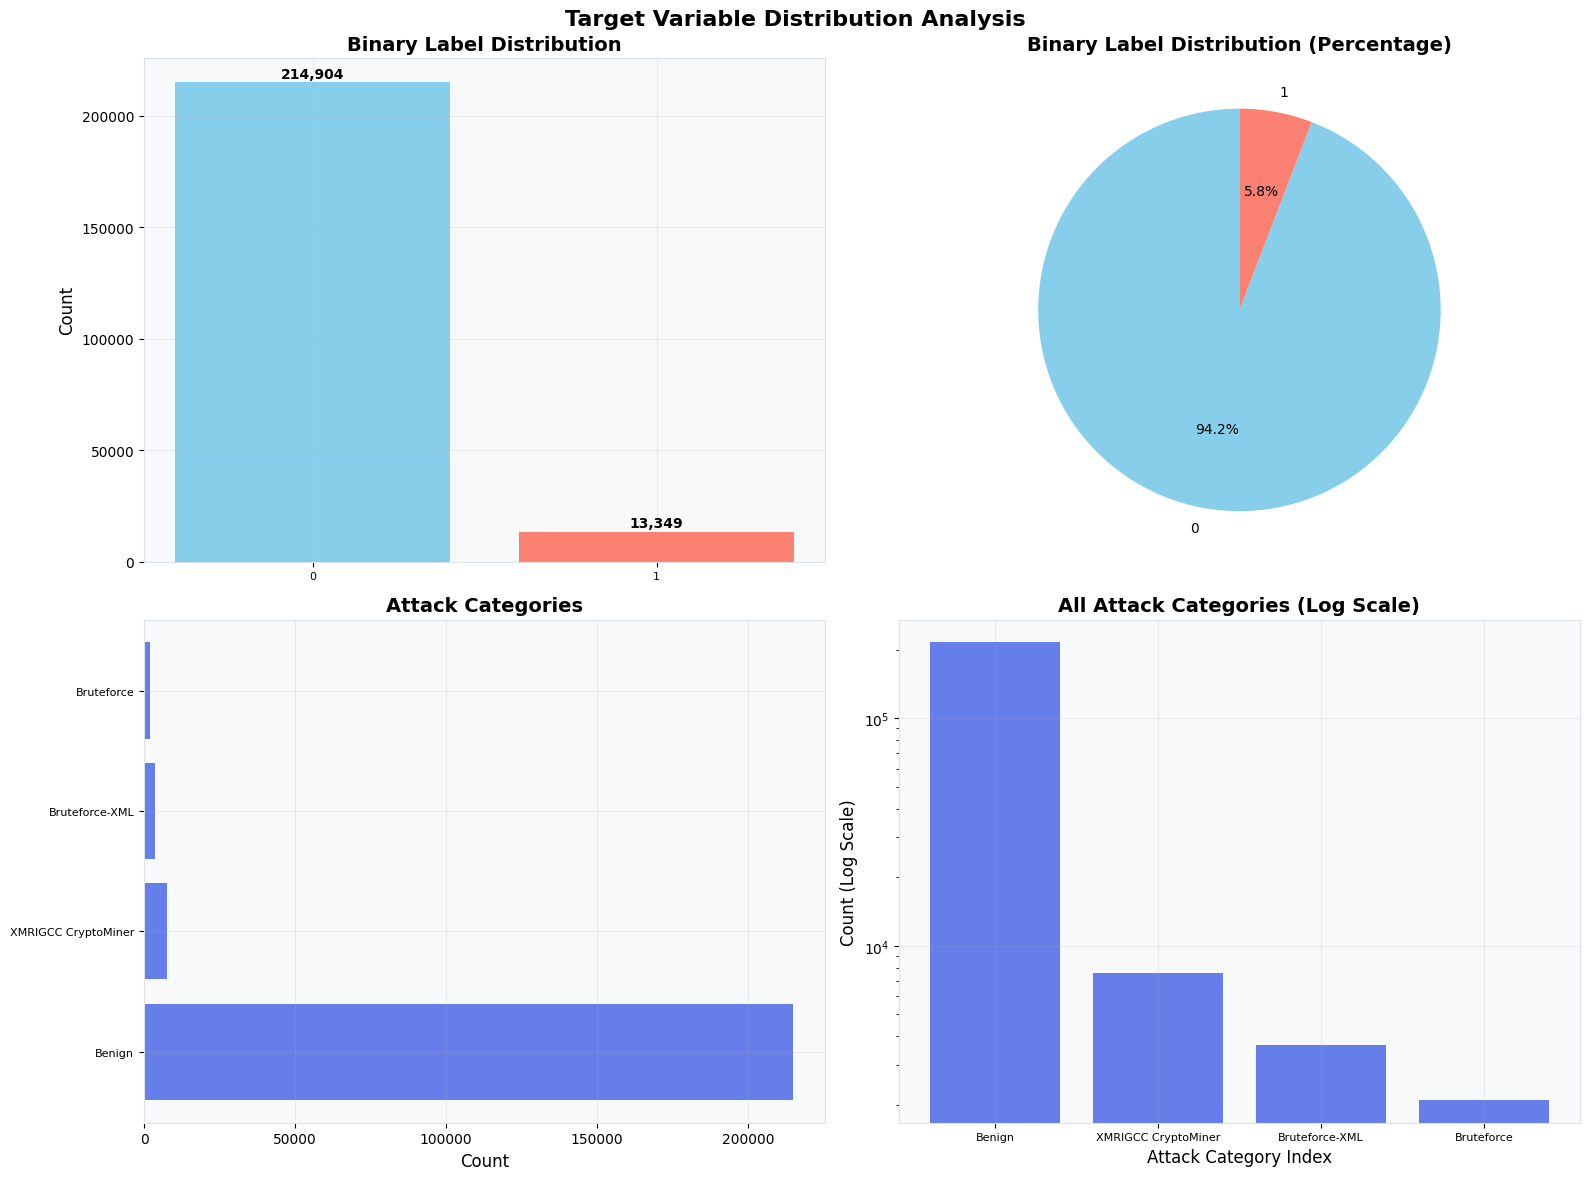


----------------------------------------
MINORITY CLASS IDENTIFICATION FOR CTGAN
----------------------------------------
Minority classes (< 22,825 samples):
  1: 13,349 samples (5.848%)


In [5]:
# =============================================================================
# SECTION 2: TARGET VARIABLE ANALYSIS AND CLASS IMBALANCE INVESTIGATION
# =============================================================================

def analyze_target_variables(df, random_state=RANDOM_SEED):
    """
    Comprehensive analysis of Label and attack_category variables
    """
    print("\n" + "="*60)
    print("SECTION 2: TARGET VARIABLE ANALYSIS")
    print("="*60)

    # Binary Label Analysis
    print("\n" + "-"*40)
    print("BINARY LABEL DISTRIBUTION ANALYSIS")
    print("-"*40)

    label_counts = df['Label'].value_counts()
    label_percentages = df['Label'].value_counts(normalize=True) * 100

    print("Label distribution:")
    for label, count in label_counts.items():
        percentage = label_percentages[label]
        print(f"  {label}: {count:,} samples ({percentage:.2f}%)")

    # Calculate imbalance ratio
    if len(label_counts) == 2:
        majority_class = label_counts.max()
        minority_class = label_counts.min()
        imbalance_ratio = majority_class / minority_class
        print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
        print(f"Minority class represents {(minority_class/len(df)*100):.2f}% of the data")

    # Attack Category Analysis
    print("\n" + "-"*40)
    print("ATTACK CATEGORY DISTRIBUTION ANALYSIS")
    print("-"*40)

    attack_counts = df['attack_category'].value_counts()
    attack_percentages = df['attack_category'].value_counts(normalize=True) * 100

    print("Attack category distribution:")
    for i, (category, count) in enumerate(attack_counts.items()):
        percentage = attack_percentages[category]
        print(f"  {i+1}. {category}: {count:,} samples ({percentage:.2f}%)")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Target Variable Distribution Analysis', fontsize=16, fontweight='bold')

    # Binary Label Distribution (Bar Plot)
    axes[0,0].bar(label_counts.index, label_counts.values, color=['skyblue', 'salmon'])
    axes[0,0].set_title('Binary Label Distribution', fontweight='bold')
    axes[0,0].set_xticks(range(len(label_counts.index)))
    axes[0,0].set_xticklabels(label_counts.index, fontsize=8)
    axes[0,0].set_ylabel('Count')
    for i, v in enumerate(label_counts.values):
        axes[0,0].text(i, v + max(label_counts.values)*0.01, f'{v:,}', ha='center', fontweight='bold')

    # Binary Label Distribution (Pie Chart)
    axes[0,1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
                  colors=['skyblue', 'salmon'], startangle=90)
    axes[0,1].set_title('Binary Label Distribution (Percentage)', fontweight='bold')

    # Attack Category Distribution
    attacks = attack_counts.head(10)
    axes[1,0].barh(range(len(attacks)), attacks.values)
    axes[1,0].set_yticks(range(len(attacks)))
    axes[1,0].set_yticklabels(attacks.index, fontsize=8)
    axes[1,0].set_title('Attack Categories', fontweight='bold')
    axes[1,0].set_xlabel('Count')

    # Attack Category Distribution (Log Scale)
    axes[1,1].bar(range(len(attack_counts)), attack_counts.values)
    axes[1,1].set_xticks(range(len(attacks)))
    axes[1,1].set_xticklabels(attacks.index, fontsize=8)
    axes[1,1].set_yscale('log')
    axes[1,1].set_title('All Attack Categories (Log Scale)', fontweight='bold')
    axes[1,1].set_xlabel('Attack Category Index')
    axes[1,1].set_ylabel('Count (Log Scale)')

    plt.tight_layout()
    plt.show()

    # Identify minority classes for CTGAN
    print("\n" + "-"*40)
    print("MINORITY CLASS IDENTIFICATION FOR CTGAN")
    print("-"*40)

    # Define threshold for minority classes (e.g., less than 10% of total data)
    min_counts = df['Label'].value_counts()
    min_percentages = df['Label'].value_counts(normalize=True) * 100

    minority_threshold = len(df) * 0.10
    minority_attacks = min_counts[min_counts < minority_threshold]

    print(f"Minority classes (< {minority_threshold:,.0f} samples):")
    for attack, count in minority_attacks.items():
        percentage = (count / len(df)) * 100
        print(f"  {attack}: {count:,} samples ({percentage:.3f}%)")

    return label_counts, attack_counts, minority_attacks

# ==========================================================
# EXECUTION
# ==========================================================

# Analyze target variables
label_dist, attack_dist, minority_classes = analyze_target_variables(df)


# Section 3 - Comprehensive Feature Analysis

## Goal
- Explore Dataset and its features
- Analyze the Extreme Values

In [6]:
# =============================================================================
# SECTION 3: COMPREHENSIVE FEATURE ANALYSIS
# =============================================================================

def analyze_network_features(df, random_state=RANDOM_SEED):
    """
    Comprehensive analysis of network traffic features
    """
    print("\n" + "="*60)
    print("SECTION 3: NETWORK FEATURES ANALYSIS")
    print("="*60)

    # Remove identifier columns for analysis
    id_columns = ['Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp']
    feature_columns = [col for col in df.columns if col not in id_columns + ['Label', 'attack_category']]

    print(f"Analyzing {len(feature_columns)} network traffic features...")
    '''
    # Categorize features by type
    feature_categories = {
        'temporal': [col for col in feature_columns if any(keyword in col.lower()
                    for keyword in ['duration', 'iat', 'time', 'active', 'idle'])],
        'volume': [col for col in feature_columns if any(keyword in col.lower()
                  for keyword in ['pkts', 'bytes', 'payload', 'size'])],
        'protocol': [col for col in feature_columns if any(keyword in col.lower()
                    for keyword in ['flag', 'syn', 'ack', 'fin', 'rst', 'psh', 'urg', 'cwr', 'ece'])],
        'behavioral': [col for col in feature_columns if any(keyword in col.lower()
                      for keyword in ['ratio', 'rate', 'bulk', 'window', 'subflow'])],
        'statistical': [col for col in feature_columns if any(keyword in col.lower()
                       for keyword in ['min', 'max', 'avg', 'std', 'tot'])]
    }
    '''

    # Categorize features by type
    feature_categories = {
        #'id' : [col for col, in feature_columns if any(keyword in col.lower()
                #for keyword in ['Unnamed: 0 ', 'uid',  'originh',  'originp', 'responh', 'responp'])],
        'temporal': [col for col in feature_columns if any(keyword in col.lower()
                    for keyword in ['flow_duration', 'fwd_iat.tot', 'bwd_iat.tot', 'flow_iat.tot', 'active.tot', 'idle.tot'])],
        'volume': [col for col in feature_columns if any(keyword in col.lower()
                  for keyword in ['fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_header_size_tot',
                                  'bwd_header_size_tot', 'fwd_pkts_payload.tot', 'bwd_pkts_payload.tot', 'flow_pkts_payload.tot'])],
        'protocol': [col for col in feature_columns if any(keyword in col.lower()
                    for keyword in ['flow_fin_flag_count','flow_syn_flag_count','flow_rst_flag_count','fwd_psh_flag_count','bwd_psh_flag_count',
                                    'flow_ack_flag_count','fwd_urg_flag_count','bwd_urg_flag_count','flow_cwr_flag_count','flow_ece_flag_count'])],
        'behavioral': [col for col in feature_columns if any(keyword in col.lower()
                      for keyword in ['fwd_pkts_per_sec','bwd_pkts_per_sec','flow_pkts_per_sec','down_up_ratio','payload_bytes_per_second','fwd_subflow_pkts','bwd_subflow_pkts',
                                    'fwd_subflow_bytes','bwd_subflow_bytes','fwd_bulk_bytes','bwd_bulk_bytes','fwd_bulk_packets','bwd_bulk_packets','fwd_bulk_rate','bwd_bulk_rate','fwd_init_window_size',
                                    'bwd_init_window_size','fwd_last_window_size','bwd_last_window_size'])],
        'statistical': [col for col in feature_columns if any(keyword in col.lower()
                       for keyword in ['fwd_header_size_min','fwd_header_size_max','bwd_header_size_min','bwd_header_size_max','fwd_pkts_payload.min','fwd_pkts_payload.max','fwd_pkts_payload.avg',
                                    'fwd_pkts_payload.std','bwd_pkts_payload.min','bwd_pkts_payload.max','bwd_pkts_payload.avg','bwd_pkts_payload.std','flow_pkts_payload.min','flow_pkts_payload.max',
                                    'flow_pkts_payload.avg','flow_pkts_payload.std','fwd_iat.min','fwd_iat.max','fwd_iat.avg','fwd_iat.std','bwd_iat.min','bwd_iat.max','bwd_iat.avg',
                                    'bwd_iat.std','flow_iat.min','flow_iat.max','flow_iat.avg','flow_iat.std','active.min','active.max','active.avg','active.std','idle.min','idle.max','idle.avg',
                                    'idle.std'])]
    }

    # Remove duplicates and categorize remaining
    categorized_features = set()
    for category, features in feature_categories.items():
        categorized_features.update(features)
        print(f"{category.upper()} features ({len(features)}): {features[:5]}{'...' if len(features) > 5 else ''}")

    uncategorized = [col for col in feature_columns if col not in categorized_features]
    if uncategorized:
        print(f"UNCATEGORIZED features ({len(uncategorized)}): {uncategorized}")

    # Statistical summary
    print("\n" + "-"*40)
    print("STATISTICAL SUMMARY OF NUMERICAL FEATURES")
    print("-"*40)

    numerical_features = df[feature_columns].select_dtypes(include=[np.number]).columns
    stats_summary = df[numerical_features].describe()

    print("Key statistics for numerical features:")
    print(f"  Total numerical features: {len(numerical_features)}")
    print(f"  Features with zero minimum: {(stats_summary.loc['min'] == 0).sum()}")
    print(f"  Features with high variance (std > mean): {(stats_summary.loc['std'] > stats_summary.loc['mean']).sum()}")

    # Identify features with extreme values
    print("\n" + "-"*40)
    print("EXTREME VALUES ANALYSIS")
    print("-"*40)

    extreme_features = []
    for col in numerical_features:
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25
        lower_bound = q25 - (1.5 * iqr)
        upper_bound = q75 + (1.5 * iqr)
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percentage = len(outliers) / len(df) * 100

        if outlier_percentage > 5:  # Features with more than 5% outliers
            extreme_features.append((col, outlier_percentage))

    extreme_features.sort(key=lambda x: x[1], reverse=True)
    print("Features with high outlier percentage (>5%):")
    for feature, percentage in extreme_features[:10]:
        print(f"  {feature}: {percentage:.1f}% outliers")

    return feature_categories, numerical_features, extreme_features

# ==========================================================
# EXECUTION
# ==========================================================

# Analyze network features
feature_cats, numerical_cols, extreme_vals = analyze_network_features(df)



SECTION 3: NETWORK FEATURES ANALYSIS
Analyzing 80 network traffic features...
TEMPORAL features (6): ['flow_duration', 'fwd_iat.tot', 'bwd_iat.tot', 'flow_iat.tot', 'active.tot']...
VOLUME features (9): ['fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_header_size_tot']...
PROTOCOL features (10): ['flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count']...
BEHAVIORAL features (19): ['fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio', 'payload_bytes_per_second']...
STATISTICAL features (36): ['fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_min', 'bwd_header_size_max', 'fwd_pkts_payload.min']...

----------------------------------------
STATISTICAL SUMMARY OF NUMERICAL FEATURES
----------------------------------------
Key statistics for numerical features:
  Total numerical features: 79
  Features with zero minimum: 79
  Features with high variance (std > mean):

## Section 3.1 - Visualizations

### Goal
- Translate into visualization the analysis previously done


SECTION 3.1: COMPREHENSIVE FEATURE ANALYSIS | VISUALIZATIONS


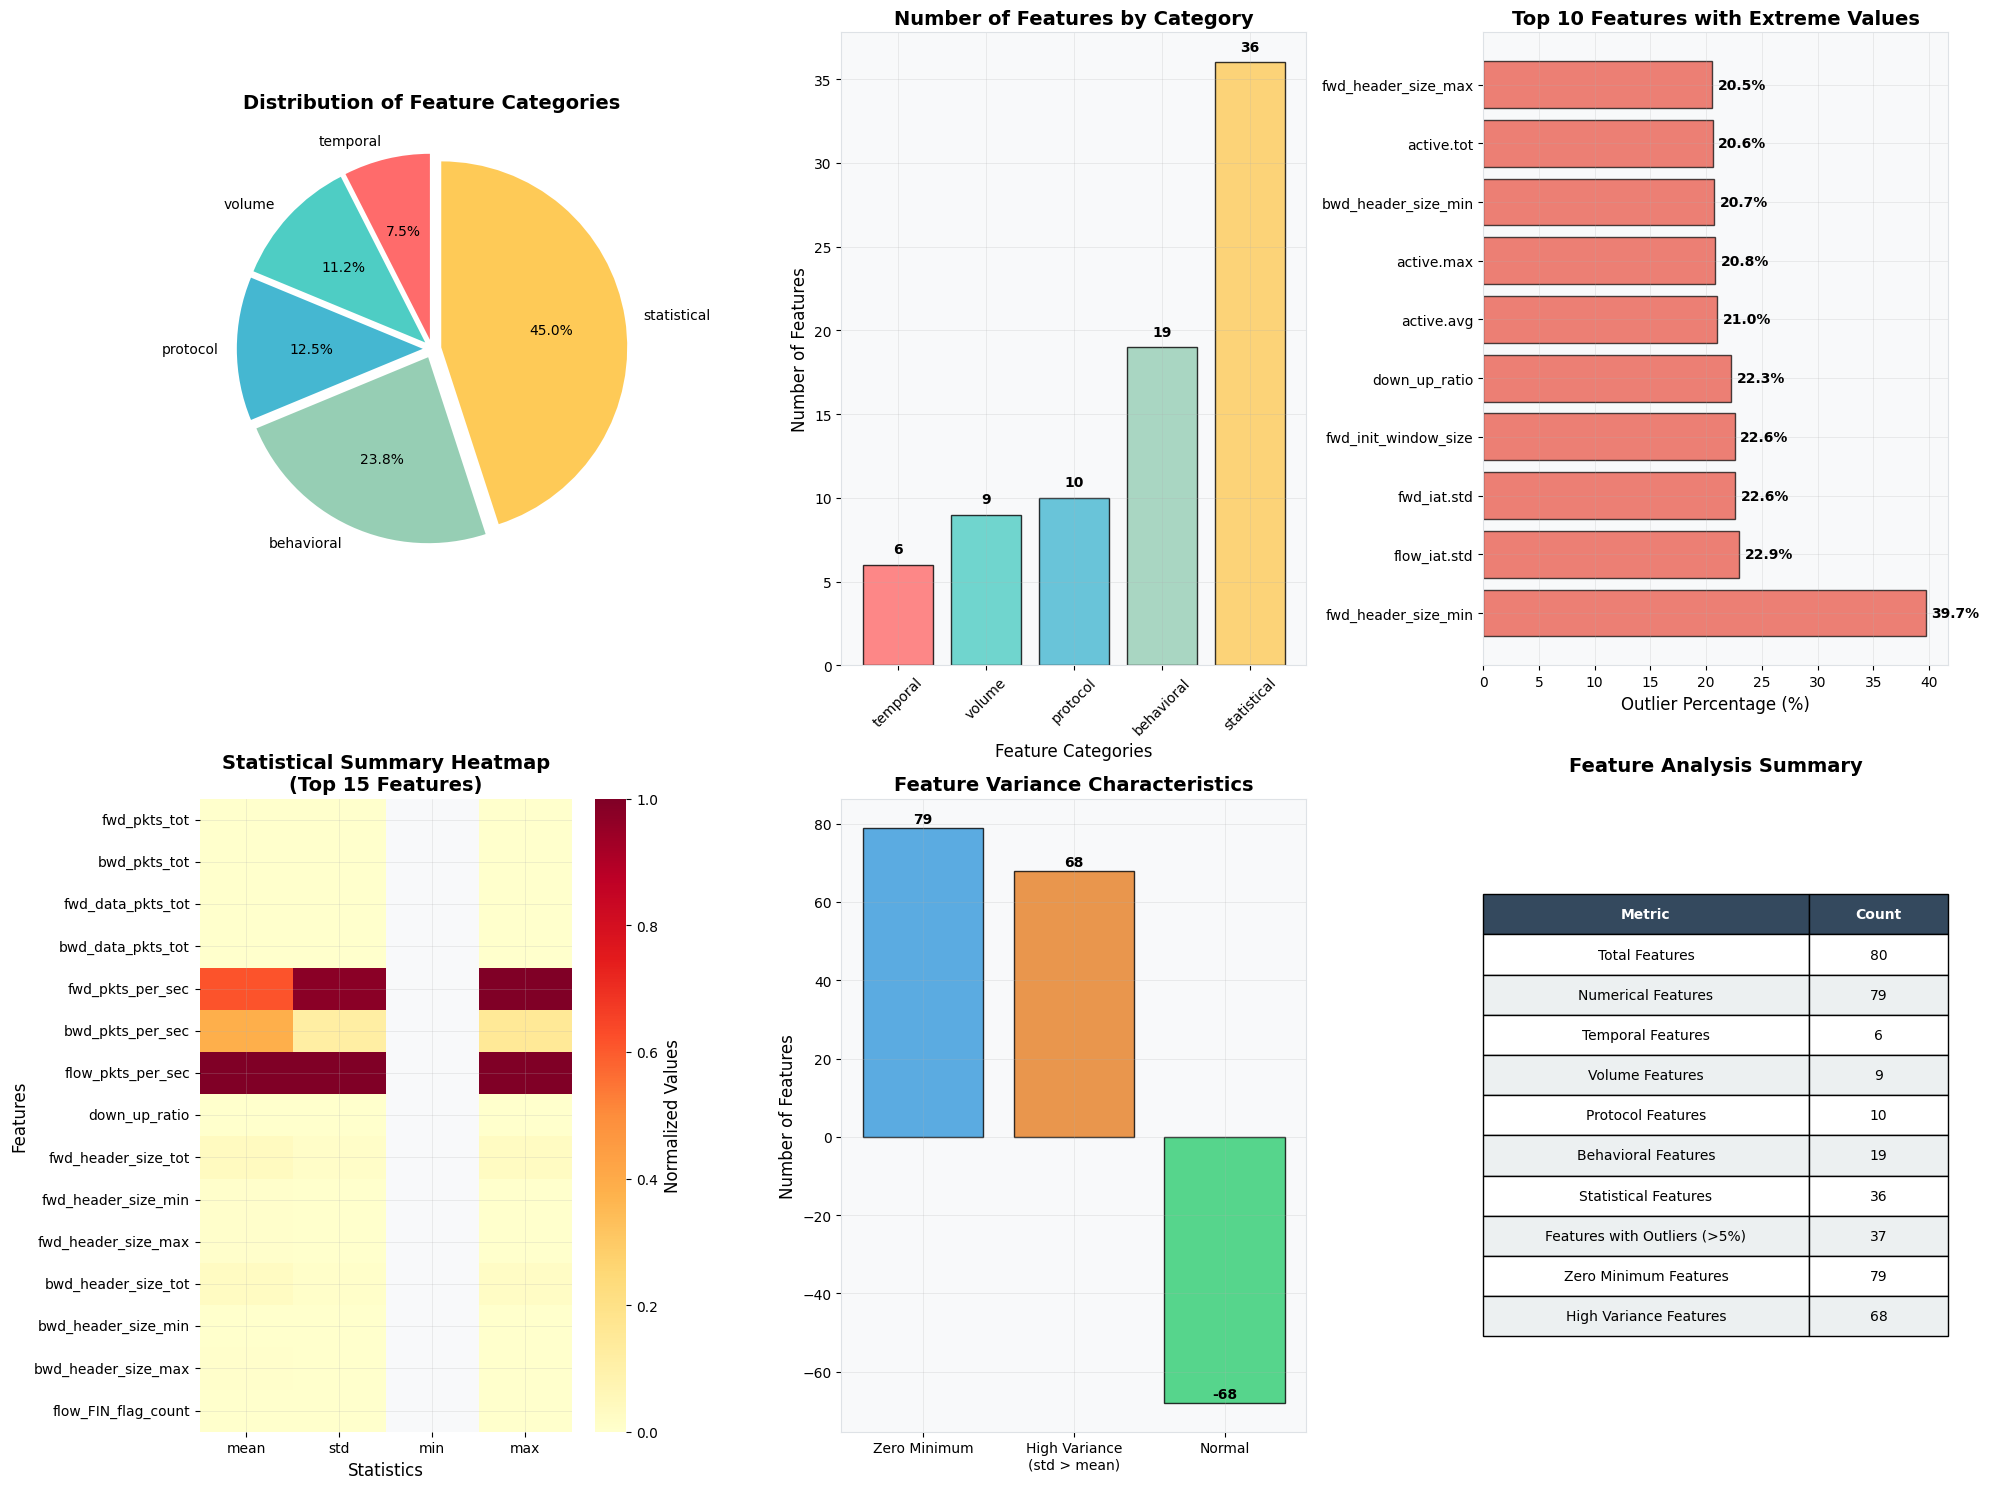

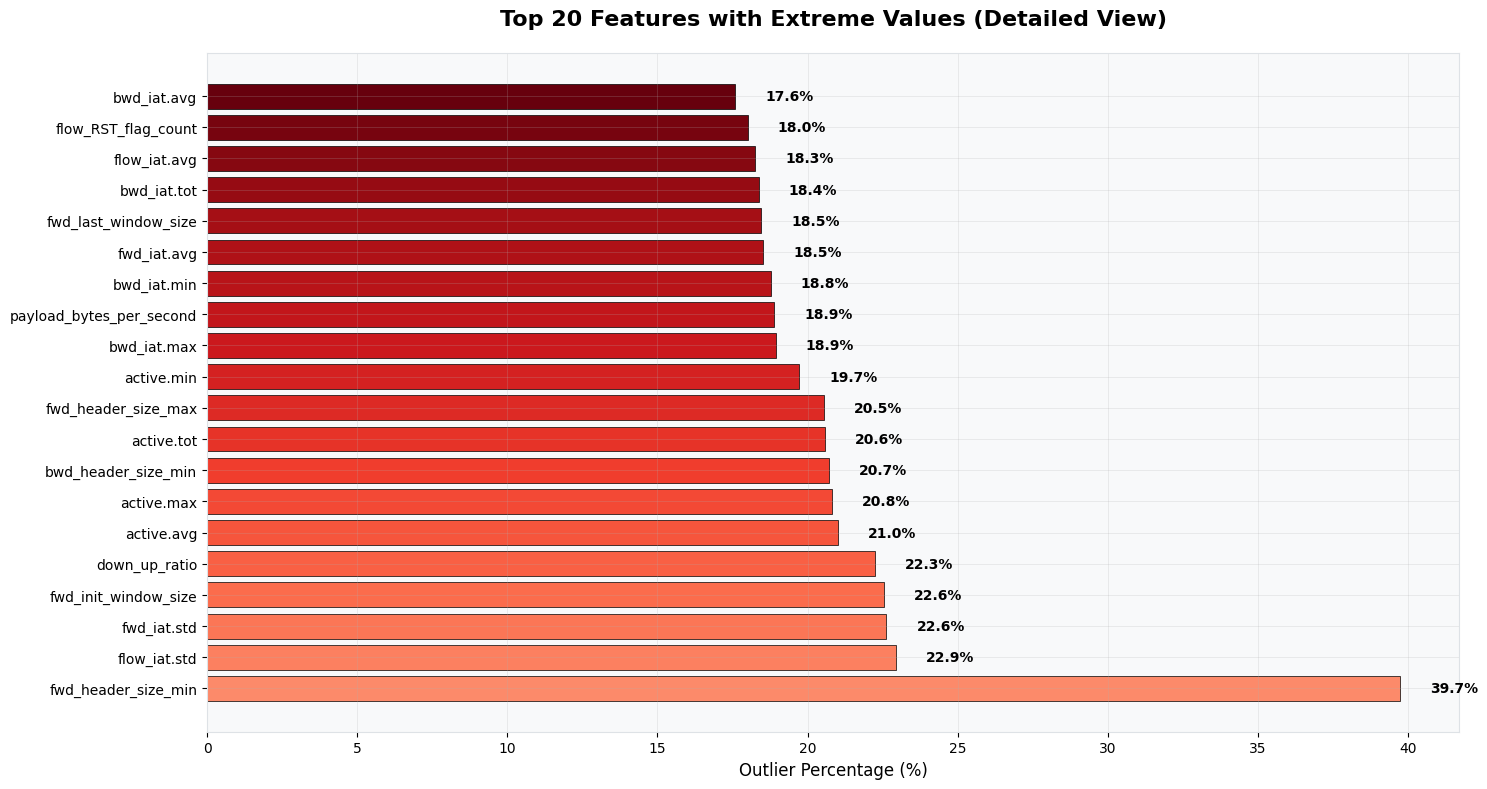

In [7]:
# =============================================================================
# SECTION 3.1: COMPREHENSIVE FEATURE ANALYSIS | VISUALIZATIONS
# =============================================================================


def visualize_feature_analysis(df, feature_categories, numerical_features, extreme_features, random_state=RANDOM_SEED):
    print("\n" + "="*60)
    print("SECTION 3.1: COMPREHENSIVE FEATURE ANALYSIS | VISUALIZATIONS")
    print("="*60)

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))

    # Feature Categories Distribution (Pie Chart)
    ax1 = plt.subplot(2, 3, 1)
    category_counts = {cat: len(features) for cat, features in feature_categories.items()}
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

    wedges, texts, autotexts = ax1.pie(category_counts.values(),
                                       labels=category_counts.keys(),
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90,
                                       explode=(0.05, 0.05, 0.05, 0.05, 0.05))
    ax1.set_title('Distribution of Feature Categories', fontsize=14, fontweight='bold')

    # Feature Categories Bar Chart
    ax2 = plt.subplot(2, 3, 2)
    bars = ax2.bar(category_counts.keys(), category_counts.values(),
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_title('Number of Features by Category', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Features')
    ax2.set_xlabel('Feature Categories')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Top 10 Features with Extreme Values
    ax3 = plt.subplot(2, 3, 3)
    if extreme_features:
        top_extreme = extreme_features[:10]
        feature_names = [f[0][:20] + '...' if len(f[0]) > 20 else f[0] for f in top_extreme]
        outlier_percentages = [f[1] for f in top_extreme]

        bars = ax3.barh(range(len(feature_names)), outlier_percentages,
                        color='#E74C3C', alpha=0.7, edgecolor='black')
        ax3.set_yticks(range(len(feature_names)))
        ax3.set_yticklabels(feature_names, fontsize=10)
        ax3.set_xlabel('Outlier Percentage (%)')
        ax3.set_title('Top 10 Features with Extreme Values', fontsize=14, fontweight='bold')
        ax3.grid(axis='x', alpha=0.3)

        # Add percentage labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax3.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center', fontweight='bold')

    # Statistical Summary Heatmap
    ax4 = plt.subplot(2, 3, 4)
    # Select a subset of numerical features for better visualization
    selected_features = numerical_features[:15] if len(numerical_features) > 15 else numerical_features
    stats_data = df[selected_features].describe().T

    # Create heatmap of key statistics
    stats_subset = stats_data[['mean', 'std', 'min', 'max']].copy()
    # Normalize for better visualization
    stats_normalized = (stats_subset - stats_subset.min()) / (stats_subset.max() - stats_subset.min())

    sns.heatmap(stats_normalized, annot=False, cmap='YlOrRd',
                cbar_kws={'label': 'Normalized Values'}, ax=ax4)
    ax4.set_title('Statistical Summary Heatmap\n(Top 15 Features)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Statistics')
    ax4.set_ylabel('Features')

    # Feature Variance Analysis
    ax5 = plt.subplot(2, 3, 5)
    feature_stats = df[numerical_features].describe()
    zero_min_count = (feature_stats.loc['min'] == 0).sum()
    high_variance_count = (feature_stats.loc['std'] > feature_stats.loc['mean']).sum()
    normal_features = len(numerical_features) - zero_min_count - high_variance_count

    categories = ['Zero Minimum', 'High Variance\n(std > mean)', 'Normal']
    counts = [zero_min_count, high_variance_count, normal_features]
    colors_var = ['#3498DB', '#E67E22', '#2ECC71']

    bars = ax5.bar(categories, counts, color=colors_var, alpha=0.8, edgecolor='black')
    ax5.set_title('Feature Variance Characteristics', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Number of Features')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Summary Statistics Table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('tight')
    ax6.axis('off')

    # Create summary table
    summary_data = [
        ['Total Features', len(df.columns) - len(['Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp', 'Label', 'attack_category'])],
        ['Numerical Features', len(numerical_features)],
        ['Temporal Features', len(feature_categories.get('temporal', []))],
        ['Volume Features', len(feature_categories.get('volume', []))],
        ['Protocol Features', len(feature_categories.get('protocol', []))],
        ['Behavioral Features', len(feature_categories.get('behavioral', []))],
        ['Statistical Features', len(feature_categories.get('statistical', []))],
        ['Features with Outliers (>5%)', len(extreme_features)],
        ['Zero Minimum Features', zero_min_count],
        ['High Variance Features', high_variance_count]
    ]

    table = ax6.table(cellText=summary_data,
                      colLabels=['Metric', 'Count'],
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.7, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style the table
    for i in range(len(summary_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ECF0F1' if i % 2 == 0 else 'white')

    ax6.set_title('Feature Analysis Summary', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    # Additional detailed visualization for extreme features
    if extreme_features:
        plt.figure(figsize=(15, 8))

        # Create a more detailed view of extreme features
        top_20_extreme = extreme_features[:20]
        feature_names = [f[0] for f in top_20_extreme]
        outlier_percentages = [f[1] for f in top_20_extreme]

        # Create color gradient based on outlier percentage
        colors_gradient = plt.cm.Reds(np.linspace(0.4, 1, len(feature_names)))

        bars = plt.barh(range(len(feature_names)), outlier_percentages,
                       color=colors_gradient, edgecolor='black', linewidth=0.5)

        plt.yticks(range(len(feature_names)),
                  [name[:30] + '...' if len(name) > 30 else name for name in feature_names])
        plt.xlabel('Outlier Percentage (%)', fontsize=12)
        plt.title('Top 20 Features with Extreme Values (Detailed View)',
                 fontsize=16, fontweight='bold', pad=20)
        plt.grid(axis='x', alpha=0.3)

        # Add percentage labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

# ==========================================================
# EXECUTION
# ==========================================================

# Run Visualizations:
visualize_feature_analysis(df, feature_cats, numerical_cols, extreme_vals, random_state=RANDOM_SEED)


# Feature Categorization Table

| Feature | Category | Description |
|---------|----------|-------------|
| Unnamed: 0 | ID Column | Index column, usually created during CSV export. Not a real feature. |
| uid | ID Column | Unique identifier for each flow/session. |
| originh | ID Column | Source IP address (origin host). |
| originp | ID Column | Source port (origin port). |
| responh | ID Column | Destination IP address (responding host). |
| responp | ID Column | Destination port (responding port). |
| flow_duration | Temporal | Total duration of the flow/session (usually in microseconds or milliseconds). |
| fwd_pkts_tot | Volume | Total number of packets sent from source to destination (forward direction). |
| bwd_pkts_tot | Volume | Total number of packets sent from destination to source (backward direction). |
| fwd_data_pkts_tot | Volume | Number of data (non-control) packets in forward direction. |
| bwd_data_pkts_tot | Volume | Number of data (non-control) packets in backward direction. |
| fwd_pkts_per_sec | Behavioral | Rate of forward packets per second. |
| bwd_pkts_per_sec | Behavioral | Rate of backward packets per second. |
| flow_pkts_per_sec | Behavioral | Total packet rate (both directions) per second. |
| down_up_ratio | Behavioral | Ratio of packets/bytes from destination to source vs. source to destination. |
| fwd_header_size_tot | Volume | Total size of headers in forward packets. |
| fwd_header_size_min | Statistical | Minimum header size in forward packets. |
| fwd_header_size_max | Statistical | Maximum header size in forward packets. |
| bwd_header_size_tot | Volume | Total size of headers in backward packets. |
| bwd_header_size_min | Statistical | Minimum header size in backward packets. |
| bwd_header_size_max | Statistical | Maximum header size in backward packets. |
| flow_FIN_flag_count | Protocol | Number of FIN flags (TCP connection finish) in the flow. |
| flow_SYN_flag_count | Protocol | Number of SYN flags (TCP connection start) in the flow. |
| flow_RST_flag_count | Protocol | Number of RST flags (TCP connection reset) in the flow. |
| fwd_PSH_flag_count | Protocol | Number of PSH flags in forward direction (push function). |
| bwd_PSH_flag_count | Protocol | Number of PSH flags in backward direction. |
| flow_ACK_flag_count | Protocol | Number of ACK flags (acknowledgment) in the flow. |
| fwd_URG_flag_count | Protocol | Number of URG flags in forward direction (urgent pointer field significant). |
| bwd_URG_flag_count | Protocol | Number of URG flags in backward direction. |
| flow_CWR_flag_count | Protocol | Number of CWR flags (congestion window reduced) in the flow. |
| flow_ECE_flag_count | Protocol | Number of ECE flags (ECN-Echo) in the flow. |
| fwd_pkts_payload.min | Statistical | Minimum payload size in forward packets. |
| fwd_pkts_payload.max | Statistical | Maximum payload size in forward packets. |
| fwd_pkts_payload.tot | Volume | Total payload size in forward packets. |
| fwd_pkts_payload.avg | Statistical | Average payload size in forward packets. |
| fwd_pkts_payload.std | Statistical | Standard deviation of payload size in forward packets. |
| bwd_pkts_payload.min | Statistical | Minimum payload size in backward packets. |
| bwd_pkts_payload.max | Statistical | Maximum payload size in backward packets. |
| bwd_pkts_payload.tot | Volume | Total payload size in backward packets. |
| bwd_pkts_payload.avg | Statistical | Average payload size in backward packets. |
| bwd_pkts_payload.std | Statistical | Standard deviation of payload size in backward packets. |
| flow_pkts_payload.min | Statistical | Minimum payload size in all packets in the flow. |
| flow_pkts_payload.max | Statistical | Maximum payload size in all packets in the flow. |
| flow_pkts_payload.tot | Volume | Total payload size in all packets in the flow. |
| flow_pkts_payload.avg | Statistical | Average payload size in all packets in the flow. |
| flow_pkts_payload.std | Statistical | Standard deviation of payload size in all packets in the flow. |
| fwd_iat.min | Statistical | Minimum time between forward packets. |
| fwd_iat.max | Statistical | Maximum time between forward packets. |
| fwd_iat.tot | Temporal | Total time between forward packets. |
| fwd_iat.avg | Statistical | Average time between forward packets. |
| fwd_iat.std | Statistical | Standard deviation of time between forward packets. |
| bwd_iat.min | Statistical | Minimum time between backward packets. |
| bwd_iat.max | Statistical | Maximum time between backward packets. |
| bwd_iat.tot | Temporal | Total time between backward packets. |
| bwd_iat.avg | Statistical | Average time between backward packets. |
| bwd_iat.std | Statistical | Standard deviation of time between backward packets. |
| flow_iat.min | Statistical | Minimum time between all packets in the flow. |
| flow_iat.max | Statistical | Maximum time between all packets in the flow. |
| flow_iat.tot | Temporal | Total time between all packets in the flow. |
| flow_iat.avg | Statistical | Average time between all packets in the flow. |
| flow_iat.std | Statistical | Standard deviation of time between all packets in the flow. |
| payload_bytes_per_second | Behavioral | Total payload bytes per second for the flow. |
| fwd_subflow_pkts | Behavioral | Number of packets in forward subflow (subflow = continuous packets). |
| bwd_subflow_pkts | Behavioral | Number of packets in backward subflow. |
| fwd_subflow_bytes | Behavioral | Number of bytes in forward subflow. |
| bwd_subflow_bytes | Behavioral | Number of bytes in backward subflow. |
| fwd_bulk_bytes | Behavioral | Bulk bytes sent in forward direction. |
| bwd_bulk_bytes | Behavioral | Bulk bytes sent in backward direction. |
| fwd_bulk_packets | Behavioral | Bulk packets sent in forward direction. |
| bwd_bulk_packets | Behavioral | Bulk packets sent in backward direction. |
| fwd_bulk_rate | Behavioral | Bulk transfer rate in forward direction. |
| bwd_bulk_rate | Behavioral | Bulk transfer rate in backward direction. |
| active.min | Statistical | Minimum active time (periods when packets are being sent). |
| active.max | Statistical | Maximum active time. |
| active.tot | Temporal | Total active time. |
| active.avg | Statistical | Average active time. |
| active.std | Statistical | Standard deviation of active times. |
| idle.min | Statistical | Minimum idle time (periods with no packets sent). |
| idle.max | Statistical | Maximum idle time. |
| idle.tot | Temporal | Total idle time. |
| idle.avg | Statistical | Average idle time. |
| idle.std | Statistical | Standard deviation of idle times. |
| fwd_init_window_size | Behavioral | Initial TCP window size in forward direction. |
| bwd_init_window_size | Behavioral | Initial TCP window size in backward direction. |
| fwd_last_window_size | Behavioral | Last observed TCP window size (forward). |
| bwd_last_window_size | Behavioral | Last observed TCP window size (backward). |
| attack_category | Label | Category/type of attack (e.g., DoS, PortScan, etc.), or 'Benign' for normal. |
| Label | Label | Binary label: 1 = attack/malicious, 0 = benign/normal. |

## Considerations
### Category Summary

- **ID Columns (6):** Unnamed: 0, uid, originh, originp, responh, responp
- **Temporal (6):** flow_duration, fwd_iat.tot, bwd_iat.tot, flow_iat.tot, active.tot, idle.tot
- **Volume (12):** Features containing 'pkts', 'bytes', 'payload', 'size' (totals)
- **Protocol (10):** All TCP flag-related features
- **Behavioral (16):** Features with 'ratio', 'rate', 'bulk', 'window', 'subflow'
- **Statistical (36):** Features with 'min', 'max', 'avg', 'std'
- **Labels (2):** attack_category, Label


# Section 4 - Advanced Statistical Analysis and Visualizations

### Goal:
- Correlation analysis
- Plot Correlation matrix for numerical features
- Distribuition Analysis
- Kruskal-Wallis analysis
    - The Kruskal-Wallis test is used when the assumptions for a one way analysis of variance are not met. Since the Kruskal-Wallis test is a nonparametric test the data used do not have to be normally distributed. The only requirement is that the data be ordinal scale.

In [8]:
# =============================================================================
# SECTION 4: ADVANCED STATISTICS
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def plot_correlation_matrix_enhanced(df, numerical_features, figsize=(24, 20)):
    """
    Enhanced correlation matrix visualization (KEPT AS IS)
    """
    print("\n" + "-"*60)
    print("ENHANCED CORRELATION MATRIX ANALYSIS")
    print("-"*60)

    available_features = [f for f in numerical_features if f in df.columns]

    # Adaptive sampling for large feature sets
    if len(available_features) > 50:
        sample_size = 50
        # Prioritize features with important keywords
        priority_features = [f for f in available_features if any(keyword in f.lower()
                           for keyword in ['flow', 'duration', 'byte', 'packet', 'time', 'iat'])]
        other_features = [f for f in available_features if f not in priority_features]

        if len(priority_features) >= sample_size:
            sample_features = np.random.choice(priority_features, sample_size, replace=False)
        else:
            remaining_slots = sample_size - len(priority_features)
            additional_features = np.random.choice(other_features,
                                                 min(remaining_slots, len(other_features)),
                                                 replace=False)
            sample_features = list(priority_features) + list(additional_features)

        print(f"Analyzing correlation for {len(sample_features)} features (sampled from {len(available_features)})")
    else:
        sample_features = available_features
        print(f"Analyzing correlation for all {len(sample_features)} features")

    # Calculate correlation matrix
    correlation_matrix = df[sample_features].corr()

    # Find highly correlated pairs with multiple thresholds
    correlation_analysis = {}
    thresholds = [0.95, 0.9, 0.8, 0.7]

    for threshold in thresholds:
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_value = correlation_matrix.iloc[i, j]
                if abs(corr_value) > threshold:
                    high_corr_pairs.append((correlation_matrix.columns[i],
                                          correlation_matrix.columns[j],
                                          corr_value))

        correlation_analysis[threshold] = sorted(high_corr_pairs,
                                               key=lambda x: abs(x[2]), reverse=True)

        if high_corr_pairs:
            print(f"\nHighly correlated pairs (|r| > {threshold}): {len(high_corr_pairs)}")
            for feat1, feat2, corr in high_corr_pairs[:5]:
                print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")

    # Create enhanced correlation heatmap
    plt.figure(figsize=figsize)

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Generate heatmap
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=len(sample_features) <= 20,  # Only annotate if manageable
                fmt='.2f',
                cmap='RdBu_r',
                center=0,
                square=True,
                linewidths=0.1,
                cbar_kws={"shrink": .8, "label": "Correlation Coefficient"})

    plt.title(f'Enhanced Correlation Matrix\n({len(sample_features)} features)',
              fontsize=18, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

    return correlation_matrix, correlation_analysis

def plot_all_features_distribution_readable(df, numerical_features, max_categories=5):
    """
    Apply histogram approach to ALL features - 2x2 layout with log scale
    """
    print("\n" + "-"*60)
    print("ALL FEATURES DISTRIBUTION ANALYSIS")
    print("-"*60)

    if 'attack_category' not in df.columns:
        print("Error: 'attack_category' column not found in dataframe")
        return

    # Use ALL numerical features
    available_features = [f for f in numerical_features if f in df.columns]

    if len(available_features) == 0:
        print("Warning: No numerical features found in dataset.")
        return

    n_features = len(available_features)
    n_pages = (n_features + 3) // 4  # 4 features per page

    print(f"Analyzing ALL {n_features} numerical features across {n_pages} page(s)")
    print(f"Using readable approach: 2x2 layout, 30 bins, density=True, log scale")

    top_attacks = df['attack_category'].value_counts().head(max_categories).index
    print(f"Top {len(top_attacks)} attack categories: {', '.join(top_attacks)}")

    # Define colors for each attack category
    colors = plt.cm.Set1(np.linspace(0, 1, len(top_attacks)))
    attack_colors = dict(zip(top_attacks, colors))

    for page_idx in range(n_pages):
        start_idx = page_idx * 4
        end_idx = min(start_idx + 4, n_features)
        current_features = available_features[start_idx:end_idx]

        if len(current_features) >= 4:
            fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        elif len(current_features) == 3:
            fig, axes = plt.subplots(2, 2, figsize=(18, 14))
            axes = axes.flatten()
        elif len(current_features) == 2:
            fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        else:
            fig, axes = plt.subplots(1, 1, figsize=(9, 7))
            axes = [axes]

        fig.suptitle(f'Feature Distributions by Attack Category - Page {page_idx + 1}/{n_pages}',
                     fontsize=18, fontweight='bold', y=0.98)

        if len(current_features) >= 4:
            axes = axes.flatten()
        elif len(current_features) == 2:
            pass  # axes is already correct

        for i, feature in enumerate(current_features):
            if len(current_features) >= 4:
                ax = axes[i]
            elif len(current_features) == 2:
                ax = axes[i]
            else:
                ax = axes[0]

            # Plot histogram for each attack category using the readable approach
            for attack in top_attacks:
                attack_data = df[df['attack_category'] == attack][feature].dropna()

                if len(attack_data) > 10:  # Minimum sample size
                    ax.hist(attack_data, alpha=0.6,
                           label=f'{attack} (n={len(attack_data):,})',
                           bins=30, density=True,  # Standard approach from suggestion
                           color=attack_colors[attack],
                           edgecolor='black', linewidth=0.3)

            # Enhanced formatting following the readable approach
            ax.set_title(f'{feature.replace("_", " ").replace(".", " ").title()} Distribution',
                        fontweight='bold', fontsize=14, pad=15)
            ax.set_xlabel(feature.replace('_', ' ').replace('.', ' ').title(),
                         fontsize=12, fontweight='bold')
            ax.set_ylabel('Density (Log Scale)', fontsize=12, fontweight='bold')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            ax.set_yscale('log')  # Log scale as in the suggestion
            ax.grid(True, linestyle='--', alpha=0.3)

            # Enhanced statistics box
            feature_data = df[feature].dropna()
            if len(feature_data) > 0:
                stats_text = f"Overall Stats:\nMean: {feature_data.mean():.2f}\nStd: {feature_data.std():.2f}\nMedian: {feature_data.median():.2f}"
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                       fontsize=9, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        # Hide unused subplots if less than 4 features
        if len(current_features) < 4 and len(current_features) >= 2:
            for i in range(len(current_features), 4):
                if i < len(axes):
                    axes[i].set_visible(False)

        plt.tight_layout(rect=[0, 0.02, 1, 0.96])
        plt.show()

        print(f"✓ Page {page_idx + 1} completed - Features: {', '.join(current_features)}")

def create_statistical_significance_table(df, numerical_features, max_categories=5):
    """
    Create and display statistical significance results as a table (KEPT AS IS)
    """
    print("\n" + "-"*60)
    print("STATISTICAL SIGNIFICANCE TABLE")
    print("-"*60)

    if 'attack_category' not in df.columns:
        print("Error: 'attack_category' column not found. Skipping statistical tests.")
        return pd.DataFrame()

    available_features = [f for f in numerical_features if f in df.columns]
    top_attacks = df['attack_category'].value_counts().head(max_categories).index

    significant_features = []

    print(f"Testing {len(available_features)} features for statistical significance...")
    print(f"Attack categories: {', '.join(top_attacks)}")

    for idx, feature in enumerate(available_features):
        if (idx + 1) % 50 == 0:  # Progress indicator
            print(f"  Processed {idx + 1}/{len(available_features)} features...")

        groups = [df[df['attack_category'] == attack][feature].dropna().values
                 for attack in top_attacks]
        groups = [group for group in groups if len(group) > 10]  # Minimum sample size

        if len(groups) >= 2:
            try:
                # Kruskal-Wallis test (non-parametric)
                statistic, p_value = stats.kruskal(*groups)

                # Calculate effect size (eta-squared approximation)
                total_n = sum(len(group) for group in groups)
                effect_size = (statistic - len(groups) + 1) / (total_n - len(groups))

                # Calculate additional statistics
                group_means = [np.mean(group) for group in groups]
                mean_range = max(group_means) - min(group_means)

                if p_value < 0.05:
                    # Determine effect magnitude
                    if effect_size > 0.14:
                        magnitude = "Large"
                    elif effect_size > 0.06:
                        magnitude = "Medium"
                    else:
                        magnitude = "Small"

                    significant_features.append({
                        'Feature': feature,
                        'H-statistic': round(statistic, 2),
                        'p-value': f"{p_value:.2e}",
                        'Effect Size': round(effect_size, 3),
                        'Mean Range': round(mean_range, 2),
                        'Magnitude': magnitude
                    })

            except Exception as e:
                continue

    # Sort by effect size (descending)
    significant_features.sort(key=lambda x: x['Effect Size'], reverse=True)

    # Create DataFrame
    sig_df = pd.DataFrame(significant_features)

    if len(sig_df) > 0:
        print(f"\nFound {len(sig_df)} statistically significant features")

        # Create and display table plot
        fig, ax = plt.subplots(figsize=(16, max(8, len(sig_df) * 0.3)))
        ax.axis('off')

        # Create table
        table_data = sig_df.values
        col_labels = sig_df.columns

        table = ax.table(cellText=table_data,
                        colLabels=col_labels,
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0, 1, 1])

        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)

        # Color code by magnitude
        for i in range(len(sig_df)):
            magnitude = sig_df.iloc[i]['Magnitude']
            if magnitude == 'Large':
                color = '#ffcccc'  # Light red
            elif magnitude == 'Medium':
                color = '#ffffcc'  # Light yellow
            else:
                color = '#ccffcc'  # Light green

            for j in range(len(col_labels)):
                table[(i+1, j)].set_facecolor(color)

        # Header formatting
        for j in range(len(col_labels)):
            table[(0, j)].set_facecolor('#cccccc')
            table[(0, j)].set_text_props(weight='bold')

        plt.title('Statistically Significant Features (p < 0.05)\nColor: Red=Large Effect, Yellow=Medium Effect, Green=Small Effect',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # Summary statistics
        print(f"\nSUMMARY:")
        print(f"Large Effect (η² > 0.14): {len(sig_df[sig_df['Magnitude'] == 'Large'])} features")
        print(f"Medium Effect (0.06 < η² ≤ 0.14): {len(sig_df[sig_df['Magnitude'] == 'Medium'])} features")
        print(f"Small Effect (η² ≤ 0.06): {len(sig_df[sig_df['Magnitude'] == 'Small'])} features")

    else:
        print("No statistically significant features found")

    return sig_df

def all_features_readable_analysis(df, feature_categories, numerical_features,
                                 random_state=42):
    """
    Analysis for ALL features using the readable histogram approach
    """
    print("\n" + "="*80)
    print("ALL FEATURES ANALYSIS: HISTOGRAM APPROACH")
    print("="*80)

    # Correlation Matrix Analysis
    corr_matrix, corr_analysis = plot_correlation_matrix_enhanced(df, numerical_features)

    # Features Distribution
    plot_all_features_distribution_readable(df, numerical_features)

    #Statistical Significance Table
    sig_features_df = create_statistical_significance_table(df, numerical_features)

    return corr_matrix, corr_analysis, sig_features_df

# ==========================================================
# MAIN EXECUTION FUNCTION
# ==========================================================

def run_all_features_readable_analysis(df, feature_categories=None, numerical_features=None):
    """
    Run analysis for ALL features using the readable histogram approach
    """
    if numerical_features is None:
        numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
        if 'attack_category' in numerical_features:
            numerical_features.remove('attack_category')

    if feature_categories is None:
        feature_categories = {
            'flow_features': [col for col in numerical_features if 'flow' in col.lower()],
            'packet_features': [col for col in numerical_features if any(x in col.lower() for x in ['pkt', 'packet'])],
            'timing_features': [col for col in numerical_features if any(x in col.lower() for x in ['time', 'iat', 'duration'])],
            'size_features': [col for col in numerical_features if any(x in col.lower() for x in ['byte', 'size', 'len'])]
        }


    print(f"Total features to analyze: {len(numerical_features)}")
    print(f"Estimated pages: {(len(numerical_features) + 3) // 4}")

    # Check for required column
    if 'attack_category' not in df.columns:
        print("\nWarning: 'attack_category' column not found.")
        print("   Attack category analysis will be skipped.")

    # Run all features readable analysis
    corr_matrix, corr_analysis, sig_features_df = all_features_readable_analysis(
        df, feature_categories, numerical_features
    )

    print(f"\nALL FEATURES ANALYSIS COMPLETED!")
    print(f"Analyzed all {len(numerical_features)} features")
    print(f"Statistical table: {len(sig_features_df) if not sig_features_df.empty else 0} significant features")

    return corr_matrix, corr_analysis, sig_features_df

# Example usage:
corr_matrix, corr_analysis, sig_features_df = run_all_features_readable_analysis(df, feature_cats, numerical_cols)


Output hidden; open in https://colab.research.google.com to view.

# Preparation for CTGAN and Synthetic Data Generation


# Section 5 - Data preparation and CTGAN

## Goal
- Split dataset in train and test on a ratio of 80-20 (Train-Test)
- Use the training dataset generate additional malicious data to balance the training dataset
- Run CTGAN by sdv (synthetic data vault) to generate tabular data
- Plot Results

In [9]:
# =============================================================================
# SECTION 5: DATA PREPARATION AND CTGAN WITH PCA ANALYSIS
# =============================================================================

# Configure plotting
plt.style.use('default')
pio.renderers.default = 'notebook'

print("\n" + "="*60)
print("SECTION 5: DATA PREPARATION AND CTGAN WITH PCA ANALYSIS")
print("="*60)

def create_pca_analysis_before_ctgan(data, title_prefix="", random_state=RANDOM_SEED):
    """
    Comprehensive PCA analysis before CTGAN generation
    """


    print(f"\n{'='*60}")
    print(f"PCA ANALYSIS: {title_prefix}")
    print(f"{'='*60}")

    # Get numerical columns only
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if 'Label' in numeric_cols:
        numeric_cols.remove('Label')

    numeric_data = data[numeric_cols].fillna(0)
    print(f"Analyzing {len(numeric_cols)} numerical features")
    print(f"Data shape: {numeric_data.shape}")

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(numeric_data)

    # Apply PCA with multiple components for comprehensive analysis
    n_components = min(10, len(numeric_cols))  # Max 10 components or number of features
    pca = PCA(n_components=n_components, random_state=random_state)
    data_pca = pca.fit_transform(data_scaled)

    # Create comprehensive PCA visualization
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)

    # Explained Variance Ratio
    ax1 = fig.add_subplot(gs[0, 0])
    components = range(1, len(pca.explained_variance_ratio_) + 1)
    ax1.bar(components, pca.explained_variance_ratio_, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'{title_prefix} - Explained Variance by Component')
    ax1.grid(True, alpha=0.3)

    # Add cumulative variance line
    ax1_twin = ax1.twinx()
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    ax1_twin.plot(components, cumulative_var, color='red', marker='o', linewidth=2)
    ax1_twin.set_ylabel('Cumulative Variance', color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')

    # PCA Scatter Plot (PC1 vs PC2)
    ax2 = fig.add_subplot(gs[0, 1])
    scatter = ax2.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.6, s=20, c='blue')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax2.set_title(f'{title_prefix} - PCA Scatter (PC1 vs PC2)')
    ax2.grid(True, alpha=0.3)

    # PCA Scatter Plot (PC1 vs PC3)
    if len(pca.explained_variance_ratio_) > 2:
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.scatter(data_pca[:, 0], data_pca[:, 2], alpha=0.6, s=20, c='green')
        ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax3.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
        ax3.set_title(f'{title_prefix} - PCA Scatter (PC1 vs PC3)')
        ax3.grid(True, alpha=0.3)

    # Cumulative Variance Percentage
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.plot(components, cumulative_var * 100, marker='o', linewidth=2, color='purple')
    ax4.set_xlabel('Number of Components')
    ax4.set_ylabel('Cumulative Explained Variance (%)')
    ax4.set_title(f'{title_prefix} - Cumulative Variance')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
    ax4.legend()

    # PC Distributions
    for i in range(min(4, len(pca.explained_variance_ratio_))):
        ax = fig.add_subplot(gs[1, i])
        ax.hist(data_pca[:, i], bins=30, alpha=0.7, color=f'C{i}', density=True)
        ax.set_xlabel(f'PC{i+1} Values')
        ax.set_ylabel('Density')
        ax.set_title(f'PC{i+1} Distribution\n({pca.explained_variance_ratio_[i]:.1%} variance)')
        ax.grid(True, alpha=0.3)

    # Feature Loadings Heatmap
    ax9 = fig.add_subplot(gs[2, :])
    n_features_show = min(15, len(numeric_cols))  # Show top 15 features
    loadings = pca.components_[:min(5, n_components), :n_features_show].T

    sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0,
                xticklabels=[f'PC{i+1}' for i in range(loadings.shape[1])],
                yticklabels=numeric_cols[:n_features_show], ax=ax9, fmt='.2f')
    ax9.set_title(f'{title_prefix} - Feature Loadings Heatmap', fontsize=14, fontweight='bold')
    ax9.set_xlabel('Principal Components')
    ax9.set_ylabel('Features')

    plt.tight_layout()
    plt.show()

    # Print PCA summary
    print(f"\nPCA SUMMARY - {title_prefix}")
    print(f"{'='*50}")
    print(f"Total components: {len(pca.explained_variance_ratio_)}")
    print(f"Components for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")
    print(f"First 2 components explain: {sum(pca.explained_variance_ratio_[:2]):.1%}")
    print(f"First 3 components explain: {sum(pca.explained_variance_ratio_[:3]):.1%}")

    return {
        'pca_model': pca,
        'scaler': scaler,
        'data_pca': data_pca,
        'numeric_columns': numeric_cols,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': cumulative_var
    }

def create_pca_before_after_comparison(original_data, synthetic_data, random_state=RANDOM_SEED):
    """
    Comprehensive PCA comparison between original and synthetic data
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from scipy import stats

    print(f"\n{'='*70}")
    print("PCA COMPARISON: ORIGINAL vs SYNTHETIC DATA")
    print(f"{'='*70}")

    # Get common numerical columns
    orig_numeric_cols = original_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    synth_numeric_cols = synthetic_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if 'Label' in orig_numeric_cols:
        orig_numeric_cols.remove('Label')
    if 'Label' in synth_numeric_cols:
        synth_numeric_cols.remove('Label')

    # Get common columns
    common_cols = list(set(orig_numeric_cols) & set(synth_numeric_cols))
    print(f"Comparing {len(common_cols)} common numerical features")

    # Prepare data
    orig_numeric = original_data[common_cols].fillna(0)
    synth_numeric = synthetic_data[common_cols].fillna(0)

    # Standardize data
    scaler = StandardScaler()
    orig_scaled = scaler.fit_transform(orig_numeric)
    synth_scaled = scaler.transform(synth_numeric)

    # Apply PCA
    pca = PCA(n_components=min(10, len(common_cols)), random_state=random_state)
    orig_pca = pca.fit_transform(orig_scaled)
    synth_pca = pca.transform(synth_scaled)

    # Create comprehensive comparison visualization
    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 0.8], hspace=0.4, wspace=0.3)

    # PCA Scatter Comparison (PC1 vs PC2)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.scatter(orig_pca[:, 0], orig_pca[:, 1], alpha=0.6, c='blue',
                label=f'Original (n={len(orig_pca)})', s=20)
    ax1.scatter(synth_pca[:, 0], synth_pca[:, 1], alpha=0.6, c='red',
                label=f'Synthetic (n={len(synth_pca)})', s=20)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.set_title('PCA Comparison: Original vs Synthetic (PC1 vs PC2)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Explained Variance Comparison
    ax2 = fig.add_subplot(gs[0, 2])
    components = range(1, len(pca.explained_variance_ratio_) + 1)
    ax2.bar(components, pca.explained_variance_ratio_, alpha=0.7, color='skyblue')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title('Explained Variance by Component')
    ax2.grid(True, alpha=0.3)

    # Cumulative Variance
    ax3 = fig.add_subplot(gs[0, 3])
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    ax3.plot(components, cumulative_var * 100, marker='o', linewidth=2, color='purple')
    ax3.set_xlabel('Number of Components')
    ax3.set_ylabel('Cumulative Explained Variance (%)')
    ax3.set_title('Cumulative Variance')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95%')
    ax3.legend()

    # PC Distribution Comparisons
    for i in range(min(4, orig_pca.shape[1])):
        ax = fig.add_subplot(gs[1, i])
        ax.hist(orig_pca[:, i], bins=30, alpha=0.7, color='blue',
                label='Original', density=True)
        ax.hist(synth_pca[:, i], bins=30, alpha=0.7, color='red',
                label='Synthetic', density=True)
        ax.set_xlabel(f'PC{i+1} Values')
        ax.set_ylabel('Density')
        ax.set_title(f'PC{i+1} Distribution Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Statistical Comparison Box Plots
    ax8 = fig.add_subplot(gs[2, :2])
    pc_data = []
    pc_labels = []
    colors = []

    for i in range(min(4, orig_pca.shape[1])):
        pc_data.extend([orig_pca[:, i], synth_pca[:, i]])
        pc_labels.extend([f'PC{i+1}\nOriginal', f'PC{i+1}\nSynthetic'])
        colors.extend(['lightblue', 'lightcoral'])

    box_plot = ax8.boxplot(pc_data, labels=pc_labels, patch_artist=True)
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)

    ax8.set_title('PC Values Distribution - Box Plot Comparison')
    ax8.set_ylabel('PC Values')
    ax8.grid(True, alpha=0.3)
    plt.setp(ax8.get_xticklabels(), rotation=45)

    # Feature Loadings Heatmap
    ax9 = fig.add_subplot(gs[2, 2:])
    n_features_show = min(12, len(common_cols))
    loadings = pca.components_[:min(4, pca.n_components_), :n_features_show].T

    sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0,
                xticklabels=[f'PC{i+1}' for i in range(loadings.shape[1])],
                yticklabels=common_cols[:n_features_show], ax=ax9, fmt='.2f')
    ax9.set_title('Feature Loadings for Principal Components')
    ax9.set_xlabel('Principal Components')
    ax9.set_ylabel('Features')

    # Statistical Summary Table
    ax10 = fig.add_subplot(gs[3, :])
    ax10.axis('off')

    # Calculate statistical comparisons
    stats_data = []
    for i in range(min(4, orig_pca.shape[1])):
        orig_mean = np.mean(orig_pca[:, i])
        synth_mean = np.mean(synth_pca[:, i])
        orig_std = np.std(orig_pca[:, i])
        synth_std = np.std(synth_pca[:, i])

        ks_stat, ks_pvalue = stats.ks_2samp(orig_pca[:, i], synth_pca[:, i])

        mean_diff = abs(orig_mean - synth_mean)
        std_diff = abs(orig_std - synth_std)

        stats_data.append([
            f'PC{i+1}',
            f'{orig_mean:.3f}',
            f'{synth_mean:.3f}',
            f'{mean_diff:.3f}',
            f'{orig_std:.3f}',
            f'{synth_std:.3f}',
            f'{std_diff:.3f}',
            f'{ks_stat:.3f}',
            f'{ks_pvalue:.3f}'
        ])

    headers = ['PC', 'Orig Mean', 'Synth Mean', 'Mean Δ',
               'Orig Std', 'Synth Std', 'Std Δ', 'KS Stat', 'KS p-val']

    table = ax10.table(cellText=stats_data, colLabels=headers, cellLoc='center',
                      loc='center', colWidths=[0.08, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.12])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style the table
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color code based on statistical significance
    for i in range(1, len(stats_data) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f8f9fa')

            # Highlight significant KS test results
            if j == 8:  # KS p-value column
                try:
                    p_val = float(stats_data[i-1][j])
                    if p_val < 0.05:
                        table[(i, j)].set_facecolor('#ffebee')
                except:
                    pass

    ax10.set_title('PCA Statistical Comparison Summary', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    # Calculate overall quality score
    pc1_ks = stats.ks_2samp(orig_pca[:, 0], synth_pca[:, 0])[0]
    pc2_ks = stats.ks_2samp(orig_pca[:, 1], synth_pca[:, 1])[0]
    quality_score = 1 - np.mean([pc1_ks, pc2_ks])

    print(f"\nPCA QUALITY ASSESSMENT")
    print(f"{'='*50}")
    print(f"Overall PCA Similarity Score: {quality_score:.3f}")
    print(f"Quality Assessment: {get_quality_assessment(quality_score)}")
    print(f"PC1 KS-Statistic: {pc1_ks:.3f}")
    print(f"PC2 KS-Statistic: {pc2_ks:.3f}")

    return {
        'pca_model': pca,
        'original_pca': orig_pca,
        'synthetic_pca': synth_pca,
        'quality_score': quality_score,
        'common_columns': common_cols
    }

def get_quality_assessment(score):
    """Provide qualitative assessment of PCA similarity"""
    if score >= 0.9:
        return "Excellent similarity"
    elif score >= 0.8:
        return "Good similarity"
    elif score >= 0.7:
        return "Moderate similarity"
    elif score >= 0.6:
        return "Fair similarity"
    else:
        return "Poor similarity"

def create_table_evaluator_visualizations(real_df, synth_df, random_stat=RANDOM_SEED):
    """
    Replicate all key visualizations from table_evaluator library
    """
    # Get numerical and categorical columns
    numeric_cols = real_df.select_dtypes(['number']).columns.tolist()
    if 'Label' in numeric_cols:
        numeric_cols.remove('Label')

    categorical_cols = real_df.select_dtypes(['object', 'category']).columns.tolist()
    if 'Label' in categorical_cols:
        categorical_cols.remove('Label')

    # Create comprehensive visualization dashboard
    fig = plt.figure(figsize=(20, 24))

    # Distribution Comparison Plots
    n_numeric = len(numeric_cols)
    if n_numeric > 0:
        rows_dist = (n_numeric + 2) // 3
        for i, col in enumerate(numeric_cols[:9]):  # Limit to first 9 for space
            ax = plt.subplot(6, 3, i + 1)

            # Plot histograms
            ax.hist(real_df[col].dropna(), bins=30, alpha=0.7, label='Real',
                   color='blue', density=True)
            ax.hist(synth_df[col].dropna(), bins=30, alpha=0.7, label='Synthetic',
                   color='red', density=True)
            ax.set_title(f'Distribution: {col}')
            ax.legend()
            ax.grid(True, alpha=0.3)

    # Cumulative Distribution Functions (CDF)
    for i, col in enumerate(numeric_cols[:6]):  # First 6 numeric columns
        ax = plt.subplot(6, 3, 10 + i)

        # Calculate CDFs
        real_sorted = np.sort(real_df[col].dropna())
        synth_sorted = np.sort(synth_df[col].dropna())

        real_cdf = np.arange(1, len(real_sorted) + 1) / len(real_sorted)
        synth_cdf = np.arange(1, len(synth_sorted) + 1) / len(synth_sorted)

        ax.plot(real_sorted, real_cdf, label='Real', color='blue', linewidth=2)
        ax.plot(synth_sorted, synth_cdf, label='Synthetic', color='red', linewidth=2)
        ax.set_title(f'CDF: {col}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Mean and Standard Deviation Comparison
    ax_mean_std = plt.subplot(6, 3, 16)

    means_real = [real_df[col].mean() for col in numeric_cols]
    means_synth = [synth_df[col].mean() for col in numeric_cols]
    stds_real = [real_df[col].std() for col in numeric_cols]
    stds_synth = [synth_df[col].std() for col in numeric_cols]

    x_pos = np.arange(len(numeric_cols))
    width = 0.35

    ax_mean_std.bar(x_pos - width/2, means_real, width, label='Real Mean', alpha=0.7)
    ax_mean_std.bar(x_pos + width/2, means_synth, width, label='Synthetic Mean', alpha=0.7)
    ax_mean_std.set_title('Mean Comparison')
    ax_mean_std.set_xticks(x_pos)
    ax_mean_std.set_xticklabels(numeric_cols, rotation=45)
    ax_mean_std.legend()

    # Correlation Matrix Comparison
    ax_corr_real = plt.subplot(6, 3, 17)
    ax_corr_synth = plt.subplot(6, 3, 18)

    # Calculate correlation matrices
    corr_real = real_df[numeric_cols].corr()
    corr_synth = synth_df[numeric_cols].corr()

    # Plot correlation heatmaps
    sns.heatmap(corr_real, ax=ax_corr_real, cmap='coolwarm', center=0,
                square=True, cbar_kws={'shrink': 0.8})
    ax_corr_real.set_title('Real Data Correlations')

    sns.heatmap(corr_synth, ax=ax_corr_synth, cmap='coolwarm', center=0,
                square=True, cbar_kws={'shrink': 0.8})
    ax_corr_synth.set_title('Synthetic Data Correlations')

    plt.tight_layout()
    plt.show()

    # PCA Comparison (separate figure)
    create_pca_comparison(real_df[numeric_cols], synth_df[numeric_cols])

    # Statistical Summary Table
    create_statistical_summary_table(real_df, synth_df, numeric_cols)

    # Categorical Variables Comparison
    if categorical_cols:
        create_categorical_comparison(real_df, synth_df, categorical_cols)

def create_pca_comparison(real_numeric, synth_numeric, random_state=RANDOM_SEED):
    """Create PCA comparison visualization"""
    # Standardize the data
    scaler = StandardScaler()

    # Fit scaler on real data and transform both
    real_scaled = scaler.fit_transform(real_numeric.fillna(0))
    synth_scaled = scaler.transform(synth_numeric.fillna(0))

    # Perform PCA
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_scaled)
    synth_pca = pca.transform(synth_scaled)

    # Create PCA plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # PCA scatter plot
    axes[0].scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.6, label='Real', s=20)
    axes[0].scatter(synth_pca[:, 0], synth_pca[:, 1], alpha=0.6, label='Synthetic', s=20)
    axes[0].set_title('PCA Comparison')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # PCA component 1 distribution
    axes[1].hist(real_pca[:, 0], bins=30, alpha=0.7, label='Real PC1', density=True)
    axes[1].hist(synth_pca[:, 0], bins=30, alpha=0.7, label='Synthetic PC1', density=True)
    axes[1].set_title('PC1 Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # PCA component 2 distribution
    axes[2].hist(real_pca[:, 1], bins=30, alpha=0.7, label='Real PC2', density=True)
    axes[2].hist(synth_pca[:, 1], bins=30, alpha=0.7, label='Synthetic PC2', density=True)
    axes[2].set_title('PC2 Distribution')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_statistical_summary_table(real_df, synth_df, numeric_cols, random_state=RANDOM_SEED):
    """Create comprehensive statistical comparison table"""
    stats_data = []

    for col in numeric_cols:
        real_col = real_df[col].dropna()
        synth_col = synth_df[col].dropna()

        # Calculate statistics
        real_mean = real_col.mean()
        synth_mean = synth_col.mean()
        real_std = real_col.std()
        synth_std = synth_col.std()
        real_median = real_col.median()
        synth_median = synth_col.median()

        # Calculate statistical tests
        ks_stat, ks_pvalue = stats.ks_2samp(real_col, synth_col)

        # Calculate percentage differences
        mean_diff = ((synth_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0
        std_diff = ((synth_std - real_std) / real_std * 100) if real_std != 0 else 0
        median_diff = ((synth_median - real_median) / real_median * 100) if real_median != 0 else 0

        stats_data.append([
            col,
            f'{real_mean:.3f}',
            f'{synth_mean:.3f}',
            f'{mean_diff:+.1f}%',
            f'{real_std:.3f}',
            f'{synth_std:.3f}',
            f'{std_diff:+.1f}%',
            f'{ks_stat:.3f}',
            f'{ks_pvalue:.3f}'
        ])

    # Create table visualization
    fig, ax = plt.subplots(figsize=(16, max(6, len(stats_data) * 0.5)))
    ax.axis('off')

    headers = ['Feature', 'Real Mean', 'Synth Mean', 'Mean Δ%',
               'Real Std', 'Synth Std', 'Std Δ%', 'KS Stat', 'KS p-value']

    table = ax.table(cellText=stats_data, colLabels=headers, cellLoc='center',
                    loc='center', colWidths=[0.12] * len(headers))

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)

    # Style the table
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color code based on statistical significance
    for i in range(1, len(stats_data) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f8f9fa')

            # Highlight significant KS test results
            if j == 8:  # KS p-value column
                try:
                    p_val = float(stats_data[i-1][j])
                    if p_val < 0.05:
                        table[(i, j)].set_facecolor('#ffebee')  # Light red for significant
                except:
                    pass

    ax.set_title('Statistical Comparison Summary', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def create_categorical_comparison(real_df, synth_df, categorical_cols, random_state=RANDOM_SEED):
    """Create categorical variables comparison"""
    n_cats = len(categorical_cols)
    if n_cats == 0:
        return

    fig, axes = plt.subplots((n_cats + 1) // 2, 2, figsize=(15, 4 * ((n_cats + 1) // 2)))
    if n_cats == 1:
        axes = [axes]
    elif (n_cats + 1) // 2 == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        if i >= len(axes):
            break

        # Get value counts
        real_counts = real_df[col].value_counts()
        synth_counts = synth_df[col].value_counts()

        # Align categories
        all_categories = list(set(real_counts.index) | set(synth_counts.index))
        real_aligned = [real_counts.get(cat, 0) for cat in all_categories]
        synth_aligned = [synth_counts.get(cat, 0) for cat in all_categories]

        # Convert to proportions
        real_props = np.array(real_aligned) / sum(real_aligned)
        synth_props = np.array(synth_aligned) / sum(synth_aligned)

        # Create bar plot
        x_pos = np.arange(len(all_categories))
        width = 0.35

        axes[i].bar(x_pos - width/2, real_props, width, label='Real', alpha=0.7)
        axes[i].bar(x_pos + width/2, synth_props, width, label='Synthetic', alpha=0.7)
        axes[i].set_title(f'Category Distribution: {col}')
        axes[i].set_xticks(x_pos)
        axes[i].set_xticklabels(all_categories, rotation=45)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for j in range(len(categorical_cols), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

def create_cumsum_comparison_view(real_df, synth_df, random_state=RANDOM_SEED):
    """
    Plot cumulative sums with BOTH axes expressed as percentages.
    """
    numeric_cols = real_df.select_dtypes('number').columns.tolist()
    if 'Label' in numeric_cols:
        numeric_cols.remove('Label')

    # layout
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes_flat = axes if n_rows == 1 else axes.flatten()

    cumsum_dict = {}

    for i, col in enumerate(numeric_cols):
        # cumulative sums
        real_sorted  = real_df[col].sort_values(ignore_index=True)
        synth_sorted = synth_df[col].sort_values(ignore_index=True)

        real_cum  = real_sorted.cumsum()
        synth_cum = synth_sorted.cumsum()

        # convert Y to % of total
        real_pct  = real_cum  / real_cum.iloc[-1]  * 100
        synth_pct = synth_cum / synth_cum.iloc[-1] * 100

        # X-axis as % of records
        real_x_pct  = np.arange(1, len(real_pct)  + 1) / len(real_pct)  * 100
        synth_x_pct = np.arange(1, len(synth_pct) + 1) / len(synth_pct) * 100

        cumsum_dict[col] = {'real_x_pct': real_x_pct,
                            'real_y_pct': real_pct,
                            'synth_x_pct': synth_x_pct,
                            'synth_y_pct': synth_pct}

        ax = axes_flat[i]
        ax.plot(real_x_pct,  real_pct,  label='Real',      color='blue', linewidth=2)
        ax.plot(synth_x_pct, synth_pct, label='Synthetic', color='red',  linewidth=2, alpha=0.8)

        ax.set_title(f'Cumulative Sum (% vs %): {col}', fontweight='bold')
        ax.set_xlabel('Percentage of records (%)')
        ax.set_ylabel('Cumulative value (%)')
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.3)
        ax.legend()

        # stats box (totals still in absolute units)
        real_total  = real_cum.iloc[-1]
        synth_total = synth_cum.iloc[-1]
        diff_pct_abs = (synth_total - real_total) / real_total * 100 if real_total else 0

        # area between normalised curves on a common 0–100 grid
        grid          = np.linspace(0, 100, 1_000)                 # % of records
        real_interp   = np.interp(grid, real_x_pct,  real_pct)     # % of total value
        synth_interp  = np.interp(grid, synth_x_pct, synth_pct)    # % of total value
        area_delta_pct = np.trapz(np.abs(real_interp - synth_interp), grid) / 100  # %² → %

        txt = (f'Real 100 % value = {real_total:.2f}\n'                 # keeps absolute for context
            f'Synth 100 % value = {synth_total:.2f}\n'
            f'Total diff = {diff_pct_abs:+.1f}%\n'
            f'Area Δ = {area_delta_pct:.1f}%·%')
        ax.text(0.02, 0.98, txt, transform=ax.transAxes,
            va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # hide empty sub-plots
    for j in range(len(numeric_cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    plt.show()
    return cumsum_dict

###########################################################################################################

def create_comprehensive_dashboard(result_dict, random_state=RANDOM_SEED):
    """dashboard with improved aestheticss"""
    train_data = result_dict['train_data']
    test_data = result_dict['test_data']
    minority_class = result_dict['minority_class']

    # better proportions
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1.2, 0.8, 1.5],
                         hspace=0.4, wspace=0.3)

    # Set consistent style
    plt.style.use('default')
    colors_palette = {
        'minority': '#FF6B6B',
        'majority': '#4ECDC4',
        'train': '#45B7D1',
        'test': '#96CEB4',
        'accent': '#FFEAA7'
    }

    # Training set distribution
    ax1 = fig.add_subplot(gs[0, 0])
    train_counts = train_data['Label'].value_counts()
    colors = [colors_palette['minority'] if label == minority_class
              else colors_palette['majority'] for label in train_counts.index]

    bars1 = ax1.bar(range(len(train_counts)), train_counts.values,
                    color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    ax1.set_xticks(range(len(train_counts)))
    ax1.set_xticklabels(train_counts.index, fontsize=12, fontweight='medium')
    ax1.set_title('Training Set - Class Distribution',
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Count', fontsize=14, fontweight='medium')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # y-axis limits and label positioning
    max_count = max(train_counts.values)
    ax1.set_ylim(0, max_count * 1.15)

    for i, (bar, count) in enumerate(zip(bars1, train_counts.values)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + max_count*0.02,
                f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Testing set distribution
    ax2 = fig.add_subplot(gs[0, 1])
    test_counts = test_data['Label'].value_counts()
    colors = [colors_palette['minority'] if label == minority_class
              else colors_palette['majority'] for label in test_counts.index]

    bars2 = ax2.bar(range(len(test_counts)), test_counts.values,
                    color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    ax2.set_xticks(range(len(test_counts)))
    ax2.set_xticklabels(test_counts.index, fontsize=12, fontweight='medium')
    ax2.set_title('Testing Set - Class Distribution',
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_ylabel('Count', fontsize=14, fontweight='medium')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    #  y-axis limits and label positioning
    max_count = max(test_counts.values)
    ax2.set_ylim(0, max_count * 1.15)

    for i, (bar, count) in enumerate(zip(bars2, test_counts.values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + max_count*0.02,
                f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Train/Test split pie chart
    ax3 = fig.add_subplot(gs[1, 0])
    split_sizes = [len(train_data), len(test_data)]
    wedges, texts, autotexts = ax3.pie(split_sizes,
                                      labels=['Training', 'Testing'],
                                      autopct='%1.1f%%',
                                      colors=[colors_palette['train'], colors_palette['test']],
                                      startangle=90,
                                      explode=(0.05, 0.05),
                                      shadow=True)

    # Style pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')

    for text in texts:
        text.set_fontsize(13)
        text.set_fontweight('medium')

    ax3.set_title('Train/Test Split Distribution',
                  fontsize=16, fontweight='bold', pad=20)

    # Minority class distribution - showing percentage of overall data distributed to each split
    ax4 = fig.add_subplot(gs[1, 1])

    # Calculate counts
    train_minority_count = (train_data['Label'] == minority_class).sum()
    test_minority_count = (test_data['Label'] == minority_class).sum()
    overall_minority_count = train_minority_count + test_minority_count

    train_total = len(train_data)
    test_total = len(test_data)
    overall_total = train_total + test_total

    # Calculate percentages relative to OVERALL dataset (as requested)
    train_minority_pct_overall = (train_minority_count / overall_total) * 100
    test_minority_pct_overall = (test_minority_count / overall_total) * 100
    overall_minority_pct = (overall_minority_count / overall_total) * 100

    labels = ['Training\nSet', 'Testing\nSet', 'Overall\nDataset']
    percentages = [train_minority_pct_overall, test_minority_pct_overall, overall_minority_pct]
    colors_bar = [colors_palette['train'], colors_palette['test'], colors_palette['accent']]

    bars4 = ax4.bar(labels, percentages, color=colors_bar, alpha=0.8,
                    edgecolor='white', linewidth=2)

    ax4.set_title(f'Minority Class "{minority_class}" Distribution\n(% of Overall Dataset)',
                  fontsize=16, fontweight='bold', pad=20)
    ax4.set_ylabel('Percentage of Overall Dataset (%)', fontsize=14, fontweight='medium')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.tick_params(axis='x', labelsize=12)

    # y-axis limits and label positioning
    max_pct = max(percentages)
    ax4.set_ylim(0, max_pct * 1.2)

    # Position labels with proper spacing to avoid overlap
    for bar, pct in zip(bars4, percentages):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height + max_pct*0.03,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # 5. Feature distribution overview
    ax5 = fig.add_subplot(gs[2, :])
    feature_data = [
        len(result_dict['numerical_features']),
        len(result_dict['non_numerical_features'])
    ]
    feature_labels = ['Numerical\nFeatures', 'Categorical\nFeatures']
    feature_colors = [colors_palette['majority'], colors_palette['minority']]

    bars5 = ax5.bar(feature_labels, feature_data, color=feature_colors,
                    alpha=0.8, edgecolor='white', linewidth=2)
    ax5.set_title('Feature Type Distribution', fontsize=16, fontweight='bold', pad=20)
    ax5.set_ylabel('Count', fontsize=14, fontweight='medium')
    ax5.grid(axis='y', alpha=0.3, linestyle='--')

    # Fix overlapping for feature chart
    max_features = max(feature_data)
    ax5.set_ylim(0, max_features * 1.15)  # Add 15% headroom

    for bar, count in zip(bars5, feature_data):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2, height + max_features*0.02,
                str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Enhanced summary table
    ax6 = fig.add_subplot(gs[3, :])
    ax6.axis('off')

    # summary with the corrected minority class percentages
    summary_data = [
        ['Training Data', f'{len(train_data):,} rows', f'{len(train_data.columns)} columns',
         f'{train_minority_count:,} minority ({train_minority_pct_overall:.1f}% of total)'],
        ['Testing Data', f'{len(test_data):,} rows', f'{len(test_data.columns)} columns',
         f'{test_minority_count:,} minority ({test_minority_pct_overall:.1f}% of total)'],
        ['Training Majority Class', f'{len(result_dict["majority_data"]):,} samples',
         f'{((len(result_dict["majority_data"])/overall_total)*100):.1f}% of total',
         'Dominant class'],
        ['Training Minority Class', f'{len(result_dict["minority_data"]):,} samples',
         f'{overall_minority_pct:.1f}% of total',
         f'Target: "{minority_class}"'],
        ['Numerical Features', f'{len(result_dict["numerical_features"])} features',
         'Continuous variables', 'Ready for scaling'],
        ['Categorical Features', f'{len(result_dict["non_numerical_features"])} features',
         'Discrete variables', 'Needs encoding'],
        ['Processed Data', f'{len(result_dict["minority_data_processed"]):,} rows',
         f'{len(result_dict["minority_data_processed"].columns)} columns',
         'Analysis-ready format']
    ]

    table = ax6.table(cellText=summary_data,
                     colLabels=['Component', 'Size', 'Structure', 'Notes'],
                     cellLoc='center', loc='center',
                     colWidths=[0.2, 0.2, 0.25, 0.25])

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.2)

    # Enhanced table styling
    header_color = '#2C3E50'
    for i in range(4):
        table[(0, i)].set_facecolor(header_color)
        table[(0, i)].set_text_props(weight='bold', color='white')
        table[(0, i)].set_height(0.15)

    # Alternating row colors with better contrast
    for i in range(1, len(summary_data) + 1):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F8F9FA')
            else:
                table[(i, j)].set_facecolor('#FFFFFF')
            table[(i, j)].set_height(0.12)

            # Add subtle borders
            table[(i, j)].set_edgecolor('#E9ECEF')
            table[(i, j)].set_linewidth(1)

    # Center the table title
    ax6.set_title('Data Components Summary', fontsize=18, fontweight='bold',
                  pad=40, ha='center')

    # Add a subtle background
    fig.patch.set_facecolor('#FAFBFC')

    # Improve overall layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.05)

    return fig


def generate_and_evaluate_synthetic_data(result_dict, random_state=RANDOM_SEED):
    """Generate synthetic data with comprehensive PCA and table_evaluator-style analysis"""
    data_malicious = result_dict['minority_data_processed']
    data_normal = result_dict['majority_data']

    # PCA Analysis BEFORE CTGAN
    print("\n" + "="*80)
    print("PCA ANALYSIS BEFORE CTGAN GENERATION")
    print("="*80)

    pca_before = create_pca_analysis_before_ctgan(data_malicious, "ORIGINAL DATA", random_state)

    # CTGAN Generation
    print("\n" + "="*80)
    print("CTGAN SYNTHETIC DATA GENERATION")
    print("="*80)

    # Metadata and model setup
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data_malicious)

    synthesizer = CTGANSynthesizer(metadata, verbose=True, cuda=True, epochs=1000, enforce_rounding=True)
    synthesizer.fit(data_malicious)

    # Generate synthetic data
    synthetic_data = synthesizer.sample((len(data_normal) - len(data_malicious)))

    # PCA Analysis AFTER CTGAN
    print("\n" + "="*80)
    print("PCA ANALYSIS AFTER CTGAN GENERATION")
    print("="*80)

    pca_after = create_pca_analysis_before_ctgan(synthetic_data, "SYNTHETIC DATA", random_state)

    # COMPREHENSIVE PCA COMPARISON
    print("\n" + "="*80)
    print("COMPREHENSIVE PCA COMPARISON: BEFORE vs AFTER")
    print("="*80)

    pca_comparison = create_pca_before_after_comparison(data_malicious, synthetic_data, random_state)

    # SDV Evaluations
    print("\n" + "="*80)
    print("SDV EVALUATIONS")
    print("="*80)

    diagnostic = run_diagnostic(real_data=data_malicious, synthetic_data=synthetic_data, metadata=metadata)
    quality_report = evaluate_quality(data_malicious, synthetic_data, metadata)

    # Table Evaluator Style Visualizations
    print("\n" + "="*80)
    print("TABLE EVALUATOR STYLE VISUALIZATIONS")
    print("="*80)

    create_table_evaluator_visualizations(data_malicious, synthetic_data)

    # Cumsum Comparison
    print("\n" + "="*80)
    print("CUMSUM COMPARISON")
    print("="*80)

    cumsum_comparison = create_cumsum_comparison_view(data_malicious, synthetic_data)

    return {
        'synthetic_data': synthetic_data,
        'synthesizer': synthesizer,
        'diagnostic': diagnostic,
        'quality_report': quality_report,
        'cumsum_comparison': cumsum_comparison,
        'pca_before': pca_before,
        'pca_after': pca_after,
        'pca_comparison': pca_comparison
    }

def process_data_with_summary_table(df, test_size=0.2, visualize=True, random_state=RANDOM_SEED):
    """Complete data processing pipeline with PCA analysis and table_evaluator visualizations"""
    # Split data
    train_data, test_data = train_test_split(df, test_size=test_size, random_state=RANDOM_SEED)

    # Identify minority class
    minority_class = train_data['Label'].value_counts().idxmin()

    # Separate classes
    majority_data = train_data[train_data['Label'] != minority_class]
    minority_data = train_data[train_data['Label'] == minority_class]

    # Feature identification
    numerical_features = minority_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    non_numerical_features = minority_data.select_dtypes(include=['object']).columns.tolist()

    # Process minority data
    minority_data_processed = minority_data.drop(['Unnamed: 0', 'uid', 'originh', 'responh', 'flow_duration', 'attack_category'],
                                                axis=1, errors='ignore')

    # Prepare results
    result_dict = {
        'train_data': train_data,
        'test_data': test_data,
        'minority_class': minority_class,
        'majority_data': majority_data,
        'minority_data': minority_data,
        'numerical_features': numerical_features,
        'non_numerical_features': non_numerical_features,
        'minority_data_processed': minority_data_processed

    }

    # Create visualizations
    if visualize:
        create_comprehensive_dashboard(result_dict)

    # Generate synthetic data with comprehensive PCA analysis
    result_dict.update(generate_and_evaluate_synthetic_data(result_dict))

    return result_dict

# ==========================================================
# EXECUTION WITH PCA ANALYSIS
# ==========================================================

result = process_data_with_summary_table(df, test_size=0.2, visualize=True, random_state=RANDOM_SEED)

# Display results
print("Pipeline completed with comprehensive PCA analysis and table_evaluator-style visualizations!")
print(f"Synthetic data shape: {result['synthetic_data'].shape}")
print(f"Original data shape: {result['minority_data_processed'].shape}")

# Show loss plot
try:
    loss_fig = result['synthesizer'].get_loss_values_plot()
    loss_fig.show()
except:
    print("Loss plot not available")

print("\nPCA ANALYSIS RESULTS:")
print(f"PCA Quality Score: {result['pca_comparison']['quality_score']:.3f}")
print(f"Quality Assessment: {get_quality_assessment(result['pca_comparison']['quality_score'])}")



Output hidden; open in https://colab.research.google.com to view.

# Section 5.1 - Post-Generation EDA: Synthetic Data Quality Assessment

## Goal
- Analyze the quality of generated synthetic data
- Compare distributions between real and synthetic data
- Evaluate feature correlations and relationships
- Assess data integrity and potential issues
- Validate synthetic data characteristics for ML model training


COMPREHENSIVE SYNTHETIC DATA EDA WITH DATA PREVIEW

SECTION 5.1: COMPREHENSIVE DATA PREVIEW COMPARISON
Real minority data shape: (10672, 82)
Synthetic data shape: (161258, 82)

------------------------------------------------------------
BASIC DATA INFORMATION COMPARISON
------------------------------------------------------------
REAL DATA INFORMATION:
  Shape: (10672, 82)
  Memory usage: 6.76 MB
  Data types: {dtype('float64'): 55, dtype('int64'): 27}
  Missing values: 0

SYNTHETIC DATA INFORMATION:
  Shape: (161258, 82)
  Memory usage: 100.88 MB
  Data types: {dtype('float64'): 55, dtype('int64'): 27}
  Missing values: 0

------------------------------------------------------------
DATA PREVIEW COMPARISONS
------------------------------------------------------------

FIRST 5 ROWS COMPARISON:

REAL DATA (first 5 rows):


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,Label
49646,137,137,6,0,6,0,0.597219,0.0,0.597219,0.0,...,6.989093e+06,6.989093e+06,6.989093e+06,6.989093e+06,0.0,0,0,0,0,1
30351,59053,1947,1,0,1,0,0.000000,0.0,0.000000,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
119427,137,137,12,0,12,0,1.028357,0.0,1.028357,0.0,...,8.611804e+06,8.611804e+06,8.611804e+06,8.611804e+06,0.0,0,0,0,0,1
119861,61991,1947,2,0,2,0,0.000000,0.0,0.000000,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
49815,137,137,3,0,3,0,1.962756,0.0,1.962756,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1



SYNTHETIC DATA (first 5 rows):


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,Label
0,1092,137,3,0,3,0,591.640278,0.000000,0.0,0.0,...,133692.676726,0.0,0.0,0.000000,11891.345934,0,0,9,9,1
1,1080,137,7,0,9,0,2012.908453,0.000000,0.0,0.0,...,183664.468150,0.0,0.0,100282.936965,0.000000,0,0,6,0,1
2,57694,137,1,1,1,0,1236.511230,0.000000,0.0,0.0,...,90571.387838,0.0,0.0,0.000000,0.000000,0,0,0,1,1
3,137,137,5,1,6,0,1220.002641,0.000000,0.0,0.0,...,147134.438924,0.0,0.0,21414.240345,0.000000,0,0,10,3,1
4,1424,138,3,0,1,0,8.627407,0.772722,0.0,0.0,...,134901.152076,0.0,0.0,0.000000,0.000000,0,0,7,4,1



LAST 5 ROWS COMPARISON:

REAL DATA (last 5 rows):


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,Label
48984,137,137,3,0,3,0,1.962642,0.000000,1.962642,0.0000,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
51214,50814,1947,1,0,1,0,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
48555,26586,443,16,13,5,8,6.011740,4.884539,10.896278,0.8125,...,0.0,0.0,0.0,0.0,0.0,64240,28960,0,264,1
119346,137,137,12,0,12,0,4.421061,0.000000,4.421061,0.0000,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
119879,138,138,2,0,2,0,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1



SYNTHETIC DATA (last 5 rows):


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,Label
161253,60120,443,45,63,14,58,1749.834324,32.183443,0.000000,0.812473,...,6.364597e+04,0.000000,0.000000e+00,0.000000e+00,0.000000,64240,28960,0,266,1
161254,52423,443,75,67,14,61,991.874773,33.319091,1004.257411,0.794806,...,7.012133e+04,0.000000,0.000000e+00,6.781264e+04,0.000000,64240,28960,7,284,1
161255,320,137,16,0,14,0,1206.255646,0.000000,0.000000,0.000000,...,6.210018e+06,0.000000,5.175812e+06,5.880931e+06,0.000000,0,0,3,9,1
161256,56576,1947,1,0,1,0,872.936749,0.000000,483.350660,0.003053,...,1.464026e+05,25226.236992,0.000000e+00,0.000000e+00,6219.957763,0,0,0,0,1
161257,1398,138,4,0,1,0,1255.305970,0.000000,0.000000,0.000000,...,1.119381e+05,0.000000,0.000000e+00,0.000000e+00,0.000000,0,0,5,0,1



RANDOM SAMPLE COMPARISON (10 random rows):

REAL DATA (random sample):


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,Label
51235,60263,1947,1,0,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
48212,25558,443,17,14,6,8,0.854535,0.703735,1.558269,0.823529,...,1.500104e+07,1.500104e+07,1.500104e+07,1.500104e+07,0.0,64240,28960,0,272,1
50906,64050,1947,1,0,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
27950,137,137,3,0,3,0,1.960851,0.000000,1.960851,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
46101,29608,443,17,14,5,8,0.974010,0.802126,1.776136,0.823529,...,1.500188e+07,1.500188e+07,1.500188e+07,1.500188e+07,0.0,64240,28960,0,264,1
49523,137,137,3,0,3,0,1.962623,0.000000,1.962623,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
48153,25376,443,16,13,5,8,2.109455,1.713933,3.823388,0.812500,...,7.095151e+06,7.095151e+06,7.095151e+06,7.095151e+06,0.0,64240,28960,0,264,1
45574,27942,443,17,14,6,8,0.854113,0.703387,1.557500,0.823529,...,1.500062e+07,1.500062e+07,1.500062e+07,1.500062e+07,0.0,64240,28960,0,272,1
50193,138,138,1,0,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1
51042,58610,1947,1,0,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0,0,1



SYNTHETIC DATA (random sample):


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,Label
105659,1294,137,4,0,6,1,227.920761,1.006384,40.698262,0.000000,...,153880.891390,0.000000,5.510007e+06,0.000000,2293.345735,0,0,4,7,1
58608,64153,1947,1,0,3,0,962.194000,0.000000,0.000000,0.000000,...,116287.828281,0.000000,0.000000e+00,0.000000,3130.215402,0,0,2,0,1
45865,29389,443,60,67,14,59,0.000000,32.418145,0.000000,0.745543,...,129961.359286,0.000000,0.000000e+00,60128.913698,0.000000,64240,28960,0,252,1
39830,315,138,1,0,3,0,816.822854,0.000000,3969.104325,0.000000,...,169208.965810,74883.104745,0.000000e+00,0.000000,2416.396199,0,0,6,1,1
27311,929,137,7,0,11,0,485.323080,0.000000,20708.261392,0.000000,...,149259.892915,17144.061018,0.000000e+00,0.000000,5093.745111,0,0,2,5,1
129043,137,137,4,0,6,0,1283.438666,0.000000,0.000000,0.000000,...,134040.425839,29548.399105,0.000000e+00,0.000000,1129.652144,0,0,0,2,1
135334,30102,137,19,1,5,0,114.105224,0.093423,720.975932,0.000000,...,152507.863180,0.000000,0.000000e+00,84369.204739,5446.120917,0,28960,7,254,1
66792,63053,443,71,67,14,60,1058.166421,27.534078,0.000000,0.911838,...,80714.143639,0.000000,7.374915e+05,0.000000,3408.703965,64240,28960,4,284,1
92492,1114,137,2,0,6,0,653.710202,0.000000,355.652802,0.000000,...,87179.510542,0.000000,0.000000e+00,0.000000,0.000000,0,0,6,0,1
122959,51968,1947,1,0,1,0,0.000000,0.000000,0.000000,0.000000,...,106293.827520,0.000000,0.000000e+00,0.000000,0.000000,0,0,0,0,1



------------------------------------------------------------
STATISTICAL SUMMARIES COMPARISON
------------------------------------------------------------

Analyzing 81 numerical features...

STATISTICAL SUMMARY - REAL DATA:


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size
count,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000,1.067200e+04,10672.000000,1.067200e+04,10672.000000,...,1.067200e+04,1.067200e+04,1.067200e+04,1.067200e+04,1.067200e+04,1.067200e+04,10672.000000,10672.000000,10672.000000,10672.000000
mean,28156.568216,739.102511,16.421664,13.703711,5.091642,11.327961,5.108793e+03,6.329534,5.115122e+03,0.383272,...,1.912279e+05,2.686198e+06,2.731566e+06,4.481781e+06,2.709150e+06,3.133421e+04,27942.594921,12783.294603,9.778486,119.980603
std,22956.449631,725.990184,22.745730,22.285223,5.779411,20.361636,9.851530e+04,109.344983,9.851516e+04,0.444184,...,6.115978e+05,5.174053e+06,5.421901e+06,1.736043e+08,5.257972e+06,9.403713e+05,31848.565215,14797.586015,623.890453,309.987149
min,137.000000,137.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,137.000000,137.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,26507.000000,443.000000,6.000000,0.000000,5.000000,0.000000,1.960582e+00,0.000000,1.962589e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,52270.750000,1947.000000,16.000000,13.000000,6.000000,8.000000,3.114179e+00,1.708994,3.958286e+00,0.823529,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64240.000000,28960.000000,0.000000,264.000000
max,65534.000000,1947.000000,422.000000,84.000000,422.000000,64.000000,3.355443e+06,11244.782842,3.355443e+06,1.500000,...,1.036925e+07,4.205092e+07,1.559919e+08,1.792532e+10,9.279170e+07,8.937864e+07,64240.000000,65160.000000,64240.000000,28960.000000



STATISTICAL SUMMARY - SYNTHETIC DATA:


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size
count,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000,...,1.612580e+05,1.612580e+05,1.612580e+05,1.612580e+05,1.612580e+05,161258.000000,161258.000000,161258.000000,161258.000000,161258.000000
mean,29277.708845,681.271459,17.121036,15.444784,5.530523,12.564524,1944.049093,6.118465,605.270703,0.357535,...,2.440344e+05,2.953658e+06,2.513617e+06,1.185542e+06,2.483010e+06,2336.456553,29611.053771,14304.632328,25.822620,120.634294
std,23482.667113,689.266216,22.990881,23.680240,4.510493,21.410528,6659.483866,11.129994,3443.697044,0.389977,...,6.937943e+05,5.402302e+06,4.858167e+06,3.089914e+06,4.833423e+06,4319.772962,32017.286668,16404.770439,128.419391,132.589732
min,137.000000,137.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1437.000000,137.000000,2.000000,0.000000,1.000000,0.000000,336.442092,0.000000,0.000000,0.000000,...,1.673242e+04,8.638014e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28823.000000,443.000000,6.000000,1.000000,5.000000,1.000000,966.116665,0.505974,0.000000,0.002439,...,2.090918e+04,1.314067e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2.000000,8.000000
75%,53802.000000,443.000000,17.000000,14.000000,6.000000,8.000000,1561.200710,3.017633,0.000000,0.732739,...,2.476599e+04,1.941294e+05,7.200321e+04,0.000000e+00,6.084808e+04,3066.884412,64240.000000,28960.000000,6.000000,266.000000
max,65534.000000,1947.000000,103.000000,71.000000,15.000000,64.000000,73089.645336,39.763659,54316.293403,1.500000,...,3.521998e+06,1.653851e+07,1.620765e+07,2.600317e+07,1.616802e+07,29546.173531,64240.000000,65160.000000,1128.000000,315.000000



FEATURE-BY-FEATURE COMPARISON:


,Feature,Real_Mean,Synthetic_Mean,Mean_Diff_%,Real_Std,Synthetic_Std,Std_Diff_%
0,originp,28156.5682,29277.7088,+3.98%,22956.4496,23482.6671,+2.29%
1,responp,739.1025,681.2715,-7.82%,725.9902,689.2662,-5.06%
2,fwd_pkts_tot,16.4217,17.1210,+4.26%,22.7457,22.9909,+1.08%
3,bwd_pkts_tot,13.7037,15.4448,+12.71%,22.2852,23.6802,+6.26%
4,fwd_data_pkts_tot,5.0916,5.5305,+8.62%,5.7794,4.5105,-21.96%
5,bwd_data_pkts_tot,11.3280,12.5645,+10.92%,20.3616,21.4105,+5.15%
6,fwd_pkts_per_sec,5108.7929,1944.0491,-61.95%,98515.3048,6659.4839,-93.24%
7,bwd_pkts_per_sec,6.3295,6.1185,-3.33%,109.3450,11.1300,-89.82%
8,flow_pkts_per_sec,5115.1224,605.2707,-88.17%,98515.1591,3443.6970,-96.50%
9,down_up_ratio,0.3833,0.3575,-6.72%,0.4442,0.3900,-12.20%



------------------------------------------------------------
DATA PREVIEW VISUALIZATIONS
------------------------------------------------------------


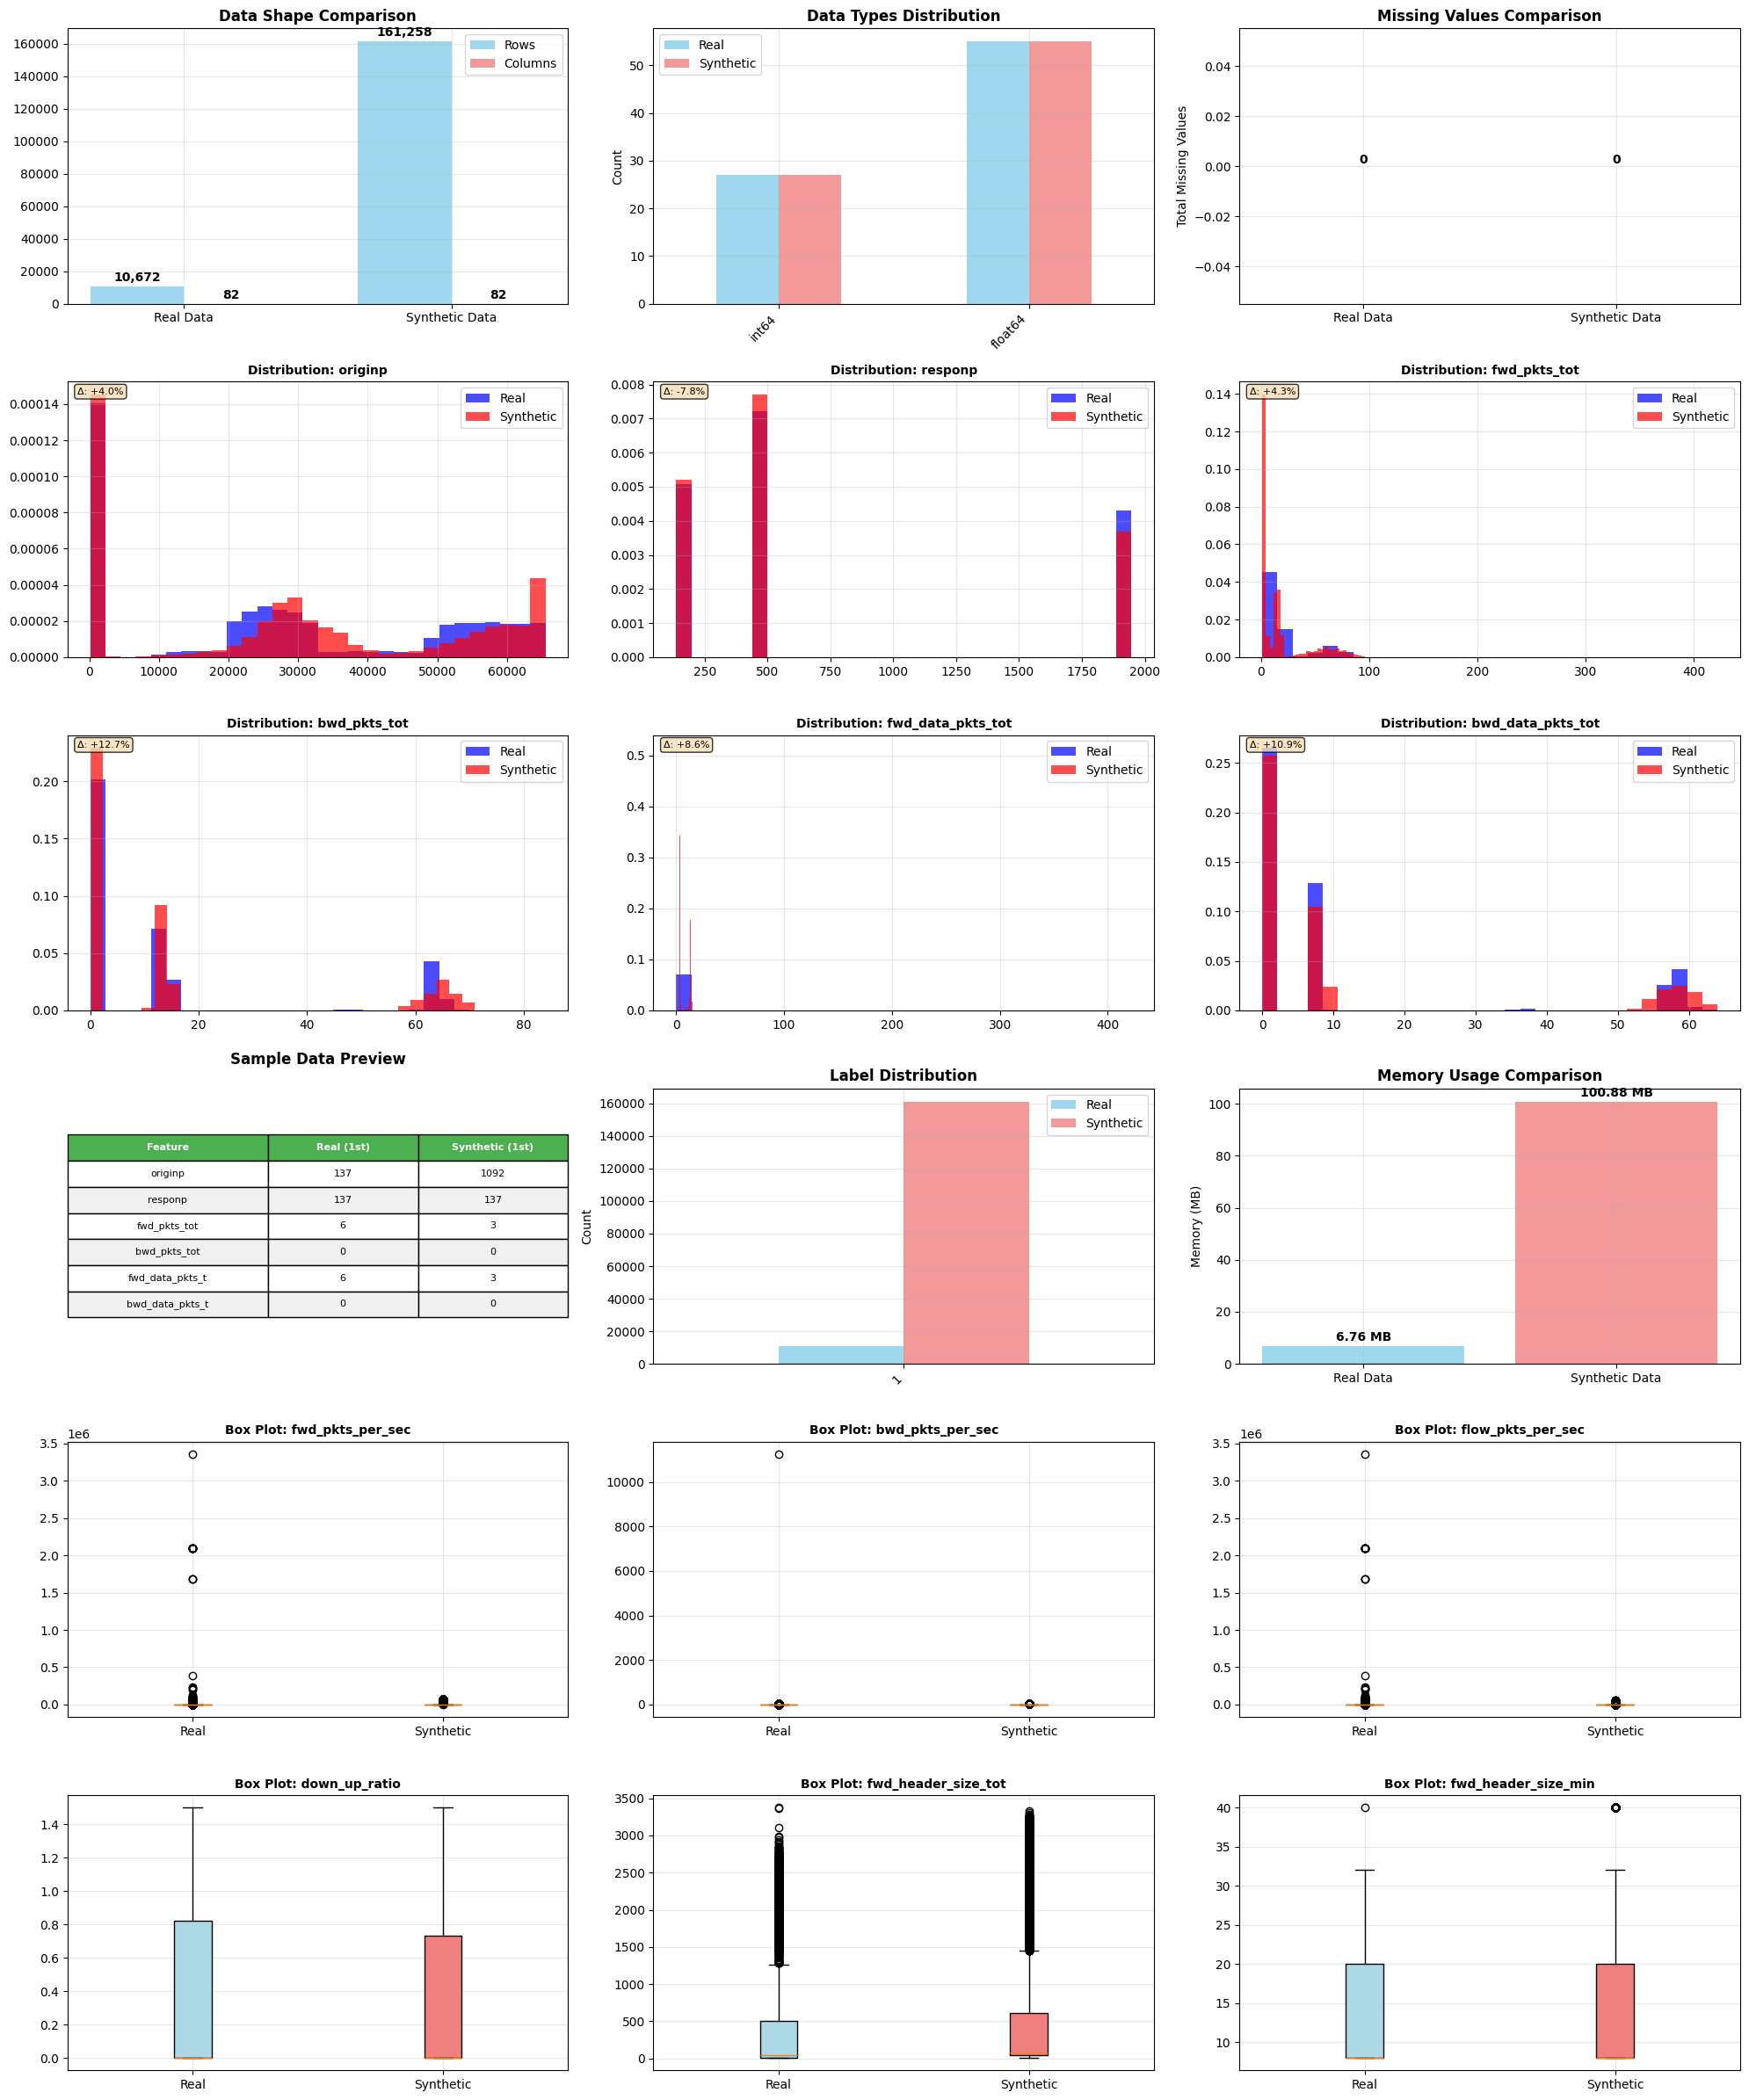


------------------------------------------------------------
DETAILED STATISTICAL COMPARISON TABLE
------------------------------------------------------------

COMPREHENSIVE STATISTICAL COMPARISON:


,Feature,Real_Mean,Synth_Mean,Mean_Diff_%,Real_Std,Synth_Std,Std_Diff_%,Real_Median,Synth_Median,Median_Diff_%,KS_Stat,KS_P_Value,Quality
0,originp,28156.568216,29277.708845,+3.98%,22956.449631,23482.667113,+2.29%,26507.000000,28823.000000,+8.74%,0.2467,0.0000,Excellent
1,responp,739.102511,681.271459,-7.82%,725.990184,689.266216,-5.06%,443.000000,443.000000,+0.00%,0.0369,0.0000,Good
2,fwd_pkts_tot,16.421664,17.121036,+4.26%,22.745730,22.990881,+1.08%,6.000000,6.000000,+0.00%,0.0840,0.0000,Excellent
3,bwd_pkts_tot,13.703711,15.444784,+12.71%,22.285223,23.680240,+6.26%,0.000000,1.000000,+0.00%,0.1362,0.0000,Fair
4,fwd_data_pkts_tot,5.091642,5.530523,+8.62%,5.779411,4.510493,-21.96%,5.000000,5.000000,+0.00%,0.0670,0.0000,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,idle.std,31334.209412,2336.456553,-92.54%,940371.255783,4319.772962,-99.54%,0.000000,0.000000,+0.00%,0.3486,0.0000,Poor
77,fwd_init_window_size,27942.594921,29611.053771,+5.97%,31848.565215,32017.286668,+0.53%,0.000000,0.000000,+0.00%,0.0295,0.0000,Good
78,bwd_init_window_size,12783.294603,14304.632328,+11.90%,14797.586015,16404.770439,+10.86%,0.000000,0.000000,+0.00%,0.0275,0.0000,Fair
79,fwd_last_window_size,9.778486,25.822620,+164.08%,623.890453,128.419391,-79.42%,0.000000,2.000000,+0.00%,0.5686,0.0000,Poor



------------------------------------------------------------
CORRELATION STRUCTURE ANALYSIS
------------------------------------------------------------

REAL DATA CORRELATION MATRIX:


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min
originp,1.000000,0.840720,0.121173,0.173743,-0.067480,0.176989,0.006985,0.016287,0.007003,0.106810,0.157446,0.091678,0.095682,0.173552,0.087424
responp,0.840720,1.000000,-0.290042,-0.250826,-0.341857,-0.226930,0.029507,-0.023612,0.029481,-0.351962,-0.265244,-0.353830,-0.356816,-0.251832,-0.357856
fwd_pkts_tot,0.121173,-0.290042,1.000000,0.968391,0.766099,0.963810,-0.031605,0.087441,-0.031508,0.733469,0.988564,0.676578,0.722222,0.968408,0.683077
bwd_pkts_tot,0.173743,-0.250826,0.968391,1.000000,0.635618,0.995636,-0.031745,0.091948,-0.031643,0.774060,0.985898,0.696174,0.739940,0.999992,0.700885
fwd_data_pkts_tot,-0.067480,-0.341857,0.766099,0.635618,1.000000,0.631222,-0.023187,0.053220,-0.023128,0.499378,0.663377,0.452343,0.478121,0.635662,0.453915
bwd_data_pkts_tot,0.176989,-0.226930,0.963810,0.995636,0.631222,1.000000,-0.028709,0.093426,-0.028605,0.715275,0.979392,0.628636,0.676844,0.995274,0.634117
fwd_pkts_per_sec,0.006985,0.029507,-0.031605,-0.031745,-0.023187,-0.028709,1.000000,-0.001888,0.999999,-0.044606,-0.032328,-0.044820,-0.045229,-0.031873,-0.045360
bwd_pkts_per_sec,0.016287,-0.023612,0.087441,0.091948,0.053220,0.093426,-0.001888,1.000000,-0.000778,0.077544,0.089538,0.097294,0.069502,0.091954,0.070819
flow_pkts_per_sec,0.007003,0.029481,-0.031508,-0.031643,-0.023128,-0.028605,0.999999,-0.000778,1.000000,-0.044520,-0.032228,-0.044712,-0.045152,-0.031771,-0.045281
down_up_ratio,0.106810,-0.351962,0.733469,0.774060,0.499378,0.715275,-0.044606,0.077544,-0.044520,1.000000,0.759462,0.975277,0.984873,0.776492,0.983447



SYNTHETIC DATA CORRELATION MATRIX:


,originp,responp,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min
originp,1.000000,0.663578,0.205733,0.250512,0.010681,0.245500,-0.155097,0.244052,-0.138791,0.212143,0.228683,0.203930,0.207075,0.247825,0.193814
responp,0.663578,1.000000,-0.251230,-0.221354,-0.418350,-0.199534,-0.091225,-0.170005,-0.076455,-0.309608,-0.232576,-0.269297,-0.308523,-0.223001,-0.312112
fwd_pkts_tot,0.205733,-0.251230,1.000000,0.925061,0.827237,0.915403,-0.087902,0.893428,-0.078976,0.704418,0.917965,0.597255,0.699206,0.926097,0.664009
bwd_pkts_tot,0.250512,-0.221354,0.925061,1.000000,0.836927,0.960248,-0.094735,0.921542,-0.084205,0.731487,0.944908,0.627602,0.722452,0.973414,0.684780
fwd_data_pkts_tot,0.010681,-0.418350,0.827237,0.836927,1.000000,0.828280,-0.038533,0.812045,-0.028173,0.645551,0.835149,0.557297,0.633327,0.835862,0.601469
bwd_data_pkts_tot,0.245500,-0.199534,0.915403,0.960248,0.828280,1.000000,-0.085437,0.930601,-0.075115,0.672342,0.934007,0.559219,0.659740,0.964396,0.618914
fwd_pkts_per_sec,-0.155097,-0.091225,-0.087902,-0.094735,-0.038533,-0.085437,1.000000,-0.079486,0.514766,-0.124427,-0.091848,-0.116112,-0.126584,-0.093622,-0.125049
bwd_pkts_per_sec,0.244052,-0.170005,0.893428,0.921542,0.812045,0.930601,-0.079486,1.000000,-0.065765,0.600469,0.918444,0.523274,0.584669,0.920618,0.539595
flow_pkts_per_sec,-0.138791,-0.076455,-0.078976,-0.084205,-0.028173,-0.075115,0.514766,-0.065765,1.000000,-0.116606,-0.079528,-0.112088,-0.119218,-0.083867,-0.118849
down_up_ratio,0.212143,-0.309608,0.704418,0.731487,0.645551,0.672342,-0.124427,0.600469,-0.116606,1.000000,0.737277,0.873662,0.950628,0.736425,0.947212


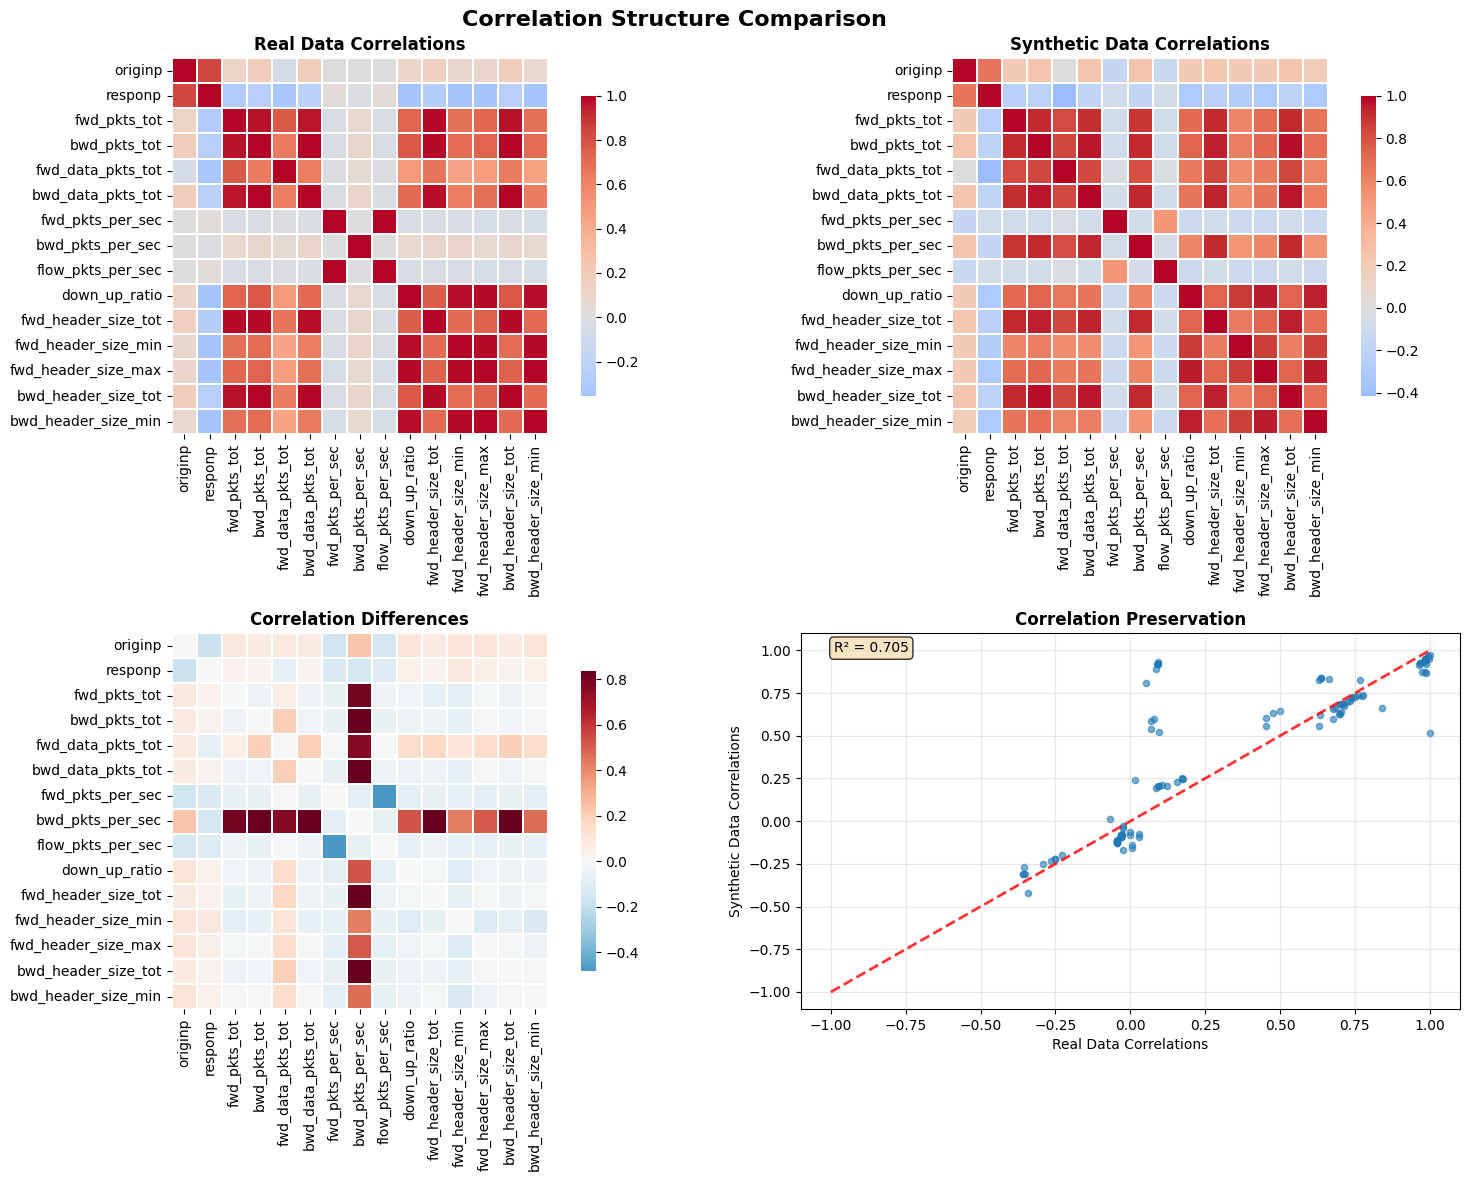


------------------------------------------------------------
FINAL QUALITY ASSESSMENT SUMMARY
------------------------------------------------------------


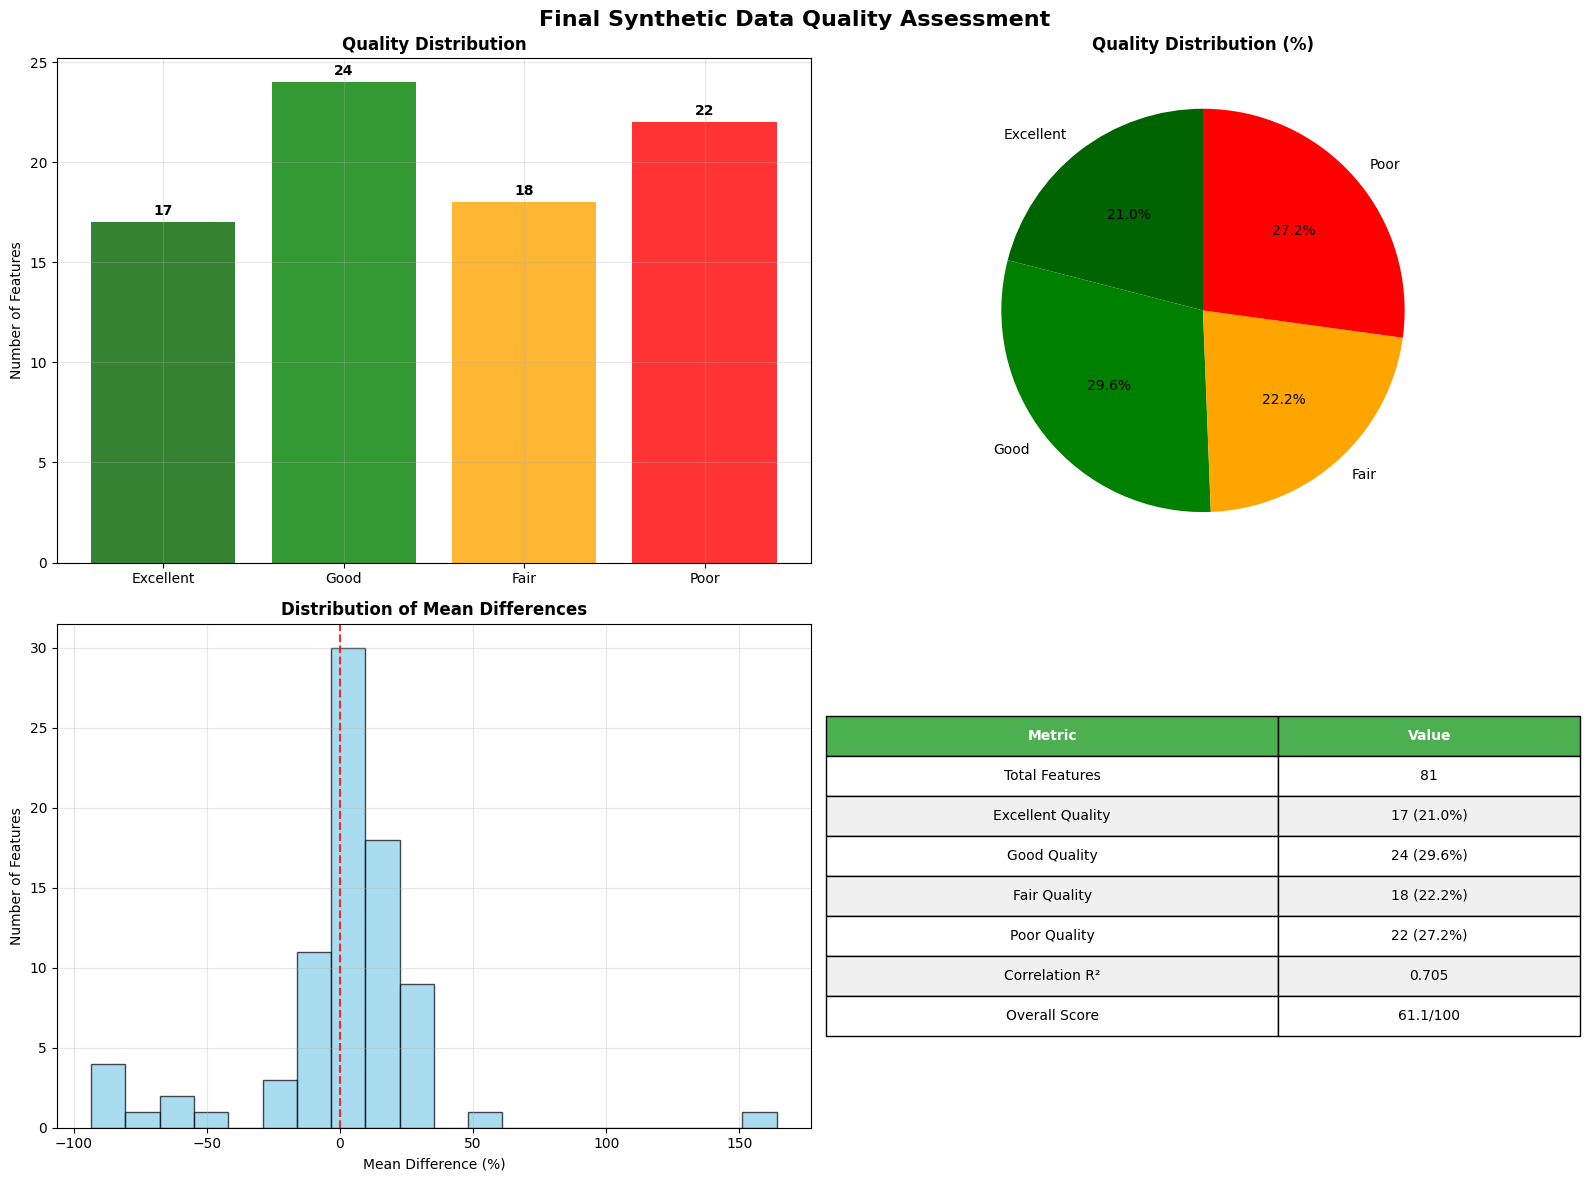


FINAL ASSESSMENT:
   Overall Quality Score: 61.1/100
   Correlation Preservation: 0.705
   Excellent Features: 17/81
   Good+ Features: 41/81

COMPREHENSIVE SYNTHETIC DATA EDA WITH DATA PREVIEW COMPLETED!


In [10]:
# =============================================================================
# SECTION 5.1: POST-GENERATION EDA - SYNTHETIC DATA QUALITY ASSESSMENT WITH DATA PREVIEW
# =============================================================================

def display_comprehensive_data_preview(result_dict, random_state=RANDOM_SEED):
    """
    Display comprehensive data preview comparison between real and synthetic data
    """
    print("\n" + "="*80)
    print("SECTION 5.1: COMPREHENSIVE DATA PREVIEW COMPARISON")
    print("="*80)

    real_data = result_dict['minority_data_processed'].copy()
    synthetic_data = result_dict['synthetic_data'].copy()

    print(f"Real minority data shape: {real_data.shape}")
    print(f"Synthetic data shape: {synthetic_data.shape}")

    # Basic data comparison
    print("\n" + "-"*60)
    print("BASIC DATA INFORMATION COMPARISON")
    print("-"*60)

    print("REAL DATA INFORMATION:")
    print(f"  Shape: {real_data.shape}")
    print(f"  Memory usage: {real_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Data types: {real_data.dtypes.value_counts().to_dict()}")
    print(f"  Missing values: {real_data.isnull().sum().sum()}")

    print("\nSYNTHETIC DATA INFORMATION:")
    print(f"  Shape: {synthetic_data.shape}")
    print(f"  Memory usage: {synthetic_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Data types: {synthetic_data.dtypes.value_counts().to_dict()}")
    print(f"  Missing values: {synthetic_data.isnull().sum().sum()}")


    print("\n" + "-"*60)
    print("DATA PREVIEW COMPARISONS")
    print("-"*60)

    # First five rows (real data)
    print("\nFIRST 5 ROWS COMPARISON:")
    print("\nREAL DATA (first 5 rows):")
    print("="*50)
    real_head = real_data.head()
    display(real_head)

    # First five rows (synthetic data)
    print("\nSYNTHETIC DATA (first 5 rows):")
    print("="*50)
    synthetic_head = synthetic_data.head()
    display(synthetic_head)

    # Last five rows (real data)
    print("\nLAST 5 ROWS COMPARISON:")
    print("\nREAL DATA (last 5 rows):")
    print("="*50)
    real_tail = real_data.tail()
    display(real_tail)

    # First five rows (synthetic data)
    print("\nSYNTHETIC DATA (last 5 rows):")
    print("="*50)
    synthetic_tail = synthetic_data.tail()
    display(synthetic_tail)

    # Random Sample
    print("\nRANDOM SAMPLE COMPARISON (10 random rows):")
    np.random.seed(RANDOM_SEED)

    print("\nREAL DATA (random sample):")
    print("="*50)
    real_sample = real_data.sample(n=min(10, len(real_data)))
    display(real_sample)

    print("\nSYNTHETIC DATA (random sample):")
    print("="*50)
    synthetic_sample = synthetic_data.sample(n=min(10, len(synthetic_data)))
    display(synthetic_sample)

    # Summary
    print("\n" + "-"*60)
    print("STATISTICAL SUMMARIES COMPARISON")
    print("-"*60)

    # Get numerical columns
    numerical_cols = [col for col in real_data.columns if col != 'Label' and
                     real_data[col].dtype in ['int64', 'float64']]

    print(f"\nAnalyzing {len(numerical_cols)} numerical features...")

    # Statistical summary comparison
    print("\nSTATISTICAL SUMMARY - REAL DATA:")
    print("="*50)
    real_stats = real_data[numerical_cols].describe()
    display(real_stats)

    print("\nSTATISTICAL SUMMARY - SYNTHETIC DATA:")
    print("="*50)
    synthetic_stats = synthetic_data[numerical_cols].describe()
    display(synthetic_stats)

    # Feature-by-feature comparison
    print("\nFEATURE-BY-FEATURE COMPARISON:")
    print("="*50)

    comparison_data = []
    for col in numerical_cols[:15]:  # Show first 15 features
        real_mean = real_data[col].mean()
        synthetic_mean = synthetic_data[col].mean()
        real_std = real_data[col].std()
        synthetic_std = synthetic_data[col].std()

        mean_diff = ((synthetic_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0
        std_diff = ((synthetic_std - real_std) / real_std * 100) if real_std != 0 else 0

        comparison_data.append({
            'Feature': col,
            'Real_Mean': f"{real_mean:.4f}",
            'Synthetic_Mean': f"{synthetic_mean:.4f}",
            'Mean_Diff_%': f"{mean_diff:+.2f}%",
            'Real_Std': f"{real_std:.4f}",
            'Synthetic_Std': f"{synthetic_std:.4f}",
            'Std_Diff_%': f"{std_diff:+.2f}%"
        })

    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)

    return real_data, synthetic_data, numerical_cols, comparison_df

def create_data_preview_visualizations(real_data, synthetic_data, numerical_cols, random_state=RANDOM_SEED):
    """
    Create comprehensive visualizations for data preview and comparison
    """
    print("\n" + "-"*60)
    print("DATA PREVIEW VISUALIZATIONS")
    print("-"*60)

    # Create main dashboard
    fig = plt.figure(figsize=(20, 24))

    # Data Shape and Basic Info Comparison
    ax1 = plt.subplot(6, 3, 1)
    datasets = ['Real Data', 'Synthetic Data']
    rows = [real_data.shape[0], synthetic_data.shape[0]]
    cols = [real_data.shape[1], synthetic_data.shape[1]]

    x = np.arange(len(datasets))
    width = 0.35

    bars1 = ax1.bar(x - width/2, rows, width, label='Rows', color='skyblue', alpha=0.8)
    bars2 = ax1.bar(x + width/2, cols, width, label='Columns', color='lightcoral', alpha=0.8)

    ax1.set_title('Data Shape Comparison', fontweight='bold', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for i, (row, col) in enumerate(zip(rows, cols)):
        ax1.text(i - width/2, row + max(rows)*0.01, f'{row:,}', ha='center', va='bottom', fontweight='bold')
        ax1.text(i + width/2, col + max(rows)*0.01, f'{col}', ha='center', va='bottom', fontweight='bold')

    # Data Types Distribution
    ax2 = plt.subplot(6, 3, 2)
    real_dtypes = real_data.dtypes.value_counts()
    synthetic_dtypes = synthetic_data.dtypes.value_counts()

    all_dtypes = set(real_dtypes.index) | set(synthetic_dtypes.index)
    dtype_comparison = pd.DataFrame({
        'Real': [real_dtypes.get(dt, 0) for dt in all_dtypes],
        'Synthetic': [synthetic_dtypes.get(dt, 0) for dt in all_dtypes]
    }, index=list(all_dtypes))

    dtype_comparison.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral'], alpha=0.8)
    ax2.set_title('Data Types Distribution', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # Missing Values Comparison
    ax3 = plt.subplot(6, 3, 3)
    real_missing = real_data.isnull().sum().sum()
    synthetic_missing = synthetic_data.isnull().sum().sum()

    missing_data = [real_missing, synthetic_missing]
    colors = ['red' if x > 0 else 'green' for x in missing_data]

    bars = ax3.bar(datasets, missing_data, color=colors, alpha=0.7)
    ax3.set_title('Missing Values Comparison', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Total Missing Values')
    ax3.grid(True, alpha=0.3)

    # Add value labels
    for bar, value in zip(bars, missing_data):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(missing_data)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')

    # Distribution comparisons for key features
    key_features = numerical_cols[:6] if len(numerical_cols) >= 6 else numerical_cols

    for i, feature in enumerate(key_features):
        ax = plt.subplot(6, 3, 4 + i)

        # Plot histograms
        ax.hist(real_data[feature].dropna(), bins=30, alpha=0.7,
                label='Real', color='blue', density=True)
        ax.hist(synthetic_data[feature].dropna(), bins=30, alpha=0.7,
                label='Synthetic', color='red', density=True)

        ax.set_title(f'Distribution: {feature}', fontweight='bold', fontsize=10)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistical info
        real_mean = real_data[feature].mean()
        synthetic_mean = synthetic_data[feature].mean()
        diff_pct = ((synthetic_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0

        ax.text(0.02, 0.98, f'Δ: {diff_pct:+.1f}%', transform=ax.transAxes,
                verticalalignment='top', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Sample data preview table
    ax10 = plt.subplot(6, 3, 10)
    ax10.axis('off')

    # Create sample comparison table
    sample_features = numerical_cols[:6] if len(numerical_cols) >= 6 else numerical_cols
    sample_data = []

    for i, feature in enumerate(sample_features):
        real_sample = real_data[feature].iloc[0] if len(real_data) > 0 else 'N/A'
        synthetic_sample = synthetic_data[feature].iloc[0] if len(synthetic_data) > 0 else 'N/A'

        real_str = f'{real_sample:.4f}' if isinstance(real_sample, (int, float)) else str(real_sample)
        synthetic_str = f'{synthetic_sample:.4f}' if isinstance(synthetic_sample, (int, float)) else str(synthetic_sample)

        sample_data.append([feature[:15], real_str, synthetic_str])

    table = ax10.table(cellText=sample_data,
                      colLabels=['Feature', 'Real (1st)', 'Synthetic (1st)'],
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.4, 0.3, 0.3])

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)

    # Style the table
    for i in range(3):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(sample_data) + 1):
        for j in range(3):
            table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

    ax10.set_title('Sample Data Preview', fontweight='bold', fontsize=12, pad=20)

    # Label distribution comparison
    ax11 = plt.subplot(6, 3, 11)

    if 'Label' in real_data.columns and 'Label' in synthetic_data.columns:
        real_labels = real_data['Label'].value_counts()
        synthetic_labels = synthetic_data['Label'].value_counts()

        all_labels = set(real_labels.index) | set(synthetic_labels.index)
        label_comparison = pd.DataFrame({
            'Real': [real_labels.get(label, 0) for label in all_labels],
            'Synthetic': [synthetic_labels.get(label, 0) for label in all_labels]
        }, index=list(all_labels))

        label_comparison.plot(kind='bar', ax=ax11, color=['skyblue', 'lightcoral'], alpha=0.8)
        ax11.set_title('Label Distribution', fontweight='bold', fontsize=12)
        ax11.set_ylabel('Count')
        ax11.legend()
        ax11.grid(True, alpha=0.3)
        plt.setp(ax11.get_xticklabels(), rotation=45, ha='right')
    else:
        ax11.text(0.5, 0.5, 'No Label column found', ha='center', va='center',
                 transform=ax11.transAxes, fontweight='bold')
        ax11.set_title('Label Distribution - N/A', fontweight='bold', fontsize=12)

    # Memory usage comparison
    ax12 = plt.subplot(6, 3, 12)

    real_memory = real_data.memory_usage(deep=True).sum() / 1024**2
    synthetic_memory = synthetic_data.memory_usage(deep=True).sum() / 1024**2

    memory_data = [real_memory, synthetic_memory]
    bars = ax12.bar(datasets, memory_data, color=['skyblue', 'lightcoral'], alpha=0.8)
    ax12.set_title('Memory Usage Comparison', fontweight='bold', fontsize=12)
    ax12.set_ylabel('Memory (MB)')
    ax12.grid(True, alpha=0.3)

    # Add value labels
    for bar, value in zip(bars, memory_data):
        ax12.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(memory_data)*0.01,
                 f'{value:.2f} MB', ha='center', va='bottom', fontweight='bold')

    # Detailed feature comparisons
    for i, feature in enumerate(numerical_cols[6:12]):  # Next 6 features
        if 13 + i > 18:
            break
        ax = plt.subplot(6, 3, 13 + i)

        # Box plots for better comparison
        data_to_plot = [real_data[feature].dropna(), synthetic_data[feature].dropna()]
        box_plot = ax.boxplot(data_to_plot, labels=['Real', 'Synthetic'], patch_artist=True)

        # Color the boxes
        box_plot['boxes'][0].set_facecolor('lightblue')
        box_plot['boxes'][1].set_facecolor('lightcoral')

        ax.set_title(f'Box Plot: {feature}', fontweight='bold', fontsize=10)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_detailed_comparison_table(real_data, synthetic_data, numerical_cols, random_state=RANDOM_SEED):
    """
    Create detailed comparison table with statistical tests
    """
    print("\n" + "-"*60)
    print("DETAILED STATISTICAL COMPARISON TABLE")
    print("-"*60)

    # Detailed comparison with statistical tests
    detailed_comparison = []

    for col in numerical_cols:
        real_col = real_data[col].dropna()
        synthetic_col = synthetic_data[col].dropna()

        # Basic statistics
        real_mean = real_col.mean()
        synthetic_mean = synthetic_col.mean()
        real_std = real_col.std()
        synthetic_std = synthetic_col.std()
        real_median = real_col.median()
        synthetic_median = synthetic_col.median()

        # Percentage differences
        mean_diff = ((synthetic_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0
        std_diff = ((synthetic_std - real_std) / real_std * 100) if real_std != 0 else 0
        median_diff = ((synthetic_median - real_median) / real_median * 100) if real_median != 0 else 0

        # Statistical tests
        try:
            from scipy import stats
            ks_stat, ks_pvalue = stats.ks_2samp(real_col, synthetic_col)

            # Quality assessment
            if abs(mean_diff) <= 5:
                quality = "Excellent"
            elif abs(mean_diff) <= 10:
                quality = "Good"
            elif abs(mean_diff) <= 20:
                quality = "Fair"
            else:
                quality = "Poor"

        except:
            ks_stat, ks_pvalue = None, None
            quality = "Unknown"

        detailed_comparison.append({
            'Feature': col,
            'Real_Mean': f"{real_mean:.6f}",
            'Synth_Mean': f"{synthetic_mean:.6f}",
            'Mean_Diff_%': f"{mean_diff:+.2f}%",
            'Real_Std': f"{real_std:.6f}",
            'Synth_Std': f"{synthetic_std:.6f}",
            'Std_Diff_%': f"{std_diff:+.2f}%",
            'Real_Median': f"{real_median:.6f}",
            'Synth_Median': f"{synthetic_median:.6f}",
            'Median_Diff_%': f"{median_diff:+.2f}%",
            'KS_Stat': f"{ks_stat:.4f}" if ks_stat is not None else "N/A",
            'KS_P_Value': f"{ks_pvalue:.4f}" if ks_pvalue is not None else "N/A",
            'Quality': quality
        })

    detailed_df = pd.DataFrame(detailed_comparison)

    print("\nCOMPREHENSIVE STATISTICAL COMPARISON:")
    print("="*100)
    display(detailed_df)

    return detailed_df

def create_correlation_analysis(real_data, synthetic_data, numerical_cols, random_state=RANDOM_SEED):
    """
    Create correlation analysis and visualization
    """
    print("\n" + "-"*60)
    print("CORRELATION STRUCTURE ANALYSIS")
    print("-"*60)

    # Select subset of features for correlation analysis
    corr_features = numerical_cols[:15] if len(numerical_cols) > 15 else numerical_cols

    # Calculate correlation matrices
    real_corr = real_data[corr_features].corr()
    synthetic_corr = synthetic_data[corr_features].corr()

    print(f"\nREAL DATA CORRELATION MATRIX:")
    print("="*50)
    display(real_corr)

    print(f"\nSYNTHETIC DATA CORRELATION MATRIX:")
    print("="*50)
    display(synthetic_corr)

    # Create correlation comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Correlation Structure Comparison', fontsize=16, fontweight='bold')

    # Real data correlations
    sns.heatmap(real_corr, ax=axes[0,0], cmap='coolwarm', center=0,
                square=True, linewidths=0.1, cbar_kws={"shrink": .8})
    axes[0,0].set_title('Real Data Correlations', fontweight='bold')

    # Synthetic data correlations
    sns.heatmap(synthetic_corr, ax=axes[0,1], cmap='coolwarm', center=0,
                square=True, linewidths=0.1, cbar_kws={"shrink": .8})
    axes[0,1].set_title('Synthetic Data Correlations', fontweight='bold')

    # Correlation differences
    corr_diff = synthetic_corr - real_corr
    sns.heatmap(corr_diff, ax=axes[1,0], cmap='RdBu_r', center=0,
                square=True, linewidths=0.1, cbar_kws={"shrink": .8})
    axes[1,0].set_title('Correlation Differences', fontweight='bold')

    # Correlation scatter plot
    real_corr_values = real_corr.values[np.triu_indices_from(real_corr.values, k=1)]
    synthetic_corr_values = synthetic_corr.values[np.triu_indices_from(synthetic_corr.values, k=1)]

    axes[1,1].scatter(real_corr_values, synthetic_corr_values, alpha=0.6, s=20)
    axes[1,1].plot([-1, 1], [-1, 1], 'r--', alpha=0.8, linewidth=2)
    axes[1,1].set_xlabel('Real Data Correlations')
    axes[1,1].set_ylabel('Synthetic Data Correlations')
    axes[1,1].set_title('Correlation Preservation', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)

    # Add R² score
    from sklearn.metrics import r2_score
    r2 = r2_score(real_corr_values, synthetic_corr_values)
    axes[1,1].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[1,1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return real_corr, synthetic_corr, corr_diff, r2

def create_final_quality_summary(detailed_df, correlation_r2, random_state=RANDOM_SEED):
    """
    Create final quality assessment summary
    """
    print("\n" + "-"*60)
    print("FINAL QUALITY ASSESSMENT SUMMARY")
    print("-"*60)

    # Calculate quality metrics
    total_features = len(detailed_df)
    excellent_count = (detailed_df['Quality'] == 'Excellent').sum()
    good_count = (detailed_df['Quality'] == 'Good').sum()
    fair_count = (detailed_df['Quality'] == 'Fair').sum()
    poor_count = (detailed_df['Quality'] == 'Poor').sum()

    # Calculate overall quality score
    quality_score = (excellent_count * 100 + good_count * 75 + fair_count * 50 + poor_count * 25) / total_features

    # Create summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Final Synthetic Data Quality Assessment', fontsize=16, fontweight='bold')

    # Quality distribution
    quality_counts = [excellent_count, good_count, fair_count, poor_count]
    quality_labels = ['Excellent', 'Good', 'Fair', 'Poor']
    colors = ['darkgreen', 'green', 'orange', 'red']

    ax1 = axes[0, 0]
    bars = ax1.bar(quality_labels, quality_counts, color=colors, alpha=0.8)
    ax1.set_title('Quality Distribution', fontweight='bold')
    ax1.set_ylabel('Number of Features')
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar, count in zip(bars, quality_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(quality_counts)*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold')

    # Quality pie chart
    ax2 = axes[0, 1]
    ax2.pie(quality_counts, labels=quality_labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Quality Distribution (%)', fontweight='bold')

    # Mean difference histogram
    ax3 = axes[1, 0]
    mean_diffs = [float(x.replace('%', '').replace('+', '')) for x in detailed_df['Mean_Diff_%']]
    ax3.hist(mean_diffs, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    ax3.set_title('Distribution of Mean Differences', fontweight='bold')
    ax3.set_xlabel('Mean Difference (%)')
    ax3.set_ylabel('Number of Features')
    ax3.axvline(0, color='red', linestyle='--', alpha=0.8)
    ax3.grid(True, alpha=0.3)

    # Summary statistics table
    ax4 = axes[1, 1]
    ax4.axis('off')

    summary_data = [
        ['Total Features', total_features],
        ['Excellent Quality', f'{excellent_count} ({excellent_count/total_features*100:.1f}%)'],
        ['Good Quality', f'{good_count} ({good_count/total_features*100:.1f}%)'],
        ['Fair Quality', f'{fair_count} ({fair_count/total_features*100:.1f}%)'],
        ['Poor Quality', f'{poor_count} ({poor_count/total_features*100:.1f}%)'],
        ['Correlation R²', f'{correlation_r2:.3f}'],
        ['Overall Score', f'{quality_score:.1f}/100']
    ]

    table = ax4.table(cellText=summary_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.6, 0.4])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style the table
    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(summary_data) + 1):
        for j in range(2):
            table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

    plt.tight_layout()
    plt.show()

    # Print final assessment
    print(f"\nFINAL ASSESSMENT:")
    print(f"   Overall Quality Score: {quality_score:.1f}/100")
    print(f"   Correlation Preservation: {correlation_r2:.3f}")
    print(f"   Excellent Features: {excellent_count}/{total_features}")
    print(f"   Good+ Features: {excellent_count + good_count}/{total_features}")

    return {
        'quality_score': quality_score,
        'correlation_r2': correlation_r2,
        'excellent_count': excellent_count,
        'good_count': good_count,
        'fair_count': fair_count,
        'poor_count': poor_count,
        'total_features': total_features
    }

def perform_comprehensive_synthetic_eda_with_data_preview(result_dict, random_state=RANDOM_SEED):
    """
    Main function to perform comprehensive synthetic data EDA with extensive data preview
    """
    print("="*80)
    print("COMPREHENSIVE SYNTHETIC DATA EDA WITH DATA PREVIEW")
    print("="*80)

    # Comprehensive data preview and basic comparisons
    real_data, synthetic_data, numerical_cols, basic_comparison = display_comprehensive_data_preview(result_dict)

    # Create comprehensive visualizations
    create_data_preview_visualizations(real_data, synthetic_data, numerical_cols)

    # Detailed statistical comparison table
    detailed_comparison_df = create_detailed_comparison_table(real_data, synthetic_data, numerical_cols)

    # Correlation analysis
    real_corr, synthetic_corr, corr_diff, correlation_r2 = create_correlation_analysis(
        real_data, synthetic_data, numerical_cols)

    # Final quality assessment
    quality_summary = create_final_quality_summary(detailed_comparison_df, correlation_r2)

    print("\n" + "="*80)
    print("COMPREHENSIVE SYNTHETIC DATA EDA WITH DATA PREVIEW COMPLETED!")
    print("="*80)

    return {
        'real_data': real_data,
        'synthetic_data': synthetic_data,
        'numerical_cols': numerical_cols,
        'basic_comparison': basic_comparison,
        'detailed_comparison': detailed_comparison_df,
        'correlations': {'real': real_corr, 'synthetic': synthetic_corr, 'difference': corr_diff},
        'correlation_r2': correlation_r2,
        'quality_summary': quality_summary
    }

# ==========================================================
# EXECUTION
# ==========================================================

synthetic_eda_results = perform_comprehensive_synthetic_eda_with_data_preview(result, random_state=RANDOM_SEED)


# Section 6 - Train and Measure Prediction Performance using ML and DL Models

## Goal
- Train and Test ML and DL models
- Plot prediction performance


In [11]:
# =============================================================================
# SECTION 6.1: DASHBOARD
# =============================================================================

def create_evaluation_dashboard_with_roc(model_results, y_test, random_state=42):
    """
    Create comprehensive evaluation dashboard with dedicated ROC-AUC chart
    """

    if not model_results:
        print("No models were successfully trained!")
        return

    # Create main figure with significantly improved spacing
    fig = plt.figure(figsize=(24, 22))
    gs = fig.add_gridspec(4, 3, height_ratios=[1.3, 1.3, 1, 1], hspace=0.8, wspace=0.5)

    # Model Performance Comparison with improved aesthetics
    ax1 = fig.add_subplot(gs[0, :])

    models = list(model_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    # Fixed: Corrected variable name in dictionary comprehension
    data_for_plot = {metric: [model_results[model][metric] for model in models] for metric in metrics}

    x = np.arange(len(models))
    width = 0.18

    # Enhanced color palette
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

    for i, metric in enumerate(metrics):
        bars = ax1.bar(x + i*width, data_for_plot[metric], width,
                      label=metric.replace('_', ' ').title(),
                      color=colors[i], alpha=0.8, edgecolor='white', linewidth=0.8)

        # Add value labels on bars with better positioning
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add label if bar has height
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                        f'{height:.3f}', ha='center', va='bottom',
                        fontsize=9, fontweight='bold', color='#2C3E50')

    ax1.set_xlabel('Models', fontsize=12, fontweight='bold', color='#2C3E50')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold', color='#2C3E50')
    ax1.set_title('Model Performance Comparison', fontsize=16, fontweight='bold',
                 color='#2C3E50', pad=30)
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=10, fontweight='bold')

    # Move legend outside plot area to prevent overlap
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True,
              fancybox=True, shadow=True, fontsize=10, framealpha=0.9)

    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.set_ylim(0, 1.15)  # Increased top margin for value labels
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_color('#BDC3C7')
    ax1.spines['bottom'].set_color('#BDC3C7')

    # Dedicated ROC-AUC Bar Chart with enhanced styling
    ax2 = fig.add_subplot(gs[1, :])

    # Extract ROC-AUC scores
    roc_scores = []
    model_names_roc = []

    for name, results in model_results.items():
        if results['roc_auc'] is not None:
            roc_scores.append(results['roc_auc'])
            model_names_roc.append(name)

    if roc_scores:
        # Enhanced gradient colors for ROC-AUC
        roc_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'][:len(roc_scores)]
        bars = ax2.bar(model_names_roc, roc_scores, color=roc_colors,
                      alpha=0.8, edgecolor='white', linewidth=1.2)

        ax2.set_xlabel('Models', fontsize=12, fontweight='bold', color='#2C3E50')
        ax2.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold', color='#2C3E50')
        ax2.set_title('ROC-AUC Comparison Across Models', fontsize=16, fontweight='bold',
                     color='#2C3E50', pad=30)
        ax2.set_ylim(0, 1.08)  # Increased for value labels
        ax2.grid(True, alpha=0.2, linestyle='--')

        # Add value labels on bars with better positioning
        for bar, score in zip(bars, roc_scores):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.025,
                    f'{score:.3f}', ha='center', va='bottom',
                    fontweight='bold', fontsize=11, color='#2C3E50',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_color('#BDC3C7')
        ax2.spines['bottom'].set_color('#BDC3C7')
    else:
        ax2.text(0.5, 0.5, 'No ROC-AUC scores available', ha='center', va='center',
                transform=ax2.transAxes, fontsize=14, fontweight='bold', color='#E74C3C')
        ax2.set_title('ROC-AUC Comparison - No Data Available', fontsize=16, fontweight='bold')

    # Enhanced Confusion Matrices with better spacing
    top_models = sorted(model_results.items(), key=lambda x: x[1]['f1_score'], reverse=True)[:6]

    confusion_colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Reds', 'YlOrBr']

    for i, (name, results) in enumerate(top_models):
        if i >= 6:  # Limit to 6 confusion matrices to fit layout
            break
        row = 2 + (i // 3)
        col = i % 3
        ax = fig.add_subplot(gs[row, col])

        # Enhanced heatmap with better styling
        sns.heatmap(results['confusion_matrix'], annot=True, fmt='d',
                   cmap=confusion_colors[i % len(confusion_colors)], ax=ax,
                   cbar_kws={'shrink': 0.8}, square=True, linewidths=0.8,
                   annot_kws={'size': 11, 'weight': 'bold'})

        # Truncate long model names for better display
        display_name = name[:15] + "..." if len(name) > 18 else name
        ax.set_title(f'{display_name}\nConfusion Matrix', fontsize=10, fontweight='bold',
                    color='#2C3E50', pad=15)
        ax.set_xlabel('Predicted', fontsize=9, fontweight='bold', color='#2C3E50')
        ax.set_ylabel('Actual', fontsize=9, fontweight='bold', color='#2C3E50')
        ax.tick_params(labelsize=8)

    # Increased padding significantly to prevent overlaps
    plt.tight_layout(pad=4.0, rect=[0, 0, 0.95, 1])  # rect parameter leaves space for legend
    plt.show()

    # Add extra spacing before next plots
    print("\n" + "="*80 + "\n")

    # Detailed ROC Curves Plot
    create_detailed_roc_curves(model_results, y_test)

    # Performance Summary Table
    print_performance_table(model_results)

    return model_results


def create_detailed_roc_curves(model_results, y_test, random_state=42):
    """
    Create detailed ROC curves with enhanced visualization and better spacing
    """
    plt.figure(figsize=(15, 11))

    # Enhanced color palette for ROC curves
    colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#E67E22']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.']

    models_with_roc = []

    for i, (name, results) in enumerate(model_results.items()):
        if results['roc_auc'] is not None and results['y_pred_proba'] is not None:
            try:
                if len(np.unique(y_test)) == 2:  # Binary classification
                    from sklearn.metrics import roc_curve
                    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])

                    plt.plot(fpr, tpr, color=colors[i % len(colors)],
                            linewidth=3, linestyle=linestyles[i % len(linestyles)],
                            label=f'{name} (AUC = {results["roc_auc"]:.3f})',
                            marker='o', markersize=4, markevery=20, alpha=0.8)
                    models_with_roc.append(name)

            except Exception as e:
                print(f"Could not plot ROC curve for {name}: {str(e)}")

    # Enhanced random classifier line
    plt.plot([0, 1], [0, 1], color='#95A5A6', linestyle='--', alpha=0.7,
             linewidth=2, label='Random Classifier (AUC = 0.500)')

    # Enhanced plot customization
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color='#2C3E50')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', color='#2C3E50')
    plt.title('ROC Curves Comparison', fontsize=18, fontweight='bold',
             color='#2C3E50', pad=25)

    # Position legend outside plot area
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True,
              fancybox=True, shadow=True, fontsize=11, framealpha=0.95,
              edgecolor='#BDC3C7')

    # Enhanced grid and styling
    plt.grid(True, alpha=0.3, linestyle=':', color='#BDC3C7')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#BDC3C7')
    ax.spines['bottom'].set_color('#BDC3C7')

    # Enhanced AUC text box with better positioning
    if models_with_roc:
        best_model = max([(name, model_results[name]['roc_auc']) for name in models_with_roc],
                        key=lambda x: x[1])
        plt.text(0.02, 0.98, f'Best AUC\n{best_model[0][:15]}\n({best_model[1]:.3f})',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#F8F9FA',
                         edgecolor='#DEE2E6', alpha=0.95),
                fontweight='bold', color='#2C3E50')

    # Use subplots_adjust for better spacing control
    plt.subplots_adjust(right=0.75)
    plt.tight_layout(pad=3.0)
    plt.show()

    # Add spacing after ROC plot
    print("\n" + "="*80 + "\n")


def print_performance_table(model_results, random_state=42):
    """
    Print performance table with ROC-AUC highlighting and better spacing
    """
    print(f"\n{'='*95}")
    print("🎯 DETAILED PERFORMANCE METRICS TABLE")
    print(f"{'='*95}")

    # Enhanced table header with better spacing
    header = f"{'Model':<25} {'Accuracy':<10} {'Precision':<11} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10} {'Status':<10}"
    print(header)
    print("─" * 95)

    # Sort models by ROC-AUC score
    sorted_models = sorted(model_results.items(),
                          key=lambda x: x[1]['roc_auc'] if x[1]['roc_auc'] is not None else 0,
                          reverse=True)

    for i, (name, results) in enumerate(sorted_models):
        roc_display = f"{results['roc_auc']:.4f}" if results['roc_auc'] is not None else "N/A    "

        # Enhanced status indicators
        if i == 0 and results['roc_auc'] is not None:
            status = "Best   "
        elif i == 1 and results['roc_auc'] is not None:
            status = "2nd    "
        elif i == 2 and results['roc_auc'] is not None:
            status = "3rd    "
        else:
            status = "Good   "

        # Truncate model name if too long
        display_name = name[:22] + "..." if len(name) > 22 else name

        print(f"{display_name:<25} {results['accuracy']:<10.4f} {results['precision']:<11.4f} "
              f"{results['recall']:<10.4f} {results['f1_score']:<10.4f} {roc_display:<10} {status:<10}")

    # Enhanced ROC-AUC Summary Statistics with better spacing
    roc_scores = [r['roc_auc'] for r in model_results.values() if r['roc_auc'] is not None]
    if roc_scores:
        print(f"\n{'='*60}")
        print("ROC-AUC SUMMARY STATISTICS")
        print(f"{'='*60}")
        print(f"Best ROC-AUC:     {max(roc_scores):.4f}")
        print(f"Average ROC-AUC:  {np.mean(roc_scores):.4f}")
        print(f"Std Dev ROC-AUC:  {np.std(roc_scores):.4f}")
        print(f"Models with ROC:  {len(roc_scores)}/{len(model_results)}")
        print(f"{'='*60}")
        print("\n" + "="*80 + "\n")


In [12]:
# =============================================================================
# SECTION 6.2: AUC-ROC ANALYSIS
# =============================================================================


def create_roc_auc_comparison_chart(model_results, random_state=RANDOM_SEED):
    """
    Create a standalone ROC-AUC comparison chart with enhanced features
    """
    plt.figure(figsize=(14, 8))

    # Extract data for models with ROC-AUC
    models_data = []
    for name, results in model_results.items():
        if results['roc_auc'] is not None:
            models_data.append({
                'model': name,
                'roc_auc': results['roc_auc'],
                'accuracy': results['accuracy'],
                'f1_score': results['f1_score']
            })

    if not models_data:
        print("No models with ROC-AUC scores available for comparison")
        return

    # Sort by ROC-AUC score
    models_data.sort(key=lambda x: x['roc_auc'], reverse=True)

    # Create subplot layout with enhanced spacing
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # ROC-AUC Bar Chart with enhanced aesthetics
    models = [m['model'] for m in models_data]
    roc_scores = [m['roc_auc'] for m in models_data]

    # Enhanced color palette with gradient effect
    colors = []
    for i, score in enumerate(roc_scores):
        if score == max(roc_scores):
            colors.append('#E74C3C')  # Red for best model
        elif i == 1:
            colors.append('#F39C12')  # Orange for second best
        elif i == 2:
            colors.append('#F1C40F')  # Yellow for third best
        else:
            colors.append('#3498DB')  # Blue for others

    bars1 = ax1.bar(models, roc_scores, color=colors, alpha=0.8,
                    edgecolor='white', linewidth=1.5)

    # Enhanced axis styling
    ax1.set_xlabel('Models', fontsize=14, fontweight='bold', color='#2C3E50')
    ax1.set_ylabel('ROC-AUC Score', fontsize=14, fontweight='bold', color='#2C3E50')
    ax1.set_title('ROC-AUC Performance Ranking', fontsize=16, fontweight='bold',
                  color='#2C3E50', pad=25)
    ax1.set_ylim(0, 1.12)  # Extra space for value labels
    ax1.grid(True, alpha=0.2, axis='y', linestyle='--', color='#BDC3C7')

    # Enhanced value labels with background boxes
    for bar, score in zip(bars1, roc_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.025,
                f'{score:.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=11, color='#2C3E50',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                         edgecolor='#BDC3C7', alpha=0.9))

    # Enhanced x-axis labels
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right',
             fontsize=11, fontweight='bold', color='#2C3E50')

    # Remove top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_color('#BDC3C7')
    ax1.spines['bottom'].set_color('#BDC3C7')

    # ROC-AUC vs F1-Score Scatter Plot with enhanced aesthetics
    f1_scores = [m['f1_score'] for m in models_data]

    # Enhanced scatter plot with size variation
    sizes = [150 + (score * 100) for score in roc_scores]  # Size based on ROC-AUC
    scatter = ax2.scatter(f1_scores, roc_scores, s=sizes, alpha=0.7,
                         c=roc_scores, cmap='viridis', edgecolors='white',
                         linewidth=2)

    # Enhanced model labels with better positioning
    for i, model_data in enumerate(models_data):
        # Truncate long model names for better display
        display_name = model_data['model'][:12] + "..." if len(model_data['model']) > 15 else model_data['model']

        ax2.annotate(display_name,
                    (model_data['f1_score'], model_data['roc_auc']),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=10, fontweight='bold', color='#2C3E50',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                             edgecolor='#BDC3C7', alpha=0.8))

    # Enhanced scatter plot styling
    ax2.set_xlabel('F1-Score', fontsize=14, fontweight='bold', color='#2C3E50')
    ax2.set_ylabel('ROC-AUC Score', fontsize=14, fontweight='bold', color='#2C3E50')
    ax2.set_title('ROC-AUC vs F1-Score Relationship', fontsize=16, fontweight='bold',
                  color='#2C3E50', pad=25)
    ax2.grid(True, alpha=0.2, linestyle='--', color='#BDC3C7')
    ax2.set_xlim(-0.02, 1.05)  # Slight padding for annotations
    ax2.set_ylim(-0.02, 1.05)

    # Remove top and right spines for scatter plot
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_color('#BDC3C7')
    ax2.spines['bottom'].set_color('#BDC3C7')

    # Add colorbar for scatter plot
    cbar = plt.colorbar(scatter, ax=ax2, shrink=0.8, pad=0.02)
    cbar.set_label('ROC-AUC Score', fontsize=12, fontweight='bold', color='#2C3E50')
    cbar.ax.tick_params(labelsize=10)

    # Enhanced layout with proper spacing
    plt.tight_layout(pad=4.0)
    plt.subplots_adjust(wspace=0.3)  # Extra space between subplots
    plt.show()

    return models_data


In [13]:

# =============================================================================
# SECTION 6.3: SYNTHETIC DATA CLEANING
# =============================================================================



def clean_and_prepare_data(result_dict, random_state=RANDOM_SEED):
    """
    Clean data by removing NaN features and prepare for ML using existing train-test split
    """
    print("="*70)
    print("DATA PREPARATION WITH NaN FEATURE REMOVAL")
    print("="*70)

    # Use existing train-test split from the notebook
    original_train_data = result_dict['train_data'].copy()
    synthetic_data = result_dict['synthetic_data'].copy()
    test_data = result_dict['test_data'].copy()
    minority_class = result_dict['minority_class']

    print(f"Using existing train-test split:")
    print(f"  Original training data: {original_train_data.shape}")
    print(f"  Synthetic data: {synthetic_data.shape}")
    print(f"  Test data: {test_data.shape}")
    print(f"  Minority class: {minority_class}")

    # Combine synthetic data with training data (majority + synthetic minority)
    majority_data = original_train_data[original_train_data['Label'] != minority_class]
    combined_train_data = pd.concat([majority_data, synthetic_data], ignore_index=True)

    print(f"\nAfter combining with synthetic data:")
    print(f"  Majority class samples: {len(majority_data)}")
    print(f"  Synthetic minority samples: {len(synthetic_data)}")
    print(f"  Combined training data: {combined_train_data.shape}")

    print(f"\nClass distribution after synthetic integration:")
    print(combined_train_data['Label'].value_counts())

    # Remove identifier and unnecessary columns
    columns_to_remove = ['Unnamed: 0', 'uid', 'originh', 'responh', 'attack_category']

    for dataset_name, dataset in [('combined_train', combined_train_data), ('test', test_data)]:
        existing_cols = [col for col in columns_to_remove if col in dataset.columns]
        if existing_cols:
            if dataset_name == 'combined_train':
                combined_train_data = combined_train_data.drop(columns=existing_cols)
            else:
                test_data = test_data.drop(columns=existing_cols)
            print(f"  Removed from {dataset_name}: {existing_cols}")

    # Handle timedelta columns (convert to seconds)
    print(f"\nHandling timedelta columns...")
    for col in combined_train_data.columns:
        if col != 'Label' and combined_train_data[col].dtype == 'object':
            # Check if it's a timedelta column
            sample_val = str(combined_train_data[col].iloc[0])
            if 'days' in sample_val and ':' in sample_val:
                print(f"  Converting timedelta column: {col}")
                combined_train_data[col] = pd.to_timedelta(combined_train_data[col]).dt.total_seconds()
                test_data[col] = pd.to_timedelta(test_data[col]).dt.total_seconds()

    # Identify and remove features with NaN values
    print(f"\nAnalyzing NaN values...")

    # Get feature columns (exclude Label)
    feature_columns = [col for col in combined_train_data.columns if col != 'Label']

    # Check for NaN in combined training data
    train_nan_counts = combined_train_data[feature_columns].isnull().sum()
    test_nan_counts = test_data[feature_columns].isnull().sum()

    # Find columns with any NaN values
    columns_with_nan = set()
    columns_with_nan.update(train_nan_counts[train_nan_counts > 0].index.tolist())
    columns_with_nan.update(test_nan_counts[test_nan_counts > 0].index.tolist())

    print(f"  Total features before NaN removal: {len(feature_columns)}")
    print(f"  Features with NaN values: {len(columns_with_nan)}")

    if columns_with_nan:
        print(f"  Removing {len(columns_with_nan)} features with NaN values:")
        for col in sorted(columns_with_nan):
            train_nan = train_nan_counts.get(col, 0)
            test_nan = test_nan_counts.get(col, 0)
            print(f"    {col}: {train_nan} train NaN, {test_nan} test NaN")

        # Remove columns with NaN
        combined_train_data = combined_train_data.drop(columns=list(columns_with_nan))
        test_data = test_data.drop(columns=list(columns_with_nan))

    # Update feature columns after removal
    clean_feature_columns = [col for col in combined_train_data.columns if col != 'Label']

    print(f"  Clean features after NaN removal: {len(clean_feature_columns)}")

    # Prepare final datasets
    X_train = combined_train_data[clean_feature_columns].copy()
    y_train = combined_train_data['Label'].copy()
    X_test = test_data[clean_feature_columns].copy()
    y_test = test_data['Label'].copy()

    # Handle any remaining categorical features
    categorical_columns = X_train.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        print(f"\nEncoding {len(categorical_columns)} categorical features...")

        for col in categorical_columns:
            # Get all unique values from both datasets
            train_unique = set(X_train[col].astype(str).unique())
            test_unique = set(X_test[col].astype(str).unique())
            all_unique = train_unique.union(test_unique)

            # Encode
            le = LabelEncoder()
            le.fit(list(all_unique))
            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))

    # Scale features
    print(f"\nScaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Final verification - ensure no NaN or infinite values
    print(f"\nFinal data quality check:")
    print(f"  X_train shape: {X_train_scaled.shape}")
    print(f"  X_test shape: {X_test_scaled.shape}")
    print(f"  NaN in X_train: {np.isnan(X_train_scaled).sum()}")
    print(f"  NaN in X_test: {np.isnan(X_test_scaled).sum()}")
    print(f"  Infinite in X_train: {np.isinf(X_train_scaled).sum()}")
    print(f"  Infinite in X_test: {np.isinf(X_test_scaled).sum()}")

    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'feature_columns': clean_feature_columns,
        'scaler': scaler,
        'original_features': len(feature_columns),
        'clean_features': len(clean_feature_columns),
        'removed_features': len(columns_with_nan)
    }

# Execute data preparation
prepared_data = clean_and_prepare_data(result)


DATA PREPARATION WITH NaN FEATURE REMOVAL
Using existing train-test split:
  Original training data: (182602, 88)
  Synthetic data: (161258, 82)
  Test data: (45651, 88)
  Minority class: 1

After combining with synthetic data:
  Majority class samples: 171930
  Synthetic minority samples: 161258
  Combined training data: (333188, 88)

Class distribution after synthetic integration:
Label
0    171930
1    161258
Name: count, dtype: int64
  Removed from combined_train: ['Unnamed: 0', 'uid', 'originh', 'responh', 'attack_category']
  Removed from test: ['Unnamed: 0', 'uid', 'originh', 'responh', 'attack_category']

Handling timedelta columns...
  Converting timedelta column: flow_duration

Analyzing NaN values...
  Total features before NaN removal: 82
  Features with NaN values: 1
  Removing 1 features with NaN values:
    flow_duration: 161258 train NaN, 0 test NaN
  Clean features after NaN removal: 81

Scaling features...

Final data quality check:
  X_train shape: (333188, 81)
  X_t

DATA EXPLORATION SUMMARY
Training set shape: (333188, 81)
Test set shape: (45651, 81)
Number of features: 81
Training samples: 333188
Test samples: 45651
Unique classes in train: [0 1]
Unique classes in test: [0 1]

1. CLASS DISTRIBUTION ANALYSIS


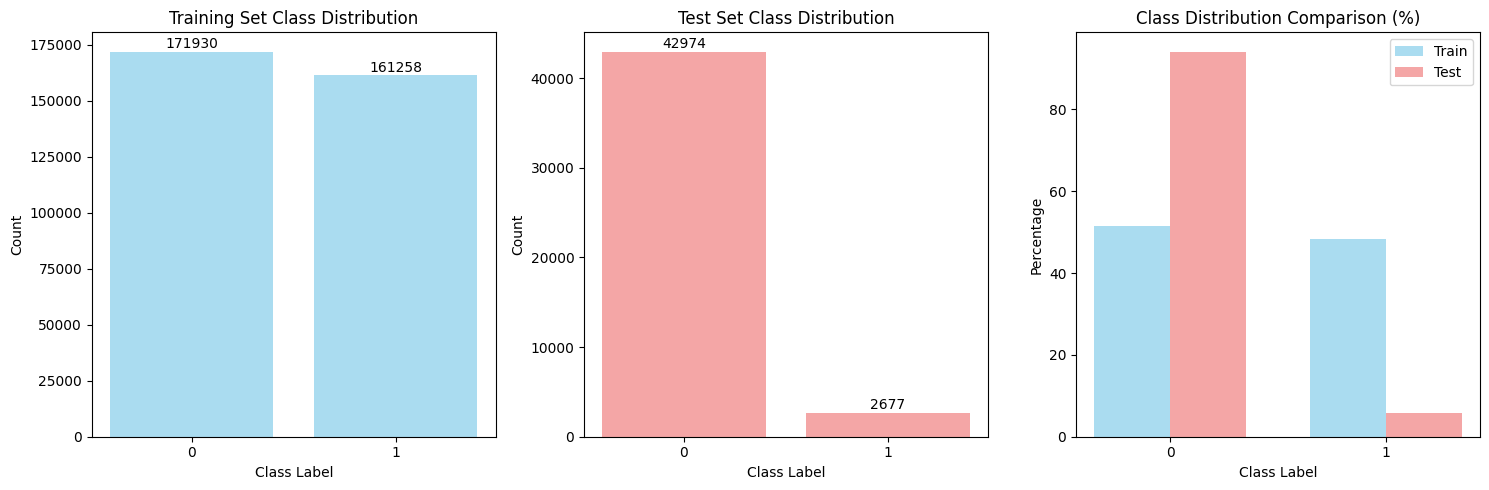


Class Distribution Statistics:
Train set - {0: np.int64(171930), 1: np.int64(161258)}
Test set - {0: np.int64(42974), 1: np.int64(2677)}
Train percentages - {0: np.float64(51.6), 1: np.float64(48.4)}
Test percentages - {0: np.float64(94.14), 1: np.float64(5.86)}

2. FEATURE STATISTICS AND DISTRIBUTIONS

Training Set Feature Statistics:
          Feature_0     Feature_1     Feature_2     Feature_3     Feature_4  \
count  3.331880e+05  3.331880e+05  3.331880e+05  3.331880e+05  3.331880e+05   
mean   1.746992e-16 -3.958028e-17 -4.845172e-17  1.364837e-17  1.774288e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -1.600377e+00 -3.617413e-01 -5.165531e-01 -4.980101e-01 -2.700430e-01   
25%   -7.796662e-01 -3.258554e-01 -4.297953e-01 -4.980101e-01 -2.700430e-01   
50%    8.167732e-02 -3.258554e-01 -2.562797e-01 -3.074830e-01 -2.780505e-02   
75%    8.723083e-01 -2.040219e-01  4.737258e-02  7.357098e-02  1.336869e-01   
max    1.536512e+00  4.903671

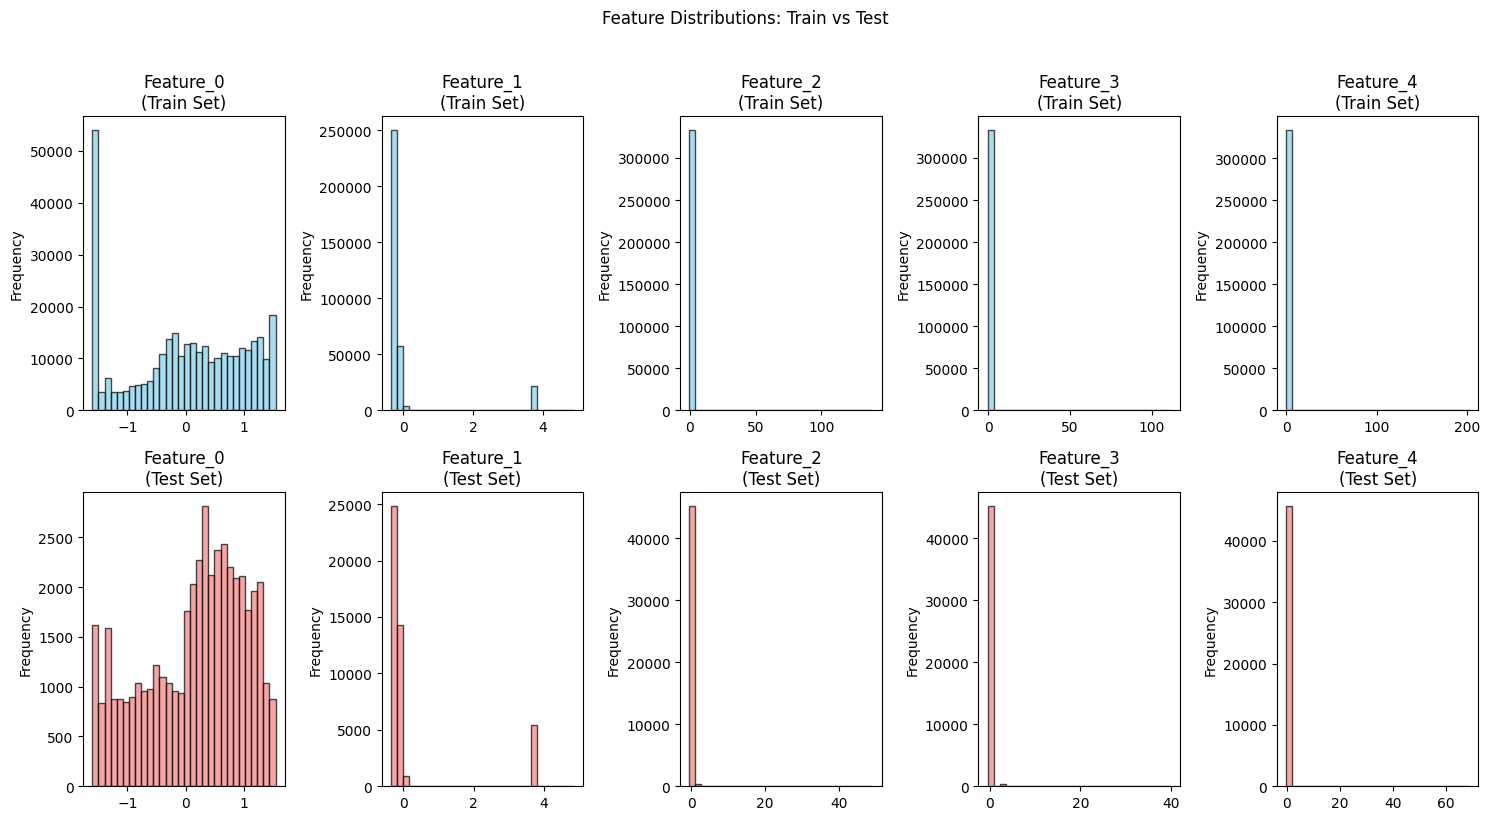


3. CORRELATION ANALYSIS


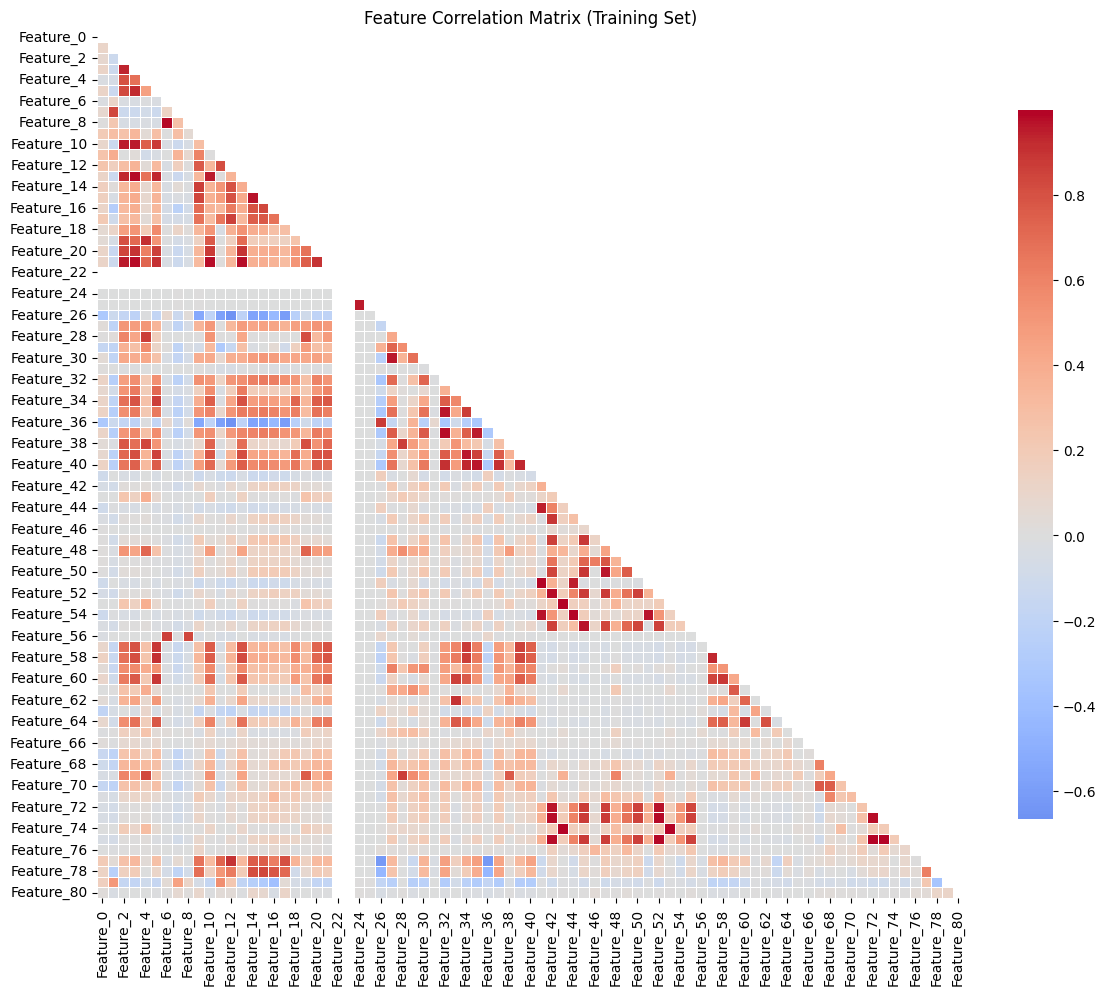


Highly correlated feature pairs (|correlation| > 0.8):
  Feature_1 - Feature_7: 0.832
  Feature_2 - Feature_3: 0.934
  Feature_2 - Feature_4: 0.808
  Feature_2 - Feature_5: 0.827
  Feature_2 - Feature_10: 0.950
  Feature_2 - Feature_13: 0.933
  Feature_2 - Feature_19: 0.805
  Feature_2 - Feature_20: 0.846
  Feature_2 - Feature_21: 0.954
  Feature_3 - Feature_5: 0.927
  Feature_3 - Feature_10: 0.956
  Feature_3 - Feature_13: 0.983
  Feature_3 - Feature_20: 0.899
  Feature_3 - Feature_21: 0.975
  Feature_3 - Feature_39: 0.810
  Feature_3 - Feature_58: 0.815
  Feature_4 - Feature_19: 0.918
  Feature_4 - Feature_28: 0.862
  Feature_4 - Feature_38: 0.833
  Feature_4 - Feature_69: 0.824
  Feature_5 - Feature_10: 0.874
  Feature_5 - Feature_13: 0.932
  Feature_5 - Feature_20: 0.857
  Feature_5 - Feature_21: 0.904
  Feature_5 - Feature_34: 0.857
  Feature_5 - Feature_39: 0.854
  Feature_5 - Feature_57: 0.887
  Feature_5 - Feature_58: 0.907
  Feature_5 - Feature_60: 0.883
  Feature_6 - Feature

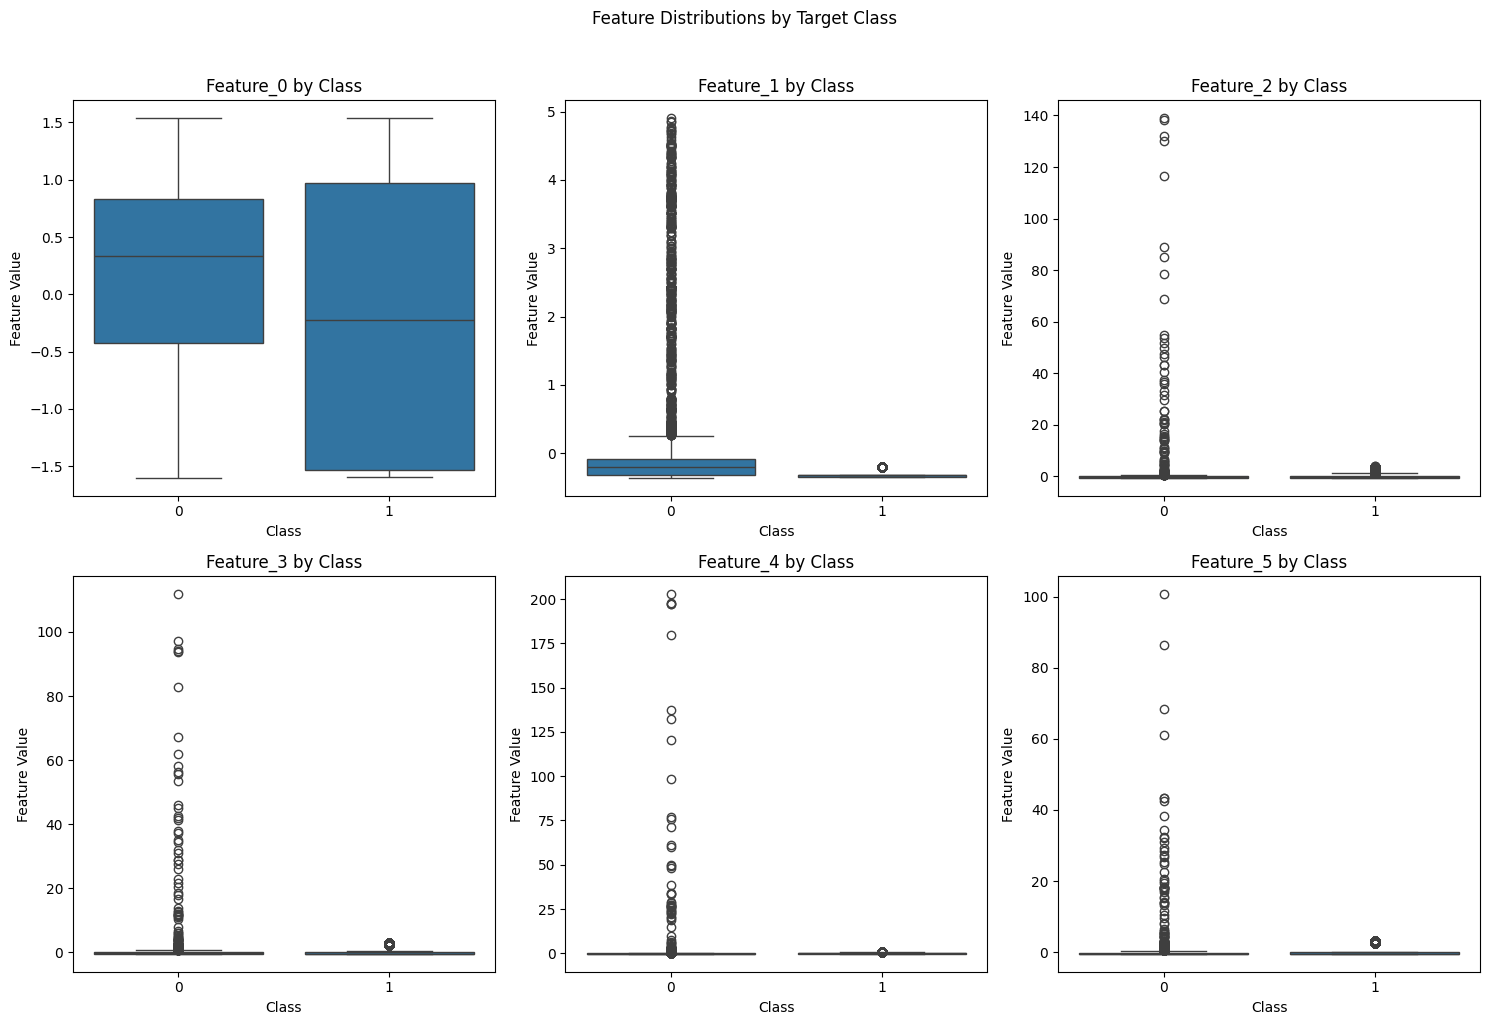


5. DATA QUALITY CHECKS
Missing Values:
Training set: 0 total missing values
Test set: 0 total missing values

Feature Value Ranges (Training Set):
  Feature_0: Range [-1.600, 1.537], Mean: 0.000, Std: 1.000
  Feature_1: Range [-0.362, 4.904], Mean: -0.000, Std: 1.000
  Feature_2: Range [-0.517, 138.903], Mean: -0.000, Std: 1.000
  Feature_3: Range [-0.498, 111.770], Mean: 0.000, Std: 1.000
  Feature_4: Range [-0.270, 202.725], Mean: 0.000, Std: 1.000
  Feature_5: Range [-0.418, 100.625], Mean: -0.000, Std: 1.000
  Feature_6: Range [-0.088, 59.287], Mean: 0.000, Std: 1.000
  Feature_7: Range [-0.289, 103.264], Mean: -0.000, Std: 1.000
  Feature_8: Range [-0.108, 57.906], Mean: 0.000, Std: 1.000
  Feature_9: Range [-1.246, 37.157], Mean: 0.000, Std: 1.000
  Feature_10: Range [-0.517, 123.205], Mean: 0.000, Std: 1.000
  Feature_11: Range [-2.011, 1.765], Mean: 0.000, Std: 1.000
  Feature_12: Range [-2.087, 1.920], Mean: 0.000, Std: 1.000
  Feature_13: Range [-0.508, 109.413], Mean: 0.000

In [14]:
# =============================================================================
# SECTION 6.5: EDA for Train and Test splits
# =============================================================================

def explore_prepared_data(prepared_data, max_features_to_plot=10):
    """
    Comprehensive exploration of prepared ML data with multiple visualizations

    Args:
        prepared_data: Dict containing X_train, X_test, y_train, y_test
        max_features_to_plot: Maximum number of features to plot individually
    """

    # Extract data
    X_train = prepared_data['X_train']
    X_test = prepared_data['X_test']
    y_train = np.array(prepared_data['y_train'])
    y_test = np.array(prepared_data['y_test'])

    # Convert to DataFrame if not already
    if not isinstance(X_train, pd.DataFrame):
        X_train_df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])
        X_test_df = pd.DataFrame(X_test, columns=[f'Feature_{i}' for i in range(X_test.shape[1])])
    else:
        X_train_df = X_train.copy()
        X_test_df = X_test.copy()

    print("="*70)
    print("DATA EXPLORATION SUMMARY")
    print("="*70)

    # Basic info
    print(f"Training set shape: {X_train_df.shape}")
    print(f"Test set shape: {X_test_df.shape}")
    print(f"Number of features: {X_train_df.shape[1]}")
    print(f"Training samples: {len(y_train)}")
    print(f"Test samples: {len(y_test)}")
    print(f"Unique classes in train: {np.unique(y_train)}")
    print(f"Unique classes in test: {np.unique(y_test)}")

    # 1. CLASS DISTRIBUTION ANALYSIS
    print("\n" + "="*50)
    print("1. CLASS DISTRIBUTION ANALYSIS")
    print("="*50)

    plt.figure(figsize=(15, 5))

    # Train set class distribution
    plt.subplot(1, 3, 1)
    train_counts = pd.Series(y_train).value_counts().sort_index()
    plt.bar(range(len(train_counts)), train_counts.values, alpha=0.7, color='skyblue')
    plt.title('Training Set Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.xticks(range(len(train_counts)), train_counts.index)
    for i, v in enumerate(train_counts.values):
        plt.text(i, v + max(train_counts.values)*0.01, str(v), ha='center')

    # Test set class distribution
    plt.subplot(1, 3, 2)
    test_counts = pd.Series(y_test).value_counts().sort_index()
    plt.bar(range(len(test_counts)), test_counts.values, alpha=0.7, color='lightcoral')
    plt.title('Test Set Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.xticks(range(len(test_counts)), test_counts.index)
    for i, v in enumerate(test_counts.values):
        plt.text(i, v + max(test_counts.values)*0.01, str(v), ha='center')

    # Class balance comparison
    plt.subplot(1, 3, 3)
    train_pct = train_counts / len(y_train) * 100
    test_pct = test_counts / len(y_test) * 100
    x = np.arange(len(train_pct))
    width = 0.35
    plt.bar(x - width/2, train_pct.values, width, label='Train', alpha=0.7, color='skyblue')
    plt.bar(x + width/2, test_pct.values, width, label='Test', alpha=0.7, color='lightcoral')
    plt.title('Class Distribution Comparison (%)')
    plt.xlabel('Class Label')
    plt.ylabel('Percentage')
    plt.xticks(x, train_pct.index)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print class statistics
    print("\nClass Distribution Statistics:")
    print(f"Train set - {dict(train_counts)}")
    print(f"Test set - {dict(test_counts)}")
    print(f"Train percentages - {dict(train_pct.round(2))}")
    print(f"Test percentages - {dict(test_pct.round(2))}")

    # 2. FEATURE STATISTICS AND DISTRIBUTIONS
    print("\n" + "="*50)
    print("2. FEATURE STATISTICS AND DISTRIBUTIONS")
    print("="*50)

    # Statistical summary
    print("\nTraining Set Feature Statistics:")
    print(X_train_df.describe())

    # Feature distributions for first few features
    n_features_to_show = min(max_features_to_plot, X_train_df.shape[1])
    if n_features_to_show > 0:
        # Histograms
        fig, axes = plt.subplots(2, min(5, n_features_to_show), figsize=(15, 8))
        if n_features_to_show == 1:
            axes = np.array([[axes]])
        elif n_features_to_show <= 5:
            axes = axes.reshape(2, -1)

        for i in range(min(5, n_features_to_show)):
            col_name = X_train_df.columns[i]

            # Train distribution
            axes[0, i].hist(X_train_df.iloc[:, i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, i].set_title(f'{col_name}\n(Train Set)')
            axes[0, i].set_ylabel('Frequency')

            # Test distribution
            axes[1, i].hist(X_test_df.iloc[:, i], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
            axes[1, i].set_title(f'{col_name}\n(Test Set)')
            axes[1, i].set_ylabel('Frequency')

        # Hide unused subplots
        for i in range(min(5, n_features_to_show), 5):
            if i < axes.shape[1]:
                axes[0, i].set_visible(False)
                axes[1, i].set_visible(False)

        plt.suptitle('Feature Distributions: Train vs Test', y=1.02)
        plt.tight_layout()
        plt.show()

    # 3. CORRELATION ANALYSIS
    print("\n" + "="*50)
    print("3. CORRELATION ANALYSIS")
    print("="*50)

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    corr_matrix = X_train_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix (Training Set)')
    plt.tight_layout()
    plt.show()

    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if high_corr_pairs:
        print(f"\nHighly correlated feature pairs (|correlation| > 0.8):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} - {feat2}: {corr:.3f}")
    else:
        print("\nNo highly correlated feature pairs found (|correlation| > 0.8)")

    # 4. FEATURE-TARGET RELATIONSHIPS
    print("\n" + "="*50)
    print("4. FEATURE-TARGET RELATIONSHIPS")
    print("="*50)

    # Box plots for first few features by class
    n_box_plots = min(6, n_features_to_show)
    if n_box_plots > 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i in range(n_box_plots):
            col_name = X_train_df.columns[i]
            data_for_plot = pd.DataFrame({
                'feature': X_train_df.iloc[:, i],
                'target': y_train
            })
            sns.boxplot(data=data_for_plot, x='target', y='feature', ax=axes[i])
            axes[i].set_title(f'{col_name} by Class')
            axes[i].set_xlabel('Class')
            axes[i].set_ylabel('Feature Value')

        # Hide unused subplots
        for i in range(n_box_plots, 6):
            axes[i].set_visible(False)

        plt.suptitle('Feature Distributions by Target Class', y=1.02)
        plt.tight_layout()
        plt.show()

    # 5. DATA QUALITY CHECKS
    print("\n" + "="*50)
    print("5. DATA QUALITY CHECKS")
    print("="*50)

    # Missing values
    train_missing = X_train_df.isnull().sum()
    test_missing = X_test_df.isnull().sum()

    print("Missing Values:")
    print(f"Training set: {train_missing.sum()} total missing values")
    print(f"Test set: {test_missing.sum()} total missing values")

    if train_missing.sum() > 0 or test_missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Feature': X_train_df.columns,
            'Train_Missing': train_missing.values,
            'Test_Missing': test_missing.values
        })
        print(missing_df[missing_df['Train_Missing'] + missing_df['Test_Missing'] > 0])

    # Feature ranges and scaling check
    print(f"\nFeature Value Ranges (Training Set):")
    for i, col in enumerate(X_train_df.columns):  # Show first 5 features
        min_val, max_val = X_train_df[col].min(), X_train_df[col].max()
        mean_val, std_val = X_train_df[col].mean(), X_train_df[col].std()
        print(f"  {col}: Range [{min_val:.3f}, {max_val:.3f}], Mean: {mean_val:.3f}, Std: {std_val:.3f}")


    # TRAIN-TEST DISTRIBUTION COMPARISON
    print("\n" + "="*50)
    print("6. TRAIN-TEST DISTRIBUTION COMPARISON")
    print("="*50)

    # Statistical tests for distribution differences
    distribution_tests = []
    for i, col in enumerate(X_train_df.columns[:min(10, X_train_df.shape[1])]):
        # Kolmogorov-Smirnov test
        ks_stat, ks_p = stats.ks_2samp(X_train_df[col], X_test_df[col])
        distribution_tests.append({
            'Feature': col,
            'KS_Statistic': ks_stat,
            'KS_P_Value': ks_p,
            'Distributions_Similar': ks_p > 0.05
        })

    test_df = pd.DataFrame(distribution_tests)
    print("\nKolmogorov-Smirnov Tests for Train-Test Distribution Similarity:")
    print("(p > 0.05 indicates similar distributions)")
    print(test_df.to_string(index=False))

    # Summary statistics
    print(f"\nFeatures with significantly different distributions: {(test_df['KS_P_Value'] <= 0.05).sum()}")
    print(f"Features with similar distributions: {(test_df['KS_P_Value'] > 0.05).sum()}")

    # DIMENSIONALITY AND SPARSITY
    print("\n" + "="*50)
    print("7. DIMENSIONALITY AND SPARSITY ANALYSIS")
    print("="*50)

    # Zero values analysis
    zero_counts_train = (X_train_df == 0).sum()
    zero_counts_test = (X_test_df == 0).sum()

    print(f"Sparsity Analysis:")
    print(f"Average percentage of zeros per feature (Train): {(zero_counts_train / len(X_train_df) * 100).mean():.2f}%")
    print(f"Average percentage of zeros per feature (Test): {(zero_counts_test / len(X_test_df) * 100).mean():.2f}%")

    # Features with high sparsity
    sparse_features = zero_counts_train[zero_counts_train / len(X_train_df) > 0.8]
    if len(sparse_features) > 0:
        print(f"\nHighly sparse features (>80% zeros):")
        for feat, count in sparse_features.items():
            pct = count / len(X_train_df) * 100
            print(f"  {feat}: {pct:.1f}% zeros")



# Run the exploration function
explore_prepared_data(prepared_data)


In [15]:
# =============================================================================
# SECTION 6.5: TRAIN AND TEST ALL ML and DL MODELS
# =============================================================================

def create_pytorch_model(input_dim, output_dim, hidden_dims=[128, 64, 32], dropout=0.3):
    """Create the neural network architecture"""
    layers = []
    prev_dim = input_dim

    # Hidden layers
    for hidden_dim in hidden_dims:
        layers.append(nn.Linear(prev_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        prev_dim = hidden_dim

    # Output layer
    layers.append(nn.Linear(prev_dim, output_dim))

    return nn.Sequential(*layers)

def train_pytorch_model(X, y, hidden_dims=[128, 64, 32], dropout=0.3,
                       learning_rate=0.001, epochs=5000, batch_size=32,
                       random_state=RANDOM_SEED, verbose=True,
                       early_stopping=True, patience=10, min_delta=0.0):
    """Train a neural network model with early stopping"""

    # Set random seeds
    torch.manual_seed(random_state)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_state)

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert to tensors
    X_tensor = torch.FloatTensor(X).to(device)

    # Handle labels
    classes = np.unique(y)
    y_encoded = np.array([np.where(classes == label)[0][0] for label in y])
    y_tensor = torch.LongTensor(y_encoded).to(device)

    # Create model
    input_dim = X.shape[1]
    output_dim = len(classes)
    model = create_pytorch_model(input_dim, output_dim, hidden_dims, dropout).to(device)

    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop with early stopping
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        # Print progress every 20 epochs
        if verbose and (epoch + 1) % 20 == 0:
            print(f"    Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Early stopping check
        if early_stopping:
            if best_loss - avg_loss > min_delta:
                best_loss = avg_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                if verbose:
                    print(f"    Early stopping triggered at epoch {epoch+1}")
                break

    # Return model components
    return {
        'model': model,
        'classes': classes,
        'device': device,
        'input_dim': input_dim,
        'output_dim': output_dim
    }

def pytorch_predict(model_dict, X):
    """Make predictions with trained Neural Network model"""
    model = model_dict['model']
    classes = model_dict['classes']
    device = model_dict['device']

    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels = [classes[pred.item()] for pred in predicted]

    return np.array(predicted_labels)

def pytorch_predict_proba(model_dict, X):
    """Predict class probabilities with trained Neural Network model"""
    model = model_dict['model']
    device = model_dict['device']

    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        outputs = model(X_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.cpu().numpy()

def train_and_evaluate_all_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple ML models with comprehensive metrics
    """
    print("\n" + "="*70)
    print("ML MODEL TRAINING AND EVALUATION")
    print("="*70)

    # Define traditional models
    traditional_models = {
        'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED),
        #'Support Vector Machine': SVC(probability=True, random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB()
    }

    results = {}

    # Train traditional models
    for name, model in traditional_models.items():
        print(f"\nTraining {name}...")
        try:
            # Train model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            # ROC-AUC
            roc_auc = None
            try:
                if y_pred_proba is not None:
                    if len(np.unique(y_test)) == 2:
                        roc_auc = roc_auc_score(y_test, y_pred_proba)
                    else:
                        roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
            except Exception as e:
                print(f"   Warning: Could not calculate ROC-AUC - {str(e)}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Store results
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'confusion_matrix': cm,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            # Display results
            roc_display = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
            print(f"   ✓ Success! Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
                  f"Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_display}")

        except Exception as e:
            print(f"   ✗ Failed to train {name}: {str(e)}")
            continue

    # Train PyTorch Neural Network
    print(f"\nTraining Neural Network...")
    try:
        # Train the neural network
        pytorch_model_dict = train_pytorch_model(
            X_train, y_train,
            hidden_dims=[128, 64, 32],
            dropout=0.3,
            learning_rate=0.001,
            epochs=1000,
            batch_size=256,
            random_state=RANDOM_SEED,
            verbose=True
        )

        # Make predictions
        y_pred = pytorch_predict(pytorch_model_dict, X_test)
        y_pred_proba = pytorch_predict_proba(pytorch_model_dict, X_test)

        # Handle probability for binary/multiclass
        if len(np.unique(y_test)) == 2:
            y_pred_proba_roc = y_pred_proba[:, 1]
        else:
            y_pred_proba_roc = y_pred_proba

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # ROC-AUC
        roc_auc = None
        try:
            if len(np.unique(y_test)) == 2:
                roc_auc = roc_auc_score(y_test, y_pred_proba_roc)
            else:
                roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
        except Exception as e:
            print(f"   Warning: Could not calculate ROC-AUC - {str(e)}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results['Neural Network'] = {
            'model': pytorch_model_dict,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba_roc if len(np.unique(y_test)) == 2 else y_pred_proba
        }

        # Display results
        roc_display = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
        print(f"   ✓ Success! Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_display}")

    except Exception as e:
        print(f"   ✗ Failed to train PyTorch Neural Network: {str(e)}")

    return results

# Train all models
model_results = train_and_evaluate_all_models(
    prepared_data['X_train'],
    prepared_data['X_test'],
    prepared_data['y_train'],
    prepared_data['y_test']
)



ML MODEL TRAINING AND EVALUATION

Training Random Forest...
   ✓ Success! Accuracy: 0.9661, Precision: 0.9673, Recall: 0.9661, F1: 0.9595, ROC-AUC: 0.8668

Training Gradient Boosting...
   ✓ Success! Accuracy: 0.9496, Precision: 0.9521, Recall: 0.9496, F1: 0.9312, ROC-AUC: 0.9677

Training Logistic Regression...
   ✓ Success! Accuracy: 0.9720, Precision: 0.9805, Recall: 0.9720, F1: 0.9744, ROC-AUC: 0.9875

Training Naive Bayes...
   ✓ Success! Accuracy: 0.7070, Precision: 0.9478, Recall: 0.7070, F1: 0.7847, ROC-AUC: 0.8375

Training Neural Network...
    Early stopping triggered at epoch 16
   ✓ Success! Accuracy: 0.9837, Precision: 0.9838, Recall: 0.9837, F1: 0.9825, ROC-AUC: 0.9932


ROC-AUC VISUALIZATION

CREATING EVALUATION DASHBOARD...


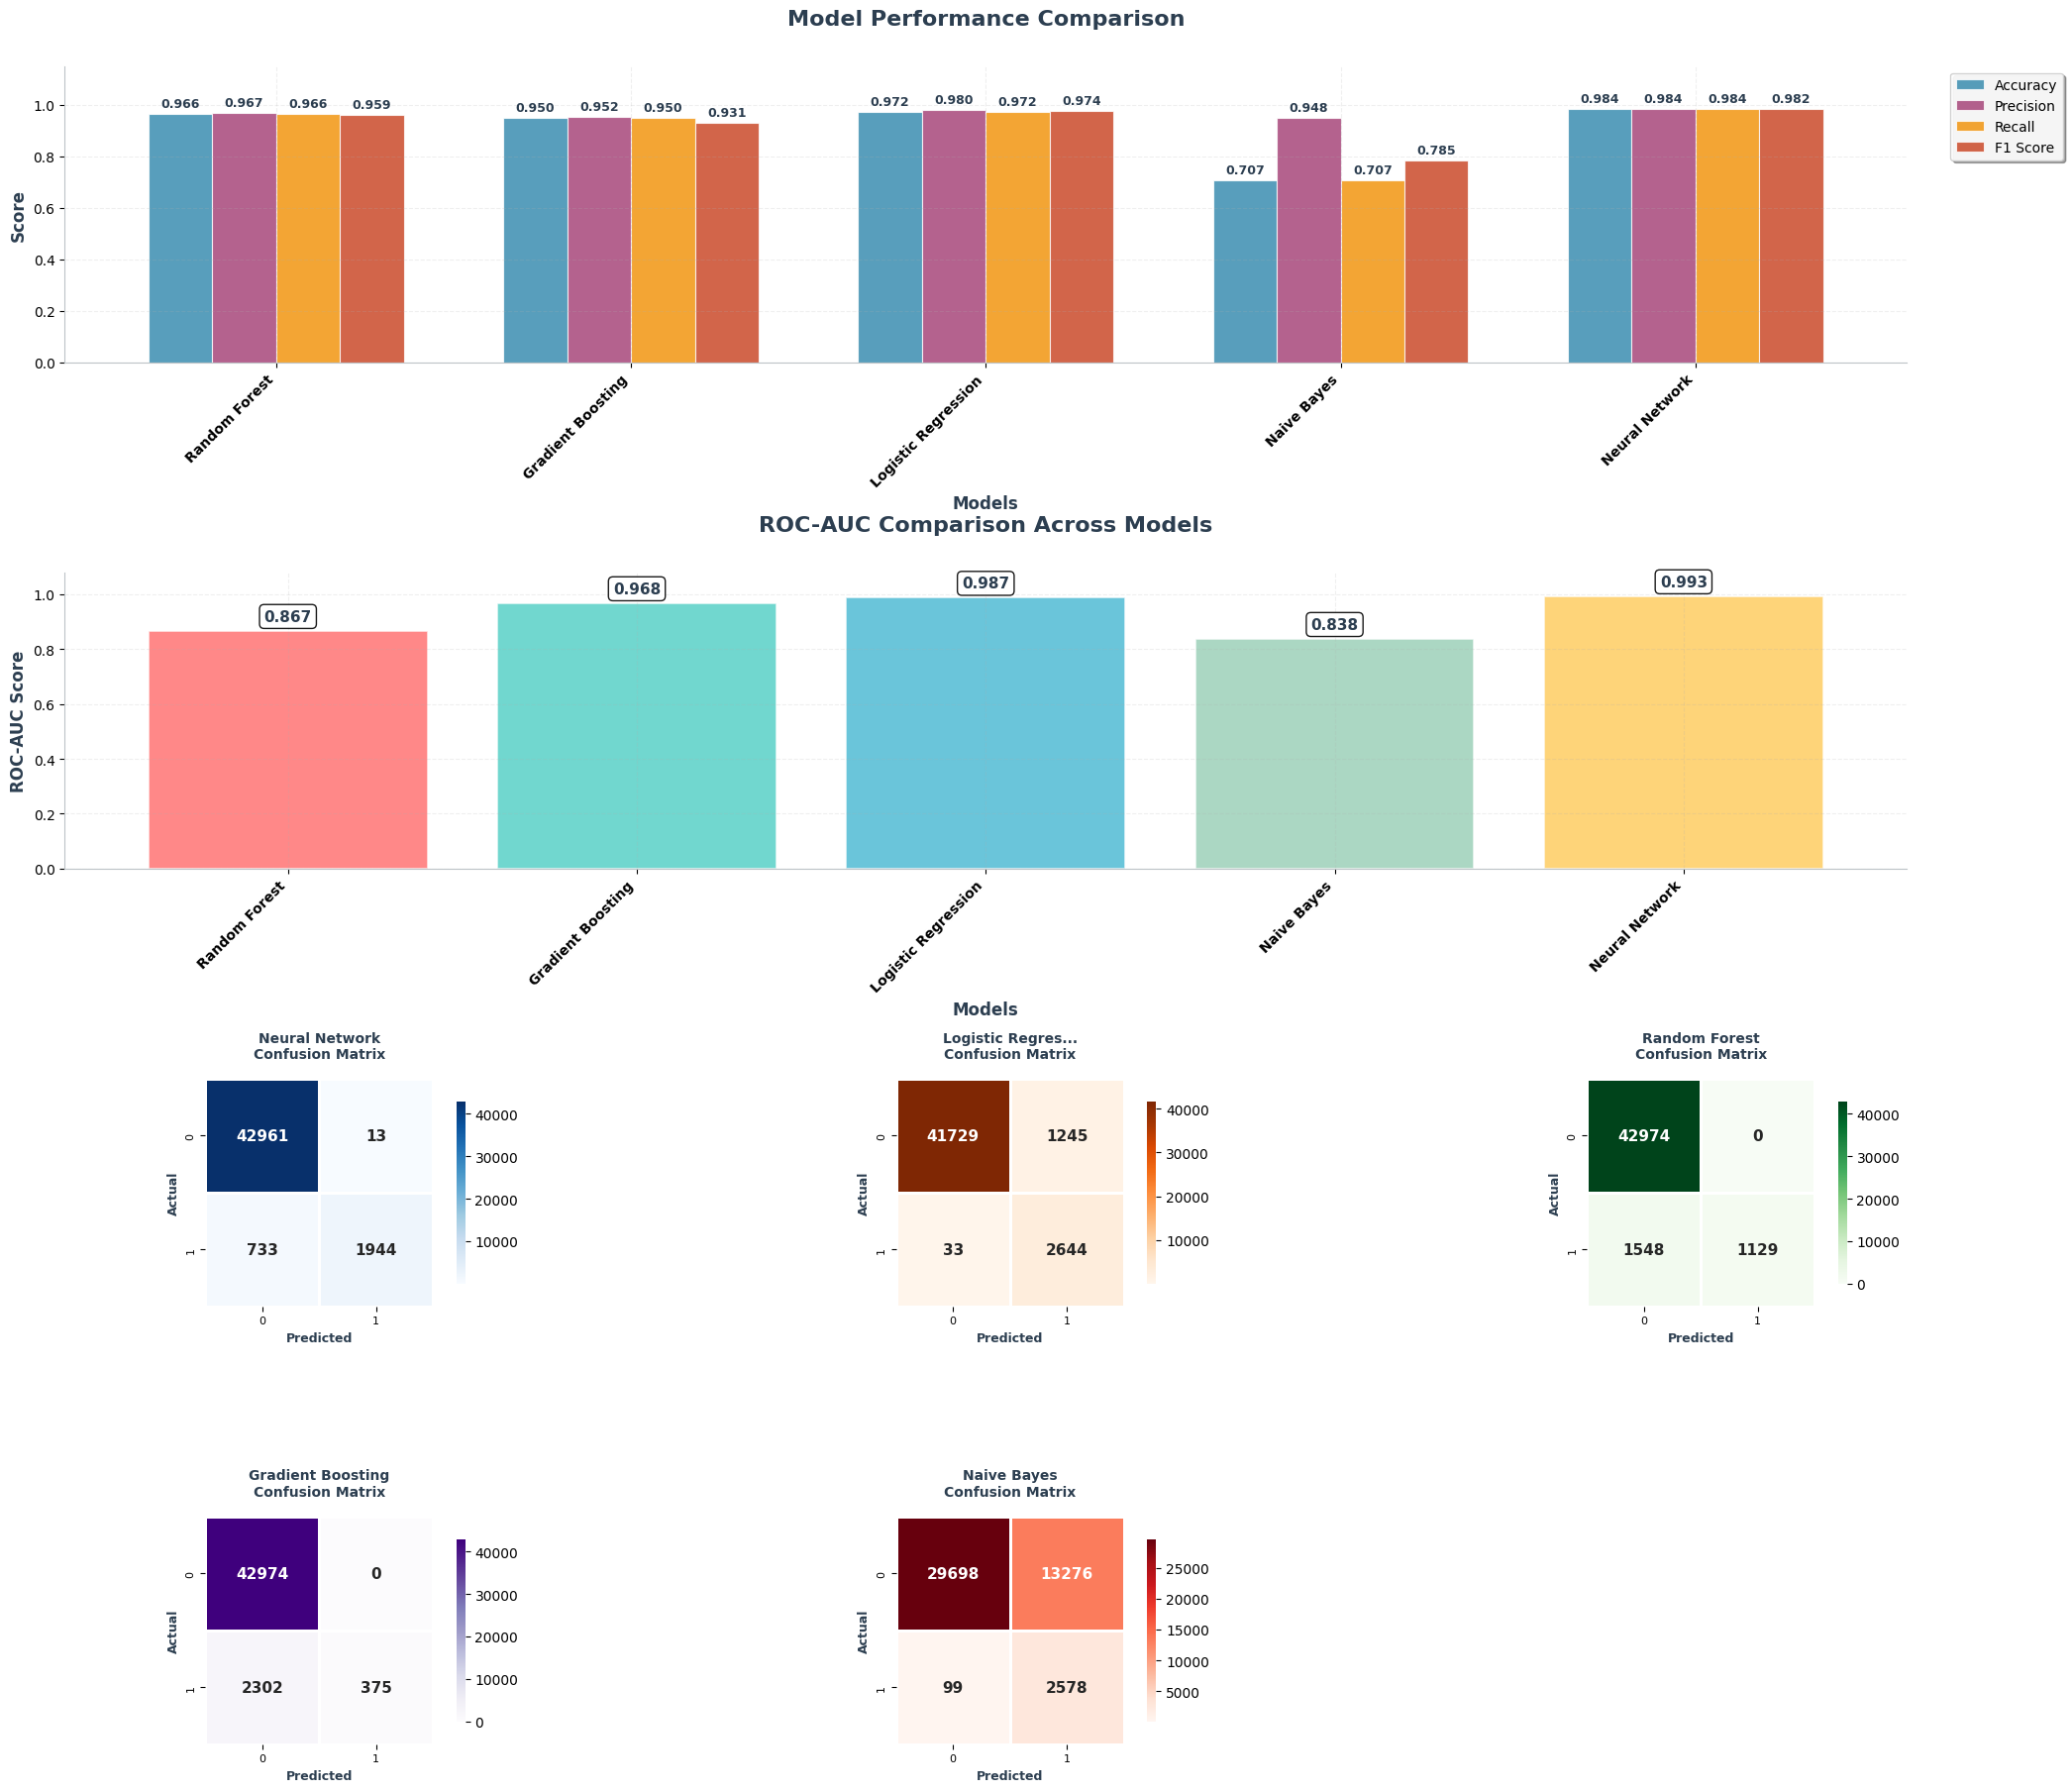

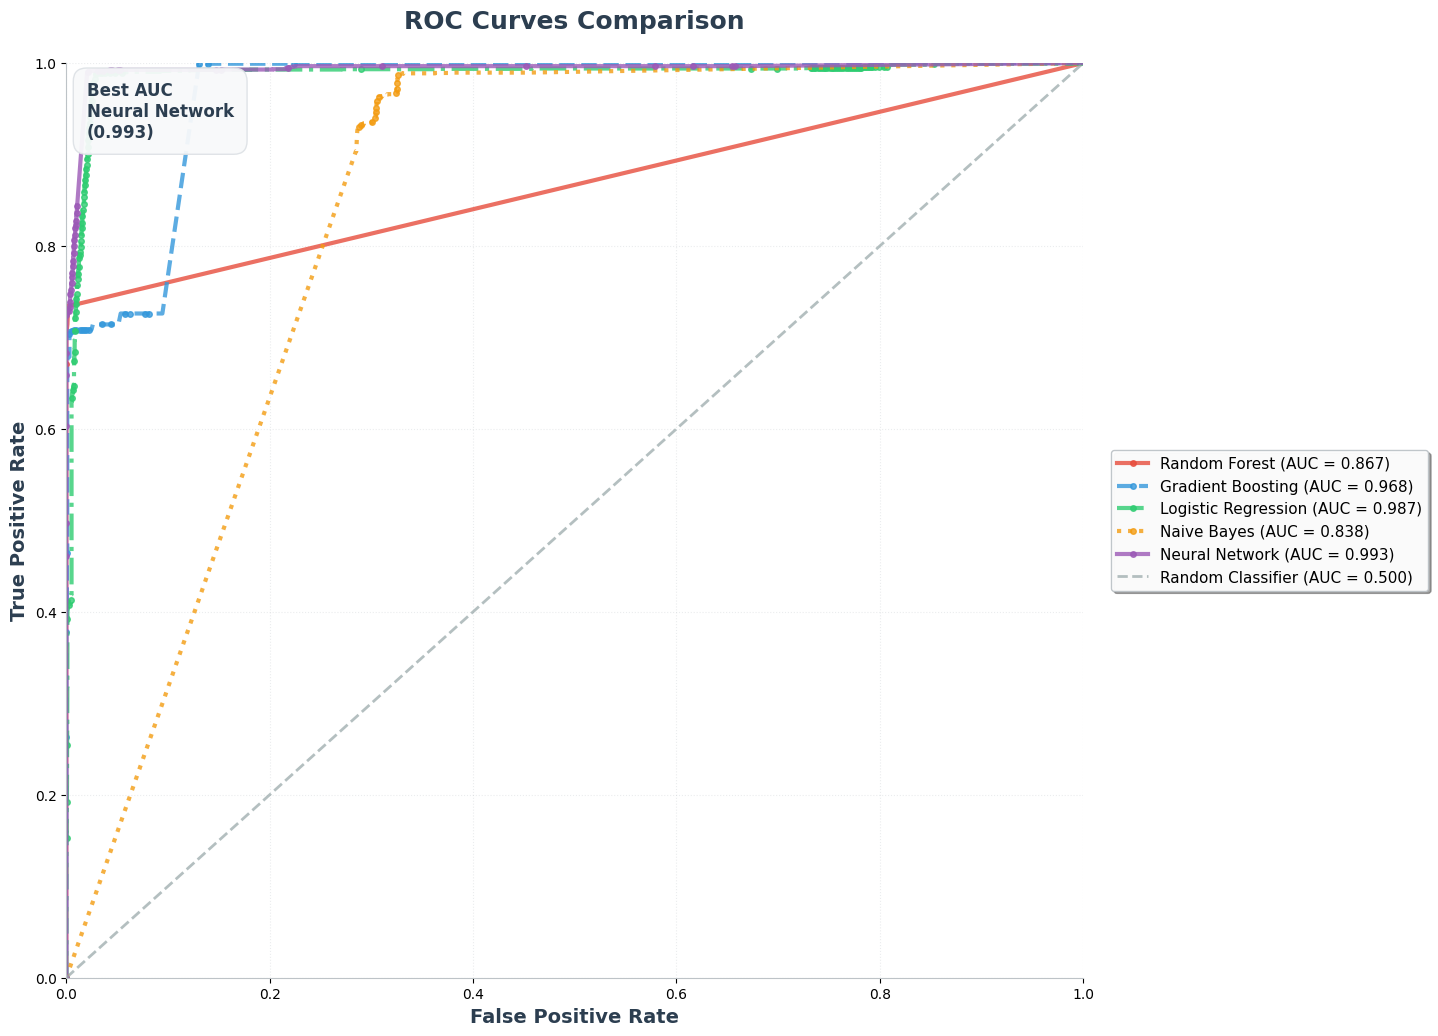




🎯 DETAILED PERFORMANCE METRICS TABLE
Model                     Accuracy   Precision   Recall     F1-Score   ROC-AUC    Status    
───────────────────────────────────────────────────────────────────────────────────────────────
Neural Network            0.9837     0.9838      0.9837     0.9825     0.9932     Best      
Logistic Regression       0.9720     0.9805      0.9720     0.9744     0.9875     2nd       
Gradient Boosting         0.9496     0.9521      0.9496     0.9312     0.9677     3rd       
Random Forest             0.9661     0.9673      0.9661     0.9595     0.8668     Good      
Naive Bayes               0.7070     0.9478      0.7070     0.7847     0.8375     Good      

ROC-AUC SUMMARY STATISTICS
Best ROC-AUC:     0.9932
Average ROC-AUC:  0.9305
Std Dev ROC-AUC:  0.0652
Models with ROC:  5/5



CREATING ROC-AUC COMPARISON ANALYSIS...


<Figure size 1400x800 with 0 Axes>

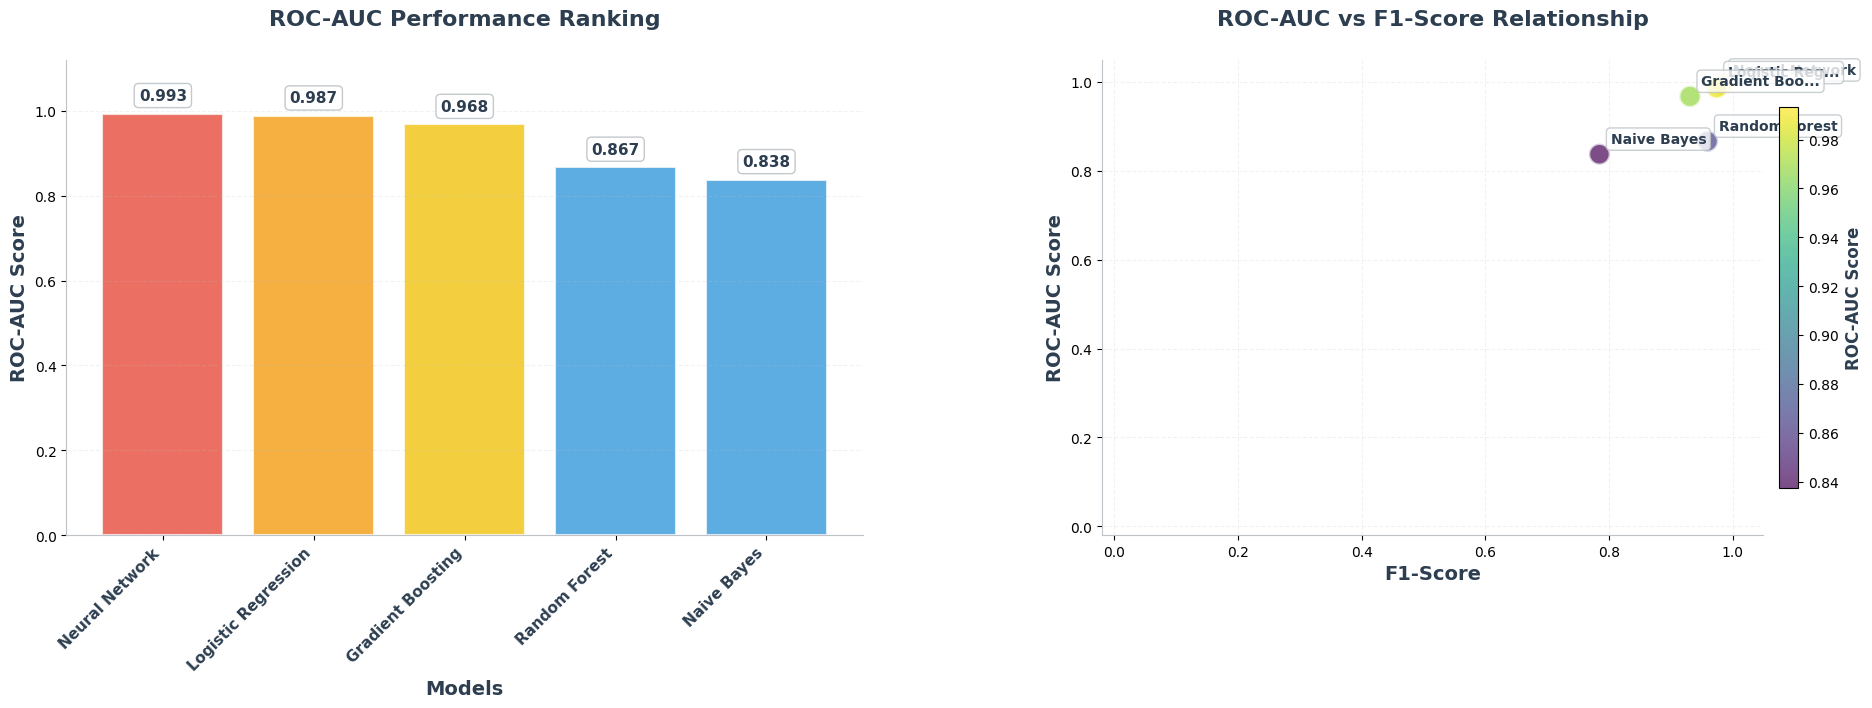


PIPELINE SUMMARY
Models with ROC-AUC: 5
Interactive analysis: ROC-AUC vs F1-Score relationship


In [16]:
# =============================================================================
# SECTION 6.6: RUN DASHBOARDS AND AUC-ROC
# =============================================================================


def execute_pipeline_with_roc(result_dict, random_state=RANDOM_SEED):
    """
    Execute the complete pipeline with enhanced ROC-AUC visualizations
    """
    print("="*80)
    print("ROC-AUC VISUALIZATION")
    print("="*80)

    # Create dashboard with ROC-AUC charts
    print("\nCREATING EVALUATION DASHBOARD...")
    create_evaluation_dashboard_with_roc(model_results, prepared_data['y_test'])

    # Create standalone ROC-AUC comparison
    print("\nCREATING ROC-AUC COMPARISON ANALYSIS...")
    roc_comparison_data = create_roc_auc_comparison_chart(model_results)



    # Summary
    print("\n" + "="*80)
    print("PIPELINE SUMMARY")
    print("="*80)
    print(f"Models with ROC-AUC: {len([r for r in model_results.values() if r['roc_auc'] is not None])}")
    print(f"Interactive analysis: ROC-AUC vs F1-Score relationship")

    return {
        'prepared_data': prepared_data,
        'model_results': model_results,
        'roc_comparison_data': roc_comparison_data
    }


# Execute
enhanced_results = execute_pipeline_with_roc(result)
